# Setup environment
this is required only once; skip from the second time

In [ ]:
## it is recommended to create a new conda environment

# install standard libraries
!conda install seaborn jupyterlab ipywidgets pyarrow
!pip install iterative-stratification rdkit mordred
#!ipython kernel install --user --name=mordred
!jupyter nbextension enable --py widgetsnbextension

## install LightGBM 
!pip install lightgbm

## install Graph NN (PyG): this requires GPU and CUDA to be properly configured on your machine.
!conda install pytorch torchvision torchaudio torcheval pytorch-cuda=11.8 -c pytorch -c nvidia
!conda install pyg -c pyg


# Load libraries
start here

In [ ]:
# load necessary libraries
import pandas as pd
import os,re,warnings
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time, warnings
from datetime import datetime

from rdkit import Chem
from mordred import Calculator, descriptors

from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score,classification_report,confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from tqdm.auto import tqdm

pd.options.display.max_columns = 100

# splitting for CV
def cv_split(mode,sub_df,n_splits=5,targets=None):
    if mode=="classification":
        skf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    skf.get_n_splits(sub_df['SMILES'],sub_df.loc[:,targets])
    train_indices, test_indices = [],[]
    for (train_i, test_i) in skf.split(sub_df,sub_df.loc[:,targets]):
        train_indices.append(train_i)
        test_indices.append(test_i)
    return(train_indices,test_indices)

# print classification results
def print_results(result_df,targets,use_desc=None,display="all"):
    print(f"Number of SMILES: {len(result_df)}")
    csv_df=[]
    if use_desc is not None:
        print(f"{use_desc}: num of variables: {len(varnames)}")
    for target in targets:
        rdic = {'type':target[0]}
        #mask = ~result_df['true_'+target].isna()
        num_classes=result_df['true_'+target].nunique()
        if num_classes<2:
            continue
        print(f'\nprediction target {target} ({num_classes} classes)')
        if display=="all":
            print(classification_report(result_df['true_'+target],result_df['pred_'+target],digits=5))
            print(confusion_matrix(result_df['true_'+target],result_df['pred_'+target]))
        else:
            print("Accuracy: ",round(metrics.accuracy_score(result_df['true_'+target],result_df['pred_'+target]),5))
        print("Cohen's kappa: ",metrics.cohen_kappa_score(result_df['true_'+target],result_df['pred_'+target]))
        print("Matthew's coeff: ", metrics.matthews_corrcoef(result_df['true_'+target],result_df['pred_'+target]))
        rdic['npos'] = sum(result_df['true_'+target]>0)
        print(f"Positives: {rdic['npos']}")
        rdic['acc'] = round(metrics.accuracy_score(result_df['true_'+target]>0,result_df['pred_'+target]>0),5)
        rdic['f1']=round(metrics.f1_score(result_df['true_'+target]>0,result_df['pred_'+target]>0),5)
        if f'pos_conf_{target}' in result_df.keys():
            auc = roc_auc_score(result_df['true_'+target]>0,result_df['pos_conf_'+target])
            print("AUC: ",auc)
            rdic['AUC']=auc            
        # temperature
        lte = f'error_{target[0]}'
        if lte+'p' in result_df.keys():
            rdic['Tp_mean'] = result_df[lte+'p'].mean()
            rdic['Tp_std'] = result_df[lte+'p'].std()
            rdic['Tm_mean'] = result_df[lte+'m'].mean()
            rdic['Tm_std'] = result_df[lte+'m'].std()
        # two-class
        if num_classes==2:
            val = result_df['conf_'+target].values
            val[result_df['pred_'+target]==0] = 1-val[result_df['pred_'+target]==0]
            #print("AUC: ",roc_auc_score(result_df['true_'+target]>0,val))
            print("F1: ",round(metrics.f1_score(result_df['true_'+target],result_df['pred_'+target]),5))
        else:
            print(f'\nprediction target {target} (2 classes)')
            if display=="all":
                print(classification_report(result_df['true_'+target]>0,result_df['pred_'+target]>0,digits=5))
                print(confusion_matrix(result_df['true_'+target]>0,result_df['pred_'+target]>0))
            else:
                print("Accuracy: ",rdic['acc'])
                print("F1: ",rdic['f1'])
            print("Cohen's kappa: ",metrics.cohen_kappa_score(result_df['true_'+target]>0,result_df['pred_'+target]>0))
            print("Matthew's coeff: ", metrics.matthews_corrcoef(result_df['true_'+target]>0,result_df['pred_'+target]>0))
        csv_df.append(rdic)
    return(pd.DataFrame(csv_df).set_index('type'))

# construct predicted Phase sequences from dataframe
def pred_phases(results_df):
    PHS = []
    for i,sd in tqdm(results_df.iterrows(),total=len(results_df)):
        ph=f"Cr {sd['pred_Melting']:.2f}"
        pts = []
        for t in phase_types:
            if sd[f'pred_{t}type']>0:
                ut = "Dh" if t=="D" else t
                ut = ut if sd[f'pred_{t}type']==1 else ut+"*"
                pts.append((sd[f'pred_{t}m'],ut,sd[f'pred_{t}p']))
        for p in sorted(pts,key=lambda x:x[2]):
            ph += f" {p[0]:.2f} {p[1]} {p[2]:.2f}"
            
        ph += f" {sd['pred_Clearing']:.2f} is"
        PHS.append(ph)
    return(PHS)



In [ ]:
## global settings
# after this cell, jump to the "Compute descriptors from SMILES and parse Phase sequence" section at the first run

num_cores = 32 ## choose an appropriate number depending on your CPU
random_state = 42 # use this seed globally to obtain consistent CV splitting
n_splits=5 ## number of splits in CV

## data files
descriptor_fn = os.path.expanduser("~/ssd/LiqCryst52.parquet") # the csv or parquet file produced by the "Compute descriptors from SMILES and parse Phase sequence" section in this file
#descriptor_fn = 'sample_desc.csv' # the csv or parquet file produced by the "Compute descriptors from SMILES and parse Phase sequence" section in this file
outdir = "result_sample" # results will be saved in this directory
remove_duplicate_SMILES = True

os.makedirs(outdir,exist_ok=True)

### global variables
nonvars =[
  "ID","SMILES","Phases","rac_en","Melting","Melting_type",
  "Clearing_type","Clearing",
  "Stype","Xtype","Ytype", ## unclear phases
  "exclude","reentrant","prohibited"
]

min_number_of_NandC = 12 # molecules with the total N and C atoms less than this number will be excluded
kelv = -273.15
permitted_list_of_atoms =  ['H','C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
phase_types = ["N","A","B","C","D","E","F","G","H","I","J"]
temperature_types = ["Clearing","Melting"]
for lt in phase_types:
    temperature_types.extend([lt+"p",lt+"m"])
    nonvars.extend([lt+"m",lt+"p",lt+"type"])


# Load dataset from file

In [ ]:
# load the master data file containing SMILES, transition temperaturs etc
if os.path.isfile(descriptor_fn):
    if descriptor_fn.endswith('.parquet'):
        print("loading from parquet...")
        df = pd.read_parquet(descriptor_fn)
        if 'ID' in df.keys():
            df = df.sort_values('ID').set_index('ID')        
    else:
        print("loading from csvs...")
        df = pd.read_csv(descriptor_fn,low_memory=False).sort_values('ID').set_index('ID')
if 'num_C' in df.keys():
    df = df.drop(columns=['num_H','num_N','num_C'])
f=df.pop('Phases')
df.insert(loc=2,column='Phases',value=f)
print("# entries: ", len(df))

if remove_duplicate_SMILES:
    vc = df['SMILES'].value_counts()
    nonunique = vc[vc>1].keys()
    df = df[~df['SMILES'].isin(nonunique)]
    #df[df['SMILES'].isin(nonunique)].sort_values(['SMILES'])[['ID','SMILES','Phases']].to_csv('nonunique_smiles.csv')
    print("# entries after removing duplicates: ", len(df))


loading from parquet...
# entries:  97244
# entries after removing duplicates:  95576


In [ ]:
# filtering
if min_number_of_NandC>0:
    df = df[(df['nC']+df['nN']>=min_number_of_NandC)]
    print("# after excluding small molecules: ",len(df))    
if 'exclude' in df.keys():   
    df = df[ ~df['exclude'] ]
    print("# after excluding those with ambiguous phase entries: ",len(df))
if 'prohibited' in df.keys():
    df['prohibited']=df['prohibited'].astype(bool)
    df = df[~df['prohibited']]
    print("# after excluding those containing prohibited atoms: ",len(df))
if 'reentrant' in df.keys():   
    df = df[ ~df['reentrant'] ]
    print("# after excluding reentrant phases: ",len(df))
if 'Clearingtype' in df.keys():   
    df = df[ df['Clearingtype']==1 ]
    print("# after excluding non-standard clearing type: ",len(df))

# Wrong phase?
er = []
for lt in phase_types:
    mask = df[lt+"m"]>df[lt+"p"]
    if sum(mask)>0:
        er.append(df[mask][['SMILES','Phases']])
        print("non-increasing phase transition temperatures: ",lt,sum(mask),"/",sum(df[lt+'type']>0))
    df = df[~mask]
#err_df = pd.concat(er)
#err_df.to_csv('inverted_phases.csv')

# teperature types
for tt in temperature_types:
    df.loc[(df[tt] < kelv) | (df[tt] >= 800) | (df[tt] == 0), tt] = np.nan ## magic number to indicate invalid or non-existent      
# clearing and melting type
#df = df[df['Clearingtype']<2]
#df = df[df['Meltingtype']<2]

for x in ['X','S','no','un','ex']:
    mask = [x not in z for z in df['Phases']]
    print(f"Excluding {len(mask)-sum(mask)} phases containing {x}")
    df=df[mask]
# df = df[ (df['Xtype']==0) & (df['Stype']==0) & (df['Ytype']==0) ] 
#df = df[ ["'" not in z for z in df['Phases']] ] # remove Cr'
#df = df[df[temperature_types].min(axis=1)<df[temperature_types].max(axis=1)] # at least two
df = df[ ["?" not in z for z in df['Phases']] ]
df = df[ [" 0 " not in z for z in df['Phases']] ] # remove 0 temperature
df = df[~np.isnan(df[temperature_types].min(axis=1))] # at least one known temperature
print("# after filtering: ",len(df))

df.head()

# after excluding small molecules:  94070
# after excluding those with ambiguous phase entries:  60914
# after excluding those containing prohibited atoms:  55411
# after excluding reentrant phases:  55354
# after excluding non-standard clearing type:  52402
non-increasing phase transition temperatures:  E 138 / 537
non-increasing phase transition temperatures:  H 45 / 97
non-increasing phase transition temperatures:  J 32 / 100
Excluding 0 phases containing X
Excluding 0 phases containing S
Excluding 0 phases containing no
Excluding 0 phases containing un
Excluding 0 phases containing ex
# after filtering:  43889


SMILES  reentrant      Phases  Clearingtype  \
ID                                                                             
3      CCCCCCCCCCCCCCCC(=O)OC1C=CC=CC=1      False    Cr 46 is             1   
4    CCCCCCCCCCCCCCCCCC(=O)OC1C=CC=CC=1      False    Cr 52 is             1   
5     CCCCCCCCCCCCCCCC(=O)OCC1C=CC=CC=1      False    Cr 36 is             1   
6   CCCCCCCCCCCCCCCCCC(=O)OCC1C=CC=CC=1      False  Cr 45.5 is             1   
7           COC(=O)C=CC=CC=CC1C=CC=CC=1      False   Cr 114 is             1   

    Meltingtype  Melting  Clearing  Ntype  Atype  Btype  Ctype  Dtype  Etype  \
ID                                                                             
3             1     46.0      46.0      0      0      0      0      0      0   
4             1     52.0      52.0      0      0      0      0      0      0   
5             1     36.0      36.0      0      0      0      0      0      0   
6             1     45.5      45.5      0      0      0      0      0      0   
7             1    114.0     114.0      0      0      0      0      0      0   

    Ftype  Gtype  Htype  Itype  Jtype  Jm  Jp  Im  Ip  Hm  Hp  Gm  Gp  Fm  Fp  \
ID                                                                              
3       0      0      0      0      0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4       0      0      0      0      0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
5       0      0      0      0      0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
6       0      0      0      0      0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
7       0      0      0      0      0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

    Em  Ep  Dm  Dp  Cm  Cp  Bm  Bp  Am  Ap  Nm  Np  exclude rac_en  Stype  \
ID                                                                          
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN    False      0      0   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN    False      0      0   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN    False      0      0   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN    False      0      0   
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN    False      0      0   

    Xtype  Ytype  prohibited        ABC      ABCGG  nAcid  nBase  ...  \
ID                                                                ...   
3       0      0       False  17.079953  12.758054      0      0  ...   
4       0      0       False  18.494166  13.409922      0      0  ...   
5       0      0       False  17.787059  13.099118      0      0  ...   
6       0      0       False  19.201273  13.738393      0      0  ...   
7       0      0       False  11.423098   9.655353      0      0  ...   

        GGI7      GGI8      GGI9     GGI10      JGI1      JGI2      JGI3  \
ID                                                                         
3   0.074653  0.057445  0.045625  0.037139  0.083333  0.025641  0.023438   
4   0.074653  0.057445  0.045625  0.037139  0.076923  0.023810  0.021635   
5   0.102431  0.057445  0.045625  0.037139  0.080000  0.032922  0.012500   
6   0.102431  0.057445  0.045625  0.037139  0.074074  0.030651  0.011574   
7   0.043403  0.082137  0.065625  0.037241  0.125000  0.049383  0.019531   

        JGI4      JGI5      JGI6      JGI7      JGI8      JGI9     JGI10  \
ID                                                                         
3   0.017778  0.008267  0.007433  0.004391  0.003590  0.003042  0.002653   
4   0.016296  0.007548  0.006725  0.003929  0.003191  0.002684  0.002321   
5   0.017778  0.011679  0.005870  0.005391  0.003379  0.002852  0.002476   
6   0.016296  0.010706  0.005359  0.004878  0.003023  0.002535  0.002185   
7   0.019259  0.013258  0.010122  0.004823  0.010267  0.008203  0.005320   

       JGT10  Diameter  Radius  TopoShapeIndex  PetitjeanIndex        Vabc  \
ID                                                                           
3   0.179566        20      10        1.000000        0.500000  372.8

# Fitting GBM models

In [ ]:
# dict of descriptors
desc_df = pd.read_csv("mordred_descriptors.csv")
desc_names = {}
for desc_type in ["Shape","Electric","Flexible"]:
    #rr = desc_df[desc_df['type']==desc_type].name.values
    rr = desc_df[desc_df[desc_type]==1].name.values
    #print(desc_type,rr)
    calc = Calculator([getattr(descriptors,r) for r in rr])
    # name of descriptors sorted by their types
    desc_names[desc_type] = [str(r) for r in calc.descriptors]

#desc_names['Electric'] += ['RPCG', 'RNCG'] # manually added
desc_names['All']=set(df.columns) - set(nonvars)
desc_names['ShapeElectric']=set(desc_names['Shape']+desc_names['Electric'])
desc_names['ShapeFlexible']=set(desc_names['Shape']+desc_names['Flexible'])
desc_names['ElectricFlexible']=set(desc_names['Electric']+desc_names['Flexible'])
desc_names['-Flexible']=set(desc_names['All'])-set(desc_names['Flexible'])
desc_names['-Shape']=set(desc_names['All'])-set(desc_names['Shape'])
desc_names['-Electric']=set(desc_names['All'])-set(desc_names['Electric'])

for k,v in desc_names.items():
    print(k,len(v))

print("non associated desc: ", set(df.columns) - set(nonvars) - set(desc_names["Shape"]) - set(desc_names["Electric"]) - set(desc_names["Flexible"]))

desc_df.head()


Shape 1057
Electric 1148
Flexible 511
All 1615
ShapeElectric 1498
ShapeFlexible 1387
ElectricFlexible 1287
-Flexible 1104
-Shape 558
-Electric 508
non associated desc:  {'VE1_D', 'SpMAD_A', 'SpMax_Dzse', 'SpMAD_Dzm', 'SpDiam_Dzare', 'SpAbs_D', 'VR2_Dzpe', 'LogEE_Dzare', 'VE2_Dzare', 'SpAD_A', 'SpAbs_DzZ', 'VE2_Dt', 'SpAbs_Dzi', 'VR3_Dzp', 'VR2_A', 'SpAbs_Dzpe', 'VE3_Dzp', 'VE2_Dzse', 'DetourIndex', 'VR3_Dzare', 'VR1_Dzpe', 'SpAbs_Dzm', 'VE2_DzZ', 'SpAD_Dzi', 'VE1_Dt', 'VE1_Dzpe', 'SpDiam_D', 'SpDiam_Dzm', 'SpAD_DzZ', 'VE1_Dzare', 'SpAbs_Dt', 'LogEE_Dzp', 'VR1_Dzp', 'SpMAD_Dt', 'VR2_Dzv', 'VE2_Dzpe', 'SM1_Dzv', 'VE1_DzZ', 'VE1_Dzp', 'VR3_Dzm', 'VR3_Dzse', 'VE1_Dzse', 'VE3_Dzpe', 'VE2_Dzp', 'LogEE_A', 'VE1_Dzm', 'LogEE_D', 'SpAD_Dzm', 'SpDiam_Dzpe', 'SpAbs_A', 'SpMax_D', 'LogEE_Dzv', 'SpDiam_A', 'VR2_Dzp', 'SpMax_Dzare', 'VR2_DzZ', 'VR1_Dzse', 'SpDiam_Dzi', 'LogEE_Dzi', 'SpDiam_Dzse', 'VR1_Dzare', 'LogEE_Dzse', 'Clearingtype', 'SpMAD_Dzpe', 'VR3_D', 'SpMax_Dzpe', 'SM1_Dzm', 'VR3_Dt', 'VR

name      type  top20           Ref.  Shape  Electric  Flexible
0         ABCIndex     Shape      0    2018Furtula      1         0         1
1         AcidBase  Electric      0         2019Wu      0         1         0
2  AdjacencyMatrix     Shape      1            NaN      0         0         0
3         Aromatic  Flexible      0     2021Miyake      1         1         1
4        AtomCount     Shape      0  2020Schneider      1         0         0

In [ ]:
import lightgbm as lgb
#from optuna.integration import lightgbm as lgb

print("LightGBM ver. ",lgb.__version__)

from lightgbm.callback import CallbackEnv
from tqdm.auto import tqdm
from typing import Optional
from collections import OrderedDict

def accuracy_gbm(preds, data):
    y_true = data.get_label()
    if len(preds.shape)==1:
        preds = preds.reshape(-1,len(y_true)).T # for backward compatibility of LightGBM
    #print(preds.shape, y_true.shape)
    y_pred = np.argmax(preds, axis=1)
    acc = np.mean(y_true == y_pred)
    # name, result, is_higher_better
    return 'accuracy', acc, True

def MAE(preds, data):
    y_true = data.get_label()
    return 'MAE', np.nanmean(np.abs(y_true - preds)), False

class LgbmProgressBarCallback:
    description: Optional[str]
    pbar: tqdm
    update_interval: int

    def __init__(self, description: Optional[str] = "LGBM", update_interval=10):
        self.description = description
        self.pbar = tqdm()
        self.update_interval=update_interval

    def __call__(self, env: CallbackEnv):
        is_first_iteration: bool = env.iteration == env.begin_iteration
        if is_first_iteration:
            total: int = env.end_iteration - env.begin_iteration
            self.pbar.reset(total=total)
            self.pbar.set_description(self.description, refresh=False)

        if (env.iteration - env.begin_iteration) % self.update_interval == 0:
            if len(env.evaluation_result_list) > 0:
                postfix = OrderedDict(
                    [
                        (f"{entry[0]}:{entry[1]}", str(round(entry[2],5)))
                        for entry in env.evaluation_result_list
                    ]
                )
                self.pbar.set_postfix(ordered_dict=postfix, refresh=False)

        self.pbar.update(1)
        self.pbar.refresh()

def GBM_importance(models,varnames):
    importance = [pd.DataFrame(models[cv].feature_importance(), index=varnames, columns=['importance']) for cv in range(n_splits)]
    importance = pd.concat(importance, axis=1, keys=[f'CV{i}_{target}' for i in range(n_splits)])
    importance[f'{target}_median']=importance.median(axis=1)
    L=[]
    for k,v in importance.iterrows():
        for dt,dns in desc_names.items():
            if k in dns:
                L.append(dt)
                break
    importance['dtype']=L
    return(importance)


LightGBM ver.  3.3.5


## phase existence classification

In [ ]:
# classification: select relevant subset
targets = [lt+"type" for lt in phase_types]
sub_df = df
print(f'Number of SMILES to be analysed: {len(sub_df)}')
train_indices, test_indices = cv_split("classification",sub_df,n_splits=n_splits,targets=targets)


Number of SMILES to be analysed: 43889


In [ ]:
## select predictive variables
use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
#use_desc = "-Flexible" # "-Electric" # 
varnames = list(desc_names[use_desc])
standardize = False

epochs = 10000
classifier = "LGBM" # "MLP", "LGBM"

# explanatory var
X=sub_df[varnames]

## standardise
if standardize:
    X=X.replace([np.inf,-np.inf],np.nan).dropna(axis=1)
    varnames = X.keys().tolist()
    ms = StandardScaler()
    X = ms.fit_transform(X)
    print(f'num vars {X.shape[1]}')
else:
    X=X.values


evals_result = {t: [{} for i in range(n_splits)] for t in targets}
models = {t:[] for t in targets}
result_df = sub_df[['SMILES','Phases']].copy()
for tid,target in enumerate(targets):
    # target var
    Y=sub_df[target]
    num_class=max(len(Y.unique()),2)
    print(target, f'{tid} / {len(targets)}\n', Y.value_counts())
    Y=Y.values
    pred = np.zeros((len(Y),num_class))

    #setting up model parameters
    params={'learning_rate': 0.01, 'boosting_type':'gbdt', # 'gbdt' or 'dart'
            #'objective':'multiclass','metric':'multi_logloss', 
            'objective':'multiclassova',
            'is_unbalance': True,
            'max_depth':10, 'num_leaves': 256, 'num_class': num_class,
            'seed':42,'force_col_wise':True,'min_child_samples':20,
            #'lambda_l1' :1,
            'lambda_l2':0.327,
            'feature_fraction':0.775, 'bagging_fraction' :0.643,  
            'num_threads':num_cores, 'device_type':'cpu', # "gpu" or "cpu"
            'verbosity': -1
           }

    # params from tuning
    #params.update(trial.params)

    #
    for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
        #X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)
        X_train,X_test,y_train,y_test=X[train_index],X[test_index],Y[train_index],Y[test_index]
        print(f'train/val {len(X_train)}/{len(X_test)}')
        #print(y_test.value_counts())
        if classifier=="MLP":
            clf = MLPClassifier(hidden_layer_sizes=(256,128,128,128),activation="relu",random_state=42,verbose=False,max_iter=1000,n_iter_no_change=40).fit(X_train, y_train)
            y_pred=clf.predict_proba(X_test)
        else:
            d_train=lgb.Dataset(X_train, label=y_train)
            d_test=lgb.Dataset(X_test, label=y_test, params={'verbose': -1})    
            clf=lgb.train(params,d_train,num_boost_round=epochs,
                          valid_names=['eval'],valid_sets=[d_test],
                          feval=lambda x,y:accuracy_gbm(x,y),
                          callbacks=[LgbmProgressBarCallback(),lgb.callback.record_evaluation(evals_result[target][i])]
                          )
            y_pred=clf.predict(X_test)

        pred[test_index] = y_pred
        models[target].append(clf)

    # save results
    if classifier=="LGBM":
        importance = GBM_importance(models[target],varnames)
        importance = importance.sort_values(f'{target}_median',ascending=False)
        importance.to_csv(os.path.join(outdir,f'importance_LGBM_{use_desc}_{target}.csv'))

    result_df['true_'+target]=Y
    result_df['pred_'+target]=np.argmax(pred,axis=1)
    result_df['conf_'+target]=np.max(pred,axis=1)
    result_df['pos_conf_'+target]=np.sum(pred[:,1:],axis=1)
result_df.to_csv(os.path.join(outdir,f'result_{classifier}_{use_desc}_phase.csv'))
result_df.head()


In [ ]:
# results
print_results(result_df,targets,display="less")

In [ ]:
# plot loss and accuracy
fig,axs = plt.subplots(len(targets),2,figsize=(8,4*len(targets)))
for tid,target in enumerate(targets):
    for i in range(len(evals_result[target])):
        for _,dic in evals_result[target][i].items():
            for j,(k,v) in enumerate(dic.items()):
                axs[tid,j].plot(v)
    axs[tid,0].set_title(f'loss_{target}')
    axs[tid,1].set_title(f'accuracy_{target}')
    #axs[tid,0].set_ylim([0.2,0.4])
    #axs[tid,1].set_ylim([0.85,0.95])


## transition temperature regression

In [ ]:
use_desc = "All" # "Shape" # "Electric" "Flexible" "All"
epochs = 50000
standardize = False

#
varnames = list(desc_names[use_desc])
print(f"#variables: {len(varnames)}")

#setting up the parameters
params={'learning_rate': 0.01, 'boosting_type':'gbdt',
        'objective':'regression','metric':'l2', # 'l1,l2': multiple
        'seed':42,'force_col_wise':True,
        'min_data':20,
        'max_depth':10, 'num_leaves': 2**5, # keep num_leaves small!
        'lambda_l2':0.327,
        'verbosity': -1, 'verbose_eval': -1, #'early_stopping_rounds':1000,  
        'num_threads':num_cores, 'device_type':'cpu',
        'feature_fraction':0.494, 'bagging_fraction':0.845,'bagging_freq':3
       }

# params from tuning
#params.update(trial.params)

# explanatory var
X=df[varnames]

## standardise
if standardize:
    X=X.replace([np.inf,-np.inf],np.nan).dropna(axis=1)
    varnames = X.keys().tolist()
    ms = StandardScaler()
    X = ms.fit_transform(X)
    print(f'num vars {X.shape[1]}')
else:
    X=X.values

evals_result = {t: [{} for i in range(n_splits)] for t in temperature_types}
models = {t:[] for t in temperature_types}
result_df = df[['SMILES','Phases']].copy()
for tid,target in enumerate(temperature_types):
    print(target, f'{tid} / {len(temperature_types)}')
    # target var
    Y=sub_df[target].values

    pred = np.zeros_like(sub_df[target])
    for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
        #X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)
        X_train,X_test,y_train,y_test=X[train_index],X[test_index],Y[train_index],Y[test_index]
        train_mask, test_mask = ~np.isnan(y_train), ~np.isnan(y_test)
        d_train=lgb.Dataset(X_train[train_mask], label=y_train[train_mask], params={'verbose': -1})
        d_test=lgb.Dataset(X_test[test_mask], label=y_test[test_mask], params={'verbose': -1})    
        clf=lgb.train(params,d_train,num_boost_round=epochs,
                      valid_names=['eval'],valid_sets=[d_test],feval=MAE,
                      callbacks=[LgbmProgressBarCallback(),lgb.callback.record_evaluation(evals_result[target][i])]
                     )
        models[target].append(clf)
        pred[test_index]=clf.predict(X_test)
        #print(metrics.mean_absolute_error(y_test,pred[test_index]))
    # # save results
    importance = GBM_importance(models[target],varnames)
    importance = importance.sort_values(f'{target}_median',ascending=False)
    importance.to_csv(os.path.join(outdir,f'importance_LGBM_{use_desc}_{target}.csv'))
    result_df['true_'+target]=Y
    result_df['pred_'+target]=pred
    result_df['error_'+target]=np.abs(pred-Y)
    # save after every target
    result_df.to_csv(os.path.join(outdir,f'result_LGBM_{use_desc}_temperature.csv'))
#result_df.head()
result_df.describe()

In [ ]:
result_df = pd.read_csv(os.path.join(outdir,f'result_LGBM_{use_desc}_temperature.csv'))
print(f"{use_desc}: num of variables: {len(varnames)}")
result_df[[f"error_{t}" for t in temperature_types]].describe()

All: num of variables: 1615


error_Clearing  error_Melting      error_Np      error_Nm     error_Ap  \
count    43886.000000   43887.000000  20662.000000  20662.000000  9531.000000   
mean        13.048144      13.162309     10.805120     12.900757    11.561144   
std         15.806696      14.389595     13.614035     13.792473    14.621560   
min          0.000122       0.000443      0.000046      0.000095     0.000107   
25%          3.051846       3.894768      2.542309      3.925948     2.542366   
50%          7.697977       8.916222      6.291813      8.835503     6.506470   
75%         17.161242      17.448189     13.776789     17.162893    14.979342   
max        319.530150     296.387000    316.240840    291.984700   312.277300   

          error_Am     error_Bp     error_Bm     error_Cp     error_Cm  \
count  9531.000000  1710.000000  1710.000000  6444.000000  6444.000000   
mean     12.093247    13.672163    14.934776    10.221714     9.736380   
std      13.860456    14.959842    15.327314    12.914435    11.350864   
min       0.000168     0.000000     0.000000     0.000038     0.000019   
25%       3.318516     3.287821     4.499855     2.250568     2.708790   
50%       7.793716     8.652851    10.476052     5.857487     6.234175   
75%      15.936306    18.858856    20.624794    12.919723    13.048714   
max     289.522280   121.121920   157.010760   269.568730   256.955400   

         error_Dp    error_Dm    error_Ep    error_Em    error_Fp    error_Fm  \
count  341.000000  341.000000  392.000000  392.000000  307.000000  307.000000   
mean    17.309729   17.494626   13.297599   15.308383    8.914390   11.490870   
std     18.552012   20.399424   14.633475   15.132386   12.620720   13.899151   
min      0.041847    0.012371    0.008934    0.251625    0.028503    0.088249   
25%      4.666435    4.792381    2.906774    4.882128    1.961050    2.843395   
50%     12.018669   11.099365    8.180168   10.281563    4.492752    6.105312   
75%     22.957573   22.202599   18.925296   21.613256    9.745297   15.325721   
max    130.127410  158.188430  103.359300   87.605804   92.640915   97.263420   

         error_Gp    error_Gm   error_Hp   error_Hm    error_Ip    error_Im  \
count  328.000000  328.000000  52.000000  52.000000  274.000000  274.000000   
mean    11.777105   10.805982  14.093497  18.843781   10.150578   13.015641   
std     12.503132   11.990421  18.008744  16.424430   17.972249   18.102113   
min      0.011879    0.104362   0.148781   0.790024    0.060371    0.025562   
25%      3.116886    2.762730   3.109449   7.319783    2.519815    3.062136   
50%      7.985024    7.046577   6.437302  13.902950    5.115341    8.517109   
75%     15.587370   14.320353  19.249287  23.631319   12.632610   16.293906   
max     81.017800   87.864660  92.230360  70.523180  242.160930  223.557510   

        error_Jp   error_Jm  
count  67.000000  67.000000  
mean   10.395631  14.381316  
std    12.089278  16.761549  
min     0.200813   0.087036  
25%     3.412334   5.023697  
50%     6.096657   8.016182  
75%    13.314201  16.938713  
max    72.703110  99.498760

In [ ]:
# plot results
fig,axs = plt.subplots(len(targets),2,figsize=(8,4*len(targets)))
for tid,target in enumerate(targets):
    for i in range(len(evals_result[target])):
        for _,dic in evals_result[target][i].items():
            for j,(k,v) in enumerate(dic.items()):
                axs[tid,j].plot(v)
    axs[tid,0].set_title('MSE')
    axs[tid,1].set_title('MAE')
    axs[tid,0].set_ylim([200,1000])
    axs[tid,1].set_ylim([10.5,12])


## parameter tuning

In [ ]:
import optuna
import sklearn.metrics
from sklearn.model_selection import train_test_split

def objective(trial):
    data, target = X,Y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        #'learning_rage': 0.02,
        'objective':'regression','metric':'l2', # 'l1,l2': multiple
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_boost_round": 5000,
        'seed':42,'force_col_wise':True,     
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    if mode=='classification':
        param.update({"objective": "binary","metric": "binary_logloss","is_unbalance":True})

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    if mode=='classification':
        pred_labels = np.rint(preds)
        res = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    else:
        res = np.mean(np.abs(valid_y-preds))
    return res

####
use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
varnames = list(desc_names[use_desc])
np.random.seed(42)
##

mode='regression'
#mode='classification'

if mode=='classification':
    target = "Ntype"
else:
    target = "Np"
    
sub_df = df[ ~df[target].isna() ]
perm = np.random.permutation(len(sub_df))
sub_df = sub_df.iloc[perm[:20000]]
X=sub_df[varnames]
#num_class=len(Y.unique())
optuna.logging.set_verbosity(optuna.logging.WARNING)

if mode=='classification':
    Y=sub_df[target]>0
    study = optuna.create_study(direction="maximize")
else:
    Y=sub_df[target]
    study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

trial = study.best_trial
print("  Value: {}".format(trial.value))
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
trial.params

In [ ]:
import optuna.integration.lightgbm as lgb_op
from sklearn.model_selection import train_test_split
optuna.logging.set_verbosity(optuna.logging.WARNING)

lt = "N"
target = lt+"type"

## select predictive variables
use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
varnames = list(desc_names[use_desc])

epochs = 1000

##
np.random.seed(42)
sub_df = df[ ~df[target].isna() ]
perm = np.random.permutation(len(sub_df))
sub_df = sub_df.iloc[perm[:1000]]
X=sub_df[varnames]
Y=sub_df[target]>0
#num_class=len(Y.unique())

#setting up the parameters
params={#'learning_rate': 0.03, 
        'boosting_type':'gbdt', # 'gbdt' or 'dart'
        "objective": "binary", "metric": "binary_logloss",
        'is_unbalance': True,
#        'num_class': num_class,
        'seed':42,'force_col_wise':True,'early_stopping_rounds':100,
#        'num_threads':num_cores,
        'verbosity': -1
       }
    
X_train,X_test,y_train,y_test= train_test_split(X, Y, test_size=0.25)
d_train=lgb_op.Dataset(X_train, label=y_train)
d_test=lgb_op.Dataset(X_test, label=y_test, params={'verbose': -1})    
clf=lgb_op.train(params,d_train,num_boost_round=epochs,valid_sets=d_test, show_progress_bar=False)
print(clf.params)
print(clf.best_score)



# Fitting GNN models

## function definition

### model

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import smiles
from torch_geometric.nn import GraphSAGE, NNConv, global_mean_pool, global_max_pool
import torch_geometric.nn
from rdkit import Chem

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels=64, num_layers=5, out_channels=[1,1], dim_node_attr=-1, dim_edge_attr=-1, dropout=0, id_emb_dim=0, num_heads=4, conv_type="GATv2Conv"):
        super(GNN, self).__init__()
        self.dropout = dropout
        self.conv_type = conv_type
        
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(num_layers):
            ndim = dim_node_attr if i==0 else hidden_channels
            dim = dim_node_attr if i==0 else hidden_channels
            if self.conv_type=="NNConv":
                nn1 = nn.Sequential(nn.Linear(dim_edge_attr, hidden_channels), nn.ReLU(),
                                    nn.Linear(hidden_channels, hidden_channels*ndim))
                self.convs.append(NNConv(dim, hidden_channels, nn1, aggr='mean'))
            else:
                heads = 4
                conv = getattr(torch_geometric.nn,self.conv_type)
                self.convs.append(conv(dim, out_channels=hidden_channels//num_heads, edge_dim=dim_edge_attr, heads=num_heads))
                
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        # embedding: ID => vector
        if id_emb_dim>0:
            self.emb = torch.nn.Embedding(num_embeddings=len(permitted_list_of_atoms), embedding_dim=id_emb_dim)
        else:
            self.emb = None
        
        # multi-head output, we assume [classification, regression] or [classification] or [regression]
        self.fc1 = torch.nn.ModuleList()
        self.fc2 = torch.nn.ModuleList()
        for i in range(len(out_channels)):
            self.fc1.append(torch.nn.Linear(2*hidden_channels, 2*hidden_channels))
            self.fc2.append(torch.nn.Linear(2*hidden_channels, out_channels[i]))

    def forward(self, data):
        x = data.x
        if self.emb is not None:
            x = torch.cat([self.emb(data.node_id),x],dim=1)
        for i in range(len(self.convs)):
            x = F.elu(self.bns[i](self.convs[i](x, data.edge_index, data.edge_attr)))
        x = torch.cat([global_mean_pool(x, data.batch), global_max_pool(x, data.batch)], dim=1)
        z = []
        for i in range(len(self.fc1)):
            z.append(F.elu(self.fc1[i](x)))
            if self.dropout>0:
                z[i] = F.dropout(z[i], p=self.dropout, training=self.training)
            z[i] = self.fc2[i](z[i])
        return z
    

In [ ]:
# show results
def plot_losses(train_loss_hist,test_loss_hist,train_metric_hist,test_metric_hist,ylim=None,title=True):
    fig, axs = plt.subplots(1,3,figsize=(15, 5))
    plt.subplots_adjust(wspace=0.2)
    ax = axs[0]
    #ax2 = ax.twinx()
    ax2 = axs[1]
    ax3 = axs[2]
    mean_train_loss = sum([np.array(t) for t in train_loss_hist])/len(train_loss_hist)
    mean_test_loss = sum([np.array(t) for t in test_loss_hist])/len(test_loss_hist)
    ax.set_title(f"train loss {round(mean_train_loss[-1],4)}, test loss {round(mean_test_loss[-1],4)}")

    ax.plot(mean_train_loss, c="tab:cyan", label="Train")
    ax.plot(mean_test_loss, c='tab:green', label="Test")
    #ax.ylim(0,40)
    #plt.yscale('log')

    title2="train\n"
    title3="test\n"
    for i,k in enumerate(train_metric_hist[0].keys()):
        mean_train_acc = np.nanmean([np.array(train_metric_hist[i][k]) for i in range(n_splits)],axis=0)
        mean_test_acc = np.nanmean([np.array(test_metric_hist[i][k]) for i in range(n_splits)],axis=0)
        ax2.plot(mean_train_acc, label=k)
        ax3.plot(mean_test_acc, label=k)
        if title:
            title2 += f"{k} {round(mean_train_acc[-1],3)}\n"
            title3 += f"{k} {round(mean_test_acc[-1],3)}\n"
    ax2.set_title(title2)
    ax3.set_title(title3)
    if ylim is not None:
        ax2.set_ylim(ylim)
        ax3.set_ylim(ylim)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),ncol=3, fancybox=True, shadow=True)
    #plt.legend()
    plt.show()

### dataset

In [ ]:
def one_hot_encoding(x, permitted_list):
    if x not in permitted_list:
        x = permitted_list[-1]
    return [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

def get_atom_features(atom, atom_encoding = 'one-hot',exclude=['n_heavy_neighbors']):
    # define list of permitted atoms
    atom_dict = {k: i for i,k in enumerate(permitted_list_of_atoms)}
 
    # compute atom features
    if atom_encoding == 'one-hot':
        atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    elif atom_encoding == 'integer':
        atom_type_enc = [atom_dict[str(atom.GetSymbol())]]
    else:
        atom_type_enc = []
    
    atom_feature_vector = atom_type_enc     
    if 'n_heavy_neighbors' not in exclude:
        atom_feature_vector += one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    if 'n_valence' not in exclude:
        atom_feature_vector += one_hot_encoding(int(atom.GetTotalValence()), [0, 1, 2, 3, 4, 5,6,"MoreThanSix"]) # this yields better results than degree
    if 'formal_charge' not in exclude:    
         atom_feature_vector += one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    if 'hybridisation_type' not in exclude:
        atom_feature_vector += one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    if 'is_in_a_ring' not in exclude:
        atom_feature_vector += [int(atom.IsInRing())]
    if 'is_aromatic' not in exclude:
        atom_feature_vector += [int(atom.GetIsAromatic())]
    if 'atomic_mass_scaled' not in exclude:
        atom_feature_vector += [float((atom.GetMass() - 10.812)/116.092)]
    if 'vdw_radius_scaled' not in exclude:
        atom_feature_vector += [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    if 'covalent_radius_scaled' not in exclude:
        atom_feature_vector += [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]                                    
    if 'chirality_type' not in exclude:
        atom_feature_vector += one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
    if 'n_hydrogens' not in exclude:
        atom_feature_vector += one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
    if len(atom_feature_vector)==0:
        atom_feature_vector = [0]
    return np.array(atom_feature_vector)

def get_bond_features(bond, exclude=[]):
    bond_feature_vector =[]
    if 'bond_type' not in exclude:
        bond_feature_vector += one_hot_encoding(bond.GetBondType(), [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC])
    if 'bond_is_conj' not in exclude:
        bond_feature_vector += [int(bond.GetIsConjugated())]
    if 'bond_is_in_ring' not in exclude:
        bond_feature_vector += [int(bond.IsInRing())]
    if 'stereochemistry' not in exclude:
        bond_feature_vector += one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
    if len(bond_feature_vector)==0:
        bond_feature_vector = [0]
    return np.array(bond_feature_vector)


class PyGDataset(InMemoryDataset):
    def __init__(self, sub_df, device=None, label_dtype=torch.float):
        super().__init__('.')
        data_list = []
        for idx,sd in tqdm(sub_df.iterrows(),total=len(sub_df)):
            graph = smiles.from_smiles(sd['SMILES'])
            graph.x = graph.x.type(torch.float32)
            graph.y = torch.tensor(sd[target], dtype=label_dtype)
            data_list.append(graph.to(device))
        self.data, self.slices = self.collate(data_list)
    
class LCDataset(InMemoryDataset):
    def __init__(self, smiles_list, y_float=None, y_long=None, device=None, transform = None, atom_encoding = 'one-hot',exclude=[], explicitH=True):
        super().__init__('.', transform)
        data_list = []        
        # dummy data to check the dimension
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        if explicitH:
            unrelated_mol = Chem.AddHs(unrelated_mol)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0), atom_encoding = atom_encoding,exclude=exclude))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1),exclude=exclude))
        print(f'#node features {n_node_features}, #edge features {n_edge_features}')
        # multi-label, multi-class classification
        self.output_channel_masks = []
        self.output_channels=[]
        # [int64,float32]
        if y_long is not None:
            L = y_long.nunique().values
            self.output_channels.append(sum(L))            
            for i in range(len(L)):
                mask = []
                for j in range(len(L)):
                    if i==j:
                        mask.extend([True]*L[j])
                    else:
                        mask.extend([False]*L[j])
                self.output_channel_masks.append(mask)
        if y_float is not None:
            self.output_channels.append(y_float.shape[1])

        # create datalist
        if y_float is None:
            y_float = pd.DataFrame(np.zeros(len(y_long)))
        if y_long is None:
            y_long = pd.DataFrame(np.zeros(len(y_float)))
        # process each smiles
        for (sm, y_val, z_val) in tqdm(zip(smiles_list.values, y_float.values, y_long.values),total=len(y_float)):
            mol = Chem.MolFromSmiles(sm)
            if explicitH:
                mol = Chem.AddHs(mol)
            n_nodes = mol.GetNumAtoms()
            n_edges = 2*mol.GetNumBonds()
            X = np.zeros((n_nodes, n_node_features))
            for atom in mol.GetAtoms():
                X[atom.GetIdx(), :] = get_atom_features(atom, atom_encoding=atom_encoding ,exclude=exclude)
            X = torch.tensor(X, dtype = torch.float)

            # construct edge index array E of shape (2, n_edges)
            (rows, cols) = np.nonzero(Chem.GetAdjacencyMatrix(mol))
            torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
            torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
            E = torch.stack([torch_rows, torch_cols], dim = 0)
            EF = np.zeros((n_edges, n_edge_features))
            for (k, (i,j)) in enumerate(zip(rows, cols)):
                EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)),exclude=exclude)
            EF = torch.tensor(EF, dtype = torch.float)

            # construct label tensor
            y_tensor = torch.tensor(y_val, dtype = torch.float32).unsqueeze(dim=0)
            z_tensor = torch.tensor(z_val, dtype = torch.long).unsqueeze(dim=0)

            # construct Pytorch Geometric data object and append to data list
            if atom_encoding != 'one-hot':
                data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor, z=z_tensor).to(device))
            else:
                data_list.append(Data(x = X[:,1:], node_id=X[:,0].type(torch.int32), edge_index = E, edge_attr = EF, y = y_tensor, z=z_tensor).to(device))
                
        self.data, self.slices = self.collate(data_list)
        
        # attr dimensions
        self.dim_node_attr=data_list[0].x.shape[1]
        self.dim_edge_attr=data_list[0].edge_attr.shape[1]



### training

In [ ]:
## training loop
from torcheval.metrics.functional import multiclass_f1_score

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.1):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = inputs.squeeze()
        targets = targets.squeeze()
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()
    
def batch_loss(batch_id,output,target):
    # NOT USED CURRENTLY
    lossfunc = torch.nn.L1Loss()    
    loss = 0
    for i in range(len(target)):
        idx = torch.where(batch_id == i)
        loss += lossfunc(output[idx].mean(), target[i])
    return(loss/len(target))


def accuracy(output, target):
    with torch.no_grad():
        batch_size = target.size(0)
        _, pred = output.topk(1, 1, True, True)
        correct = (pred == target).expand_as(pred)
        correct_k = correct.reshape(-1).float().sum()
        return correct_k * (100.0 / batch_size)

def f1_score(output, target, num_classes):
    with torch.no_grad():
        batch_size = target.size(0)
        _, pred = output.topk(1, 1, True, True)
        score = multiclass_f1_score(pred[:,0], target[:,0], num_classes=num_classes, average='micro')
    return score
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def update(self, val, n=1):
        if n>0:
            val = np.nan_to_num(val)
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count
        
        
def train(loader, mode='regression',output_channel_masks=None):
    model.train()
    losses = AverageMeter()
    MAEs = None
    if mode=='regression':
        lossfunc = torch.nn.L1Loss()
    elif mode=='classification':
        lossfunc = FocalLoss()
        top1 = [AverageMeter() for i in range(len(output_channel_masks))]
        f1 = [AverageMeter() for i in range(len(output_channel_masks))]
    elif mode=='both':
        lossfuncs = [FocalLoss(),torch.nn.L1Loss()]
        top1 = [AverageMeter() for i in range(len(output_channel_masks))]
        f1 = [AverageMeter() for i in range(len(output_channel_masks))]
    
    # batch
    for i,data in enumerate(loader):
        optimizer.zero_grad()
        if type(model)==GNN:
            output = model(data)
            y = data.y
            z = data.z
        elif type(model)=='GraphSAGE': # temp
            output = model(data.x, data.edge_index).mean(dim=1,keepdims=True)
            output = global_mean_pool(output,data.batch)
        else:
            output = model(data[0])
            y = data[1]
            z = data[2]
        
        if mode=='classification':
            loss = 0
            for k,mask in enumerate(output_channel_masks):
                loss += lossfunc(output[0][:,mask], z[:,[k]])
        elif mode=='regression':
            mask = ~torch.isnan(y)
            loss = lossfunc(output[0][mask], y[mask])            
        elif mode=='both':
            mask = ~torch.isnan(y)
            loss = lossfuncs[1](output[1][mask], y[mask])
            for k,mask in enumerate(output_channel_masks):
                loss += lossfuncs[0](output[0][:,mask], z[:,[k]])
        else:
            loss = batch_loss(data.batch, output, y)
        loss.backward()
        optimizer.step()
        
        # statistics
        losses.update(loss.detach().cpu().numpy(), y.size(0))
        if mode=='classification' or mode=='both':
            for k,mask in enumerate(output_channel_masks):
                acc1 = accuracy(output[0][:,mask], z[:,[k]])
                f1s = f1_score(output[0][:,mask], z[:,[k]],sum(mask))
                top1[k].update(acc1.detach().cpu().numpy(), y.size(0))
                f1[k].update(f1s.detach().cpu().numpy(), y.size(0))
        if mode=='regression' or mode=='both':
            if MAEs is None:
                MAEs = [AverageMeter() for i in range(y.shape[1])]
            q = 0 if mode=='regression' else 1
            for k in range(output[q].shape[1]):
                diff = (y[:,k]-output[q][:,k])[~torch.isnan(y[:,k])]
                MAEs[k].update(torch.abs(diff).mean().squeeze().detach().cpu().numpy(), y.size(0))
        
    if scheduler is not None:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            scheduler.step()
    if mode=='regression':
        return losses.avg, MAEs
    elif mode=='classification':
        return losses.avg, top1, f1
    else:
        return losses.avg, top1, f1, MAEs
                
@torch.no_grad()
def test(loader, mode='regression',output_channel_masks=None):
    model.eval()
    losses = AverageMeter()
    MAEs = None
    if mode=='regression':
        lossfunc = torch.nn.L1Loss()
    elif mode=='classification':
        lossfunc = FocalLoss()
        top1 = [AverageMeter() for i in range(len(output_channel_masks))]
        f1 = [AverageMeter() for i in range(len(output_channel_masks))]
    elif mode=='both':
        lossfuncs = [FocalLoss(),torch.nn.L1Loss()]
        top1 = [AverageMeter() for i in range(len(output_channel_masks))]
        f1 = [AverageMeter() for i in range(len(output_channel_masks))]
    for data in loader:
        if type(model)==GNN:
            output = model(data)
            y = data.y
            z = data.z
        elif type(model)=='GraphSAGE':
            output = model(data.x, data.edge_index).mean(dim=1,keepdims=True)
            output = global_mean_pool(output,data.batch)
        else:
            output = model(data[0])
            y = data[1]
            z = data[2]
             
        if mode=='classification':
            loss = 0
            for k,mask in enumerate(output_channel_masks):
                loss += lossfunc(output[0][:,mask], z[:,[k]])
        elif mode=='regression':
            mask = ~torch.isnan(y)
            loss = lossfunc(output[0][mask], y[mask])            
        elif mode=='both':
            mask = ~torch.isnan(y)
            loss = lossfuncs[1](output[1][mask], y[mask])
            for k,mask in enumerate(output_channel_masks):
                loss += lossfuncs[0](output[0][:,mask], z[:,[k]])
                
        losses.update(loss.detach().cpu().numpy(), y.size(0))
        if mode=='classification' or mode=='both':
            for k,mask in enumerate(output_channel_masks):
                acc1 = accuracy(output[0][:,mask], z[:,[k]])
                f1s = f1_score(output[0][:,mask], z[:,[k]],sum(mask))
                top1[k].update(acc1.detach().cpu().numpy(), y.size(0))
                f1[k].update(f1s.detach().cpu().numpy(), y.size(0))
        if mode=='regression' or mode=='both':
            if MAEs is None:
                MAEs = [AverageMeter() for i in range(y.shape[1])]
            q = 0 if mode=='regression' else 1
            for k in range(output[q].shape[1]):
                diff = (y[:,k]-output[q][:,k])[~torch.isnan(y[:,k])]
                MAEs[k].update(torch.abs(diff).mean().squeeze().detach().cpu().numpy(), y.size(0))
                
    if mode=='regression':
        return losses.avg, MAEs
    elif mode=='classification':
        return losses.avg, top1, f1
    else:
        return losses.avg, top1, f1, MAEs

    
@torch.no_grad()
def predict(loader, mode='regression',targets=None,output_channel_masks=None):
    model.eval()
    result = {}
    for t in targets:
        result[f"true_{t}"]=[]
        result[f"pred_{t}"]=[]
        if 'type' in t:
            result[f"conf_{t}"]=[]
            result[f"pos_conf_{t}"]=[]
        else:
            result[f"error_{t}"]=[]
    
    for data in loader:
        if type(model)==GNN:
            output = model(data)
            y = data.y
            z = data.z
        elif type(model)=='GraphSAGE':
            output = model(data.x, data.edge_index).mean(dim=1,keepdims=True)
            output = global_mean_pool(output,data.batch)
        else:
            output = model(data[0])
            y = data[1]
            z = data[2]
    
        if mode=='classification' or mode=='both':
            for k,mask in enumerate(output_channel_masks):
                _, pred = output[0][:,mask].topk(1, 1, True, True)
                confs = output[0][:,mask].softmax(dim=1)
                result[f'true_{targets[k]}'].append(z[:,k].detach().cpu().numpy())
                result[f'pred_{targets[k]}'].append(pred.squeeze().detach().cpu().numpy())
                result[f'conf_{targets[k]}'].append(confs.max(dim=1)[0].detach().cpu().numpy())
                result[f'pos_conf_{targets[k]}'].append(confs[:,1:].sum(dim=1).detach().cpu().numpy())
        if mode=='regression' or mode=='both':
            q = 0 if mode=='regression' else 1
            shift = 0 if mode=='regression' else len(output_channel_masks)
            for k in range(output[q].shape[1]):
                truth = y[:,k].squeeze().detach().cpu().numpy()
                pred = output[q][:,k].squeeze().detach().cpu().numpy()
                result[f'true_{targets[k+shift]}'].append(truth)
                result[f'pred_{targets[k+shift]}'].append(pred)
                result[f'error_{targets[k+shift]}'].append(np.abs(truth-pred))

    for k,v in result.items():
        result[k] = np.concatenate(v,axis=0)
    return(result)

## dataset preparation

In [ ]:
# choose the device for computation (CPU / GPU number)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(1)

# how to encode atom type
atom_encoding = 'none' # ['none', 'one-hot', 'integer']

# choose what node/edge attributes are excluded
exclude_attr=['n_heavy_neighbors','is_in_a_ring','is_aromatic'
#              'atomic_mass_scaled', 'vdw_radius_scaled','covalent_radius_scaled',
#              'formal_charge','n_valence','hybridisation_type','chirality_type',
#              'bond_is_in_ring', 'stereochemistry','bond_is_conj','bond_is_in_ring',          
             ] # ablation study

# Will H be explicitly included in the graph?
explicitH = False


## split dataset
phase_targets = [lt+"type" for lt in phase_types]
sub_df = df
print(f'Number of SMILES to be analysed: {len(sub_df)}')

train_indices, test_indices = cv_split("classification",sub_df,n_splits=n_splits,targets=phase_targets)

# if we want to focus on a single target variable
single_target = None # "N"
if single_target:
    lt = single_target
    sub_df = df[ ~df[target].isna() ]
    sub_df = sub_df[ (sub_df[lt+"type"]>0) | (sub_df['Xtype']==0) ] 
    sub_df = sub_df[ sub_df[lt+"m"]<sub_df[lt+"p"] ]
    temp_targets = [lt+"p",lt+"m"]
else:    
    temp_targets = temperature_types

# dataset preparation
dataset = LCDataset(sub_df['SMILES'],y_long=sub_df[phase_targets],y_float=sub_df[temp_targets],device=device, explicitH=explicitH,
                    atom_encoding = atom_encoding,exclude=exclude_attr)
#dataset = PyGDataset(sub_df,device=device)

print(f'#classification output {dataset.output_channels[0]}, #regression output {dataset.output_channels[1]}')
print('phases:',phase_targets)
print('num classes: ',[sum(l) for l in dataset.output_channel_masks])
dataset[0],df.iloc[0],dataset.output_channels


Number of SMILES to be analysed: 43889
#node features 6, #edge features 4


  0%|          | 0/43889 [00:00<?, ?it/s]

#classification output 27, #regression output 24
phases: ['Ntype', 'Atype', 'Btype', 'Ctype', 'Dtype', 'Etype', 'Ftype', 'Gtype', 'Htype', 'Itype', 'Jtype']
num classes:  [3, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2]


(Data(x=[24, 6], edge_index=[2, 48], edge_attr=[48, 4], y=[1, 24], z=[1, 11]),
 SMILES          CCCCCCCCCCCCCCCC(=O)OC1C=CC=CC=1
 reentrant                                  False
 Phases                                  Cr 46 is
 Clearingtype                                   1
 Meltingtype                                    1
                               ...               
 WPol                                          24
 Zagreb1                                      100
 Zagreb2                                      103
 mZagreb1                                7.222222
 mZagreb2                                5.916667
 Name: 3, Length: 1659, dtype: object,
 [27, 24])

## joint learning of phase & temperature

### learning

In [ ]:
# setup optimisation configuration
norm = "BatchNorm"
dropout=0.5
num_layers=12
batchsize=128
warmup_epochs = 10
plot_interval = 100

conv_type="GATv2Conv"
hidden_channel=512 # 128
lr = 1e-3 
num_heads = 4
epochs= 300

# conv_type="NNConv"
# hidden_channel=128
# num_heads = 1
# lr = 5e-3
# epochs= 1000

id_emb_dim = 5 if atom_encoding == 'integer' else 0
    
results = []
train_loss_hist = []
test_loss_hist = []
train_MAE_hist = []
test_MAE_hist = []
train_acc_hist = []
test_acc_hist = []
train_f1_hist = []
test_f1_hist = []
#for cv in range(1):
for cv in range(n_splits):
    print(f'CV {cv}, started at {datetime.now().strftime("%H:%M:%S")}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_MAE_hist.append({k:[] for k in temp_targets})
    test_MAE_hist.append({k:[] for k in temp_targets})
    train_acc_hist.append({k:[] for k in phase_targets})
    test_acc_hist.append({k:[] for k in phase_targets})
    train_f1_hist.append({k:[] for k in phase_targets})
    test_f1_hist.append({k:[] for k in phase_targets})
    
    #model = GraphSAGE(-1, hidden_channels=64,num_layers=num_layers,dropout=dropout, out_channels=output_channels, norm=norm).to(device)
    model= GNN(hidden_channels=hidden_channel,num_layers=num_layers,dim_node_attr=dataset.dim_node_attr+id_emb_dim,dim_edge_attr=dataset.dim_edge_attr, out_channels=dataset.output_channels+[len(temp_targets)], id_emb_dim=id_emb_dim,num_heads=num_heads,conv_type=conv_type).to(device)
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=1e-5)#, amsgrad=False)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3, 2*epochs//3], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = DataLoader(dataset[train_indices[cv]], batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(dataset[test_indices[cv]], batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss,train_acc,train_f1,train_MAEs = train(train_loader,mode='both',output_channel_masks=dataset.output_channel_masks)
            test_loss,test_acc,test_f1,test_MAEs = test(test_loader,mode='both',output_channel_masks=dataset.output_channel_masks)
            if epoch % plot_interval == 0 or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)}\t"+
                      "\t".join([f'train MAE {temp_targets[k]}: {round(train_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      "\t".join([f'\ttrain acc {phase_targets[k]}: {round(train_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      "\t".join([f'\ttrain f1 {phase_targets[k]}: {round(train_f1[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test MAE {temp_targets[k]}: {round(test_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      "\t".join([f'\ttest acc {phase_targets[k]}: {round(test_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      "\t".join([f'\ttest f1 {phase_targets[k]}: {round(test_f1[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(temp_targets):
                train_MAE_hist[-1][k].append(train_MAEs[j].avg)
                test_MAE_hist[-1][k].append(test_MAEs[j].avg)
            for j,k in enumerate(phase_targets):
                train_acc_hist[-1][k].append(train_acc[j].avg)
                test_acc_hist[-1][k].append(test_acc[j].avg)
                train_f1_hist[-1][k].append(train_f1[j].avg)
                test_f1_hist[-1][k].append(test_f1[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)
    # prediction
    res=predict(test_loader,mode='both',targets=phase_targets+temp_targets,output_channel_masks=dataset.output_channel_masks)
    res=pd.DataFrame(res)
    res['index']=test_indices[cv]
    results.append(res)
    torch.save(model.state_dict(), os.path.join(outdir,f'model_{conv_type}_phase_temp_cv{cv}.pth'))

# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).set_index('index').sort_index()
results_df = pd.concat([results_df,results_df2],axis=1)
results_df['pred_Phases']=pred_phases(results_df)
results_df.to_csv(os.path.join(outdir,f'result_{conv_type}_phase_temp.csv'),index=False)


CV 0, started at 09:16:57


  0%|          | 0/300 [00:00<?, ?epoch/s]

epoch 0	train loss: 107.73546	train MAE Clearing: 117.23817	train MAE Melting: 83.54103	train MAE Np: 144.08629	train acc Ntype: 64.2733		train acc Atype: 76.49455		train acc Btype: 95.98986	train f1 Ntype: 0.64273		train f1 Atype: 0.76495		train f1 Btype: 0.9599	test loss: 83.89531	test MAE Clearing: 87.08891	test MAE Melting: 58.35049	test MAE Np: 115.00964	test acc Ntype: 64.82114		test acc Atype: 77.05628		test acc Btype: 95.88745	test f1 Ntype: 0.64821		test f1 Atype: 0.77056		test f1 Btype: 0.95887	time 27.0
epoch 100	train loss: 11.08305	train MAE Clearing: 11.57716	train MAE Melting: 12.00626	train MAE Np: 9.56582	train acc Ntype: 92.72023		train acc Atype: 93.99618		train acc Btype: 98.33386	train f1 Ntype: 0.9272		train f1 Atype: 0.93996		train f1 Btype: 0.98334	test loss: 14.95962	test MAE Clearing: 15.28522	test MAE Melting: 16.0946	test MAE Np: 12.10372	test acc Ntype: 89.34837		test acc Atype: 91.19389		test acc Btype: 96.12668	test f1 Ntype: 0.89348		test f1 Atype: 0.911

  0%|          | 0/300 [00:00<?, ?epoch/s]

epoch 0	train loss: 106.58321	train MAE Clearing: 115.06709	train MAE Melting: 82.95801	train MAE Np: 141.56717	train acc Ntype: 62.38786		train acc Atype: 76.50879		train acc Btype: 91.03415	train f1 Ntype: 0.62388		train f1 Atype: 0.76509		train f1 Btype: 0.91034	test loss: 78.78519	test MAE Clearing: 81.17527	test MAE Melting: 55.43886	test MAE Np: 105.32181	test acc Ntype: 63.54523		test acc Atype: 77.63727		test acc Btype: 95.96719	test f1 Ntype: 0.63545		test f1 Atype: 0.77637		test f1 Btype: 0.95967	time 24.0
epoch 100	train loss: 11.10018	train MAE Clearing: 11.6187	train MAE Melting: 12.04926	train MAE Np: 9.44519	train acc Ntype: 92.67181		train acc Atype: 94.04745		train acc Btype: 98.29398	train f1 Ntype: 0.92672		train f1 Atype: 0.94047		train f1 Btype: 0.98294	test loss: 14.94953	test MAE Clearing: 15.77793	test MAE Melting: 15.62168	test MAE Np: 12.64823	test acc Ntype: 87.03577		test acc Atype: 91.70654		test acc Btype: 97.49373	test f1 Ntype: 0.87036		test f1 Atype: 0.

  0%|          | 0/300 [00:00<?, ?epoch/s]

epoch 0	train loss: 107.63008	train MAE Clearing: 116.79703	train MAE Melting: 85.41336	train MAE Np: 142.53024	train acc Ntype: 64.78312		train acc Atype: 75.56321		train acc Btype: 95.7079	train f1 Ntype: 0.64783		train f1 Atype: 0.75563		train f1 Btype: 0.95708	test loss: 73.99664	test MAE Clearing: 75.53362	test MAE Melting: 52.89611	test MAE Np: 103.92888	test acc Ntype: 65.85783		test acc Atype: 77.64867		test acc Btype: 96.04694	test f1 Ntype: 0.65858		test f1 Atype: 0.77649		test f1 Btype: 0.96047	time 23.0


### results

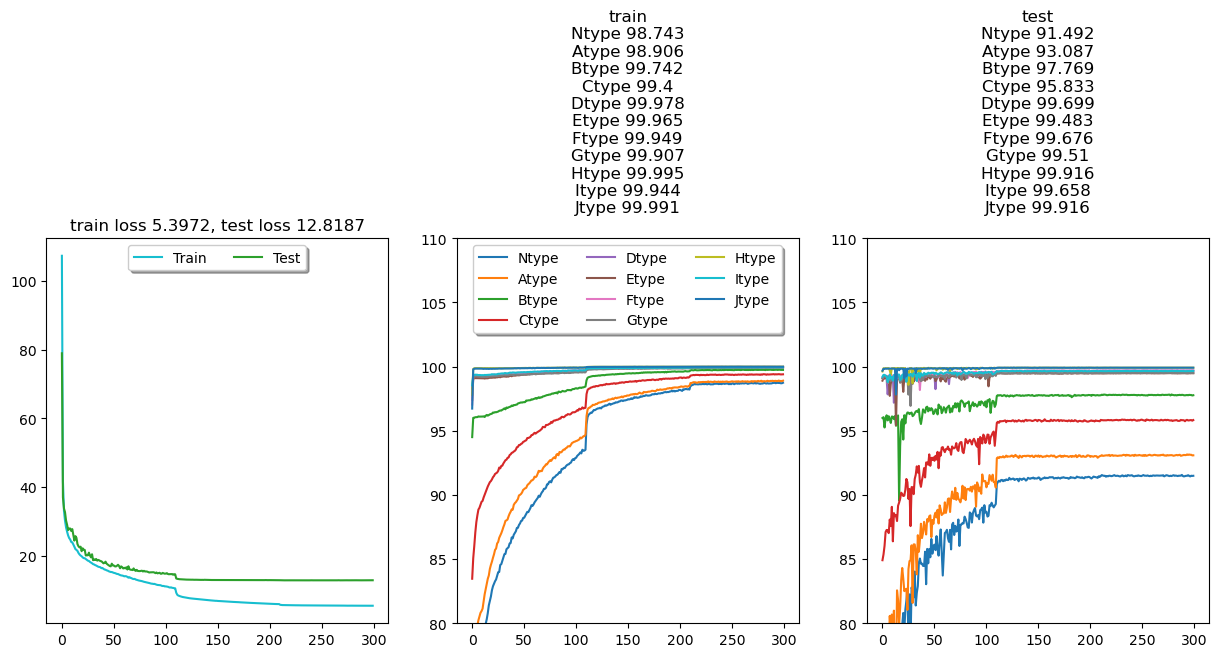

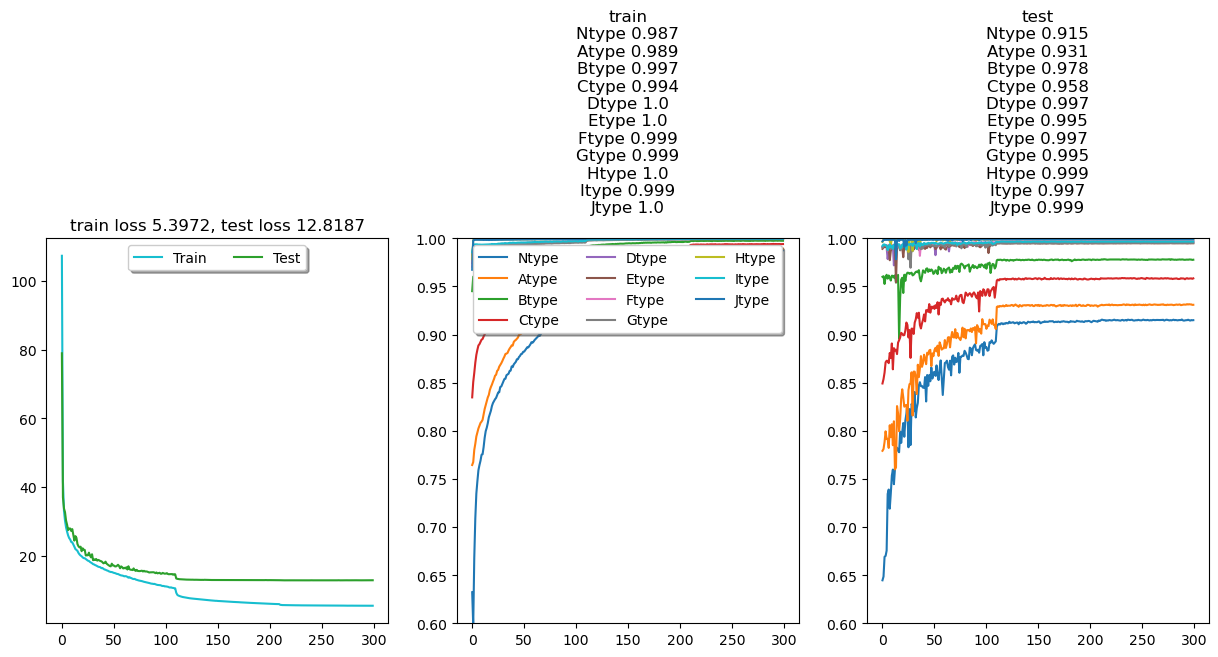

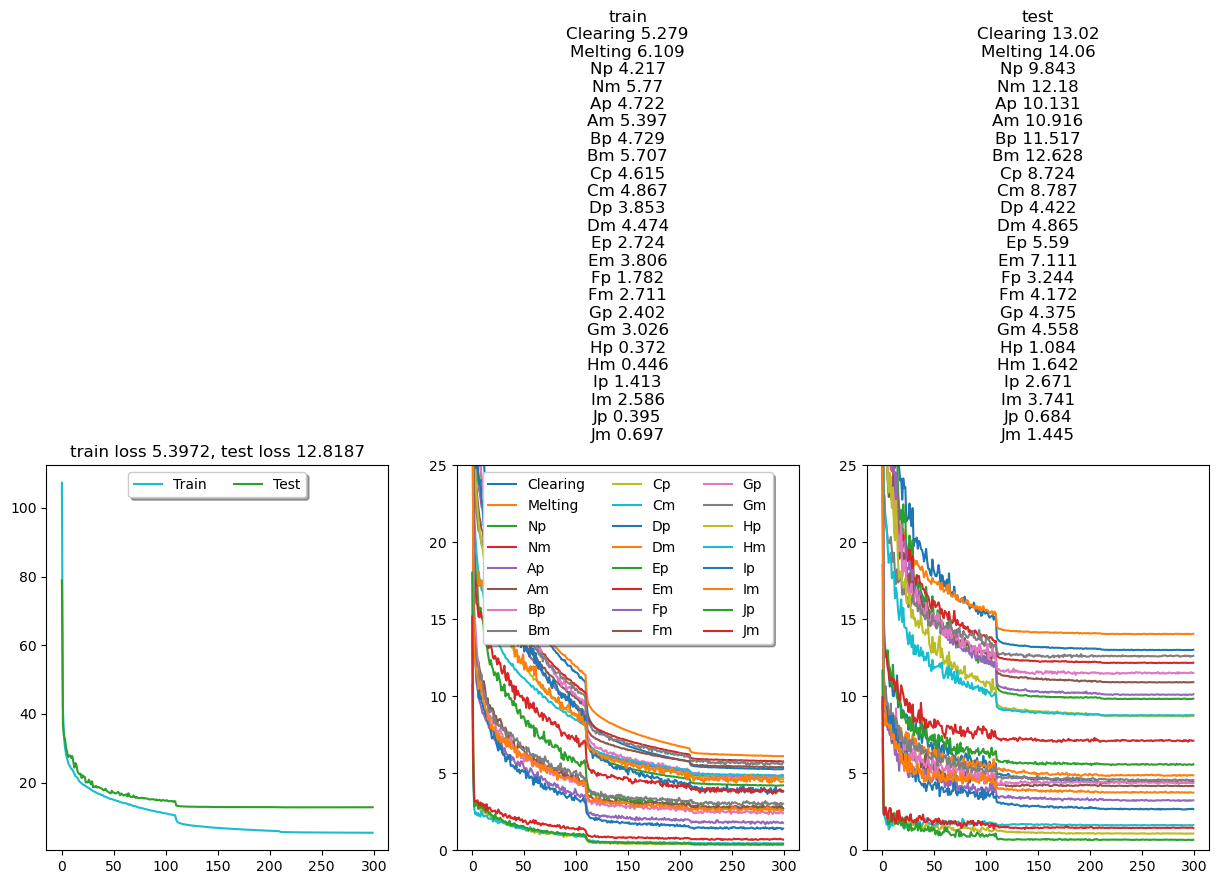

In [18]:
plot_losses(train_loss_hist,test_loss_hist,train_acc_hist,test_acc_hist, ylim=(80,110))
plot_losses(train_loss_hist,test_loss_hist,train_f1_hist,test_f1_hist, ylim=(0.6,1.0))
plot_losses(train_loss_hist,test_loss_hist,train_MAE_hist,test_MAE_hist, ylim=(0,25))


In [19]:
summary_csv = print_results(results_df,phase_targets, display="less")
summary_csv.to_csv(os.path.join(outdir,f'summary_{conv_type}_phase_temp.csv'))
summary_csv


Number of SMILES: 43889

prediction target Ntype (3 classes)
Accuracy:  0.91492
Cohen's kappa:  0.8439121162306804
Matthew's coeff:  0.8439199314420015
Positives: 20662
AUC:  0.9710992224031144

prediction target Ntype (2 classes)
Accuracy:  0.91777
F1:  0.91284
Cohen's kappa:  0.8350126005441598
Matthew's coeff:  0.835018611612951

prediction target Atype (2 classes)
Accuracy:  0.93087
Cohen's kappa:  0.7952386855899328
Matthew's coeff:  0.7953013483306115
Positives: 9531
AUC:  0.9672596566011544
F1:  0.83927

prediction target Btype (2 classes)
Accuracy:  0.97769
Cohen's kappa:  0.690952944616313
Matthew's coeff:  0.6915265619775609
Positives: 1710
AUC:  0.966440631954401
F1:  0.70252

prediction target Ctype (3 classes)
Accuracy:  0.95833
Cohen's kappa:  0.8397346648455701
Matthew's coeff:  0.8397478025261167
Positives: 6444
AUC:  0.9827907974940941

prediction target Ctype (2 classes)
Accuracy:  0.96102
F1:  0.8668
Cohen's kappa:  0.8439629871219398
Matthew's coeff:  0.843969476313

npos      acc       f1       AUC    Tp_mean     Tp_std    Tm_mean  \
type                                                                       
N     20662  0.91777  0.91284  0.971099   9.827785  14.250413  12.224859   
A      9531  0.93087  0.83927  0.967260  10.054100  14.831766  10.855427   
B      1710  0.97769  0.70252  0.966441  12.928721  15.712606  13.783216   
C      6444  0.96102  0.86680  0.982791   8.957627  12.214887   9.207978   
D       341  0.99699  0.80060  0.986766  16.715780  21.029339  18.545053   
E       392  0.99485  0.69126  0.966892  10.347319  12.487238  14.148808   
F       307  0.99676  0.75347  0.975245   6.912954  10.461143   9.612910   
G       328  0.99510  0.65378  0.970131   8.979817  11.223660   9.464702   
H        52  0.99916  0.61856  0.929198  11.022535  11.235402  15.890558   
I       274  0.99661  0.72661  0.979052   6.784794  16.074373  10.312812   
J        67  0.99916  0.71318  0.995335   5.584239   6.869953  11.267382   

         Tm_std  
type             
N     13.837564  
A     13.407047  
B     15.377592  
C     11.180361  
D     21.535686  
E     15.843696  
F     11.664474  
G      9.822099  
H     12.123012  
I     18.108582  
J     12.228844

In [ ]:
# temperature error statistics
ks = []
for k in temp_targets:
    ks.extend([f"error_{k}"])
#results_df[ks].to_csv(os.path.join(outdir,'error_GNN_temperature.csv'))
results_df[ks].describe()


error_Clearing  error_Melting      error_Np      error_Nm     error_Ap  \
count    43886.000000   43887.000000  20662.000000  20662.000000  9531.000000   
mean        10.621435      12.832171      7.388669     11.048438     8.395593   
std         15.263071      14.895403     11.440285     12.523917    12.281552   
min          0.000023       0.000793      0.000031      0.001389     0.000854   
25%          2.078949       3.590446      1.568775      3.115299     1.695328   
50%          5.376530       8.402229      3.792553      7.357407     4.299629   
75%         13.017469      16.730808      8.668983     14.581429     9.946690   
max        337.499756     308.562683    330.322479    311.521423   296.278625   

          error_Am     error_Bp     error_Bm     error_Cp     error_Cm  \
count  9531.000000  1710.000000  1710.000000  6444.000000  6444.000000   
mean     10.111967    10.722628    13.325513     7.995680     8.773100   
std      12.273414    12.779169    15.315522    11.007058    10.651996   
min       0.001770     0.000946     0.002842     0.000137     0.000782   
25%       2.722496     2.742207     3.501148     1.841581     2.445353   
50%       6.312420     6.414925     8.469999     4.438141     5.498039   
75%      13.040367    14.160298    17.487371     9.868525    11.328468   
max     256.860046   130.238907   166.007233   250.563080   257.979492   

         error_Dp    error_Dm    error_Ep    error_Em    error_Fp    error_Fm  \
count  341.000000  341.000000  392.000000  392.000000  307.000000  307.000000   
mean    15.651115   17.550411   10.109549   14.087395    6.200850    9.111895   
std     19.060852   19.985455   12.959334   15.012553    8.644573   11.469691   
min      0.096695    0.080544    0.000839    0.002800    0.027267    0.005386   
25%      3.381638    4.566757    2.514366    4.561569    1.153927    1.662159   
50%      9.370766   12.229507    6.130993    9.718880    2.866600    5.106712   
75%     20.572403   21.883865   13.269658   18.462746    7.853367   11.007925   
max    163.093063  171.991638  131.337280   89.241776   57.561432   69.024445   

         error_Gp    error_Gm    error_Hp   error_Hm    error_Ip    error_Im  \
count  328.000000  328.000000   52.000000  52.000000  274.000000  274.000000   
mean     8.542749   10.090222   13.109982  14.037842    6.134303   10.118507   
std     11.901827   10.921456   18.969456  13.850165   16.290634   18.049799   
min      0.030594    0.006248    0.232788   0.504822    0.085991    0.019547   
25%      2.174829    2.806118    3.404730   6.192884    1.361990    2.513566   
50%      5.386452    6.586293    7.123013  10.941193    3.209398    5.904848   
75%     10.475647   13.721920   16.400175  16.357887    6.700583   13.208868   
max    125.478943   80.359428  108.737274  91.926796  255.169037  257.657104   

        error_Jp   error_Jm  
count  67.000000  67.000000  
mean    6.436364  11.500400  
std     6.874889  15.221550  
min     0.274681   0.152481  
25%     1.700794   2.818691  
50%     3.856239   6.089890  
75%     8.699902  13.849960  
max    32.525841  77.461807

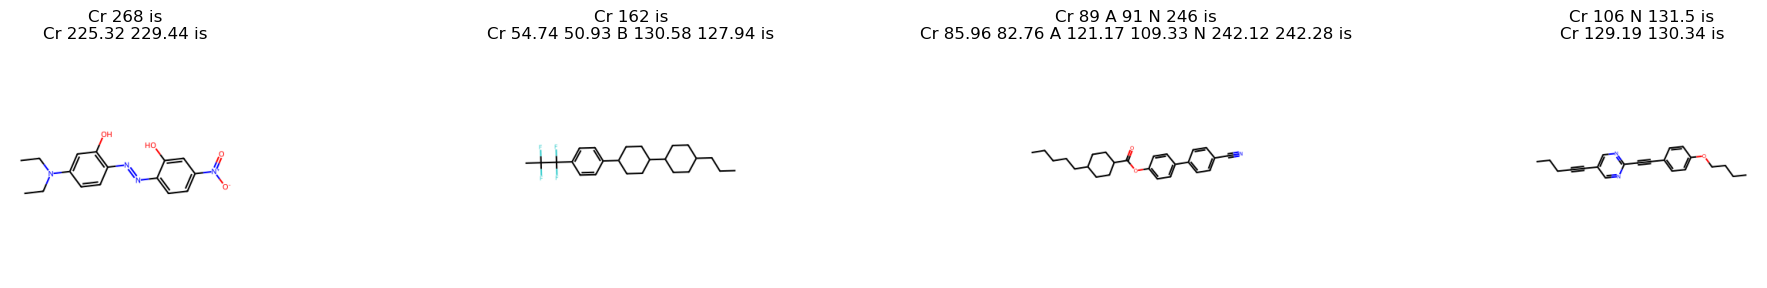

In [ ]:
from rdkit.Chem import Draw
k = 4
ind = np.random.randint(0,len(results_df),k)
fig,axs = plt.subplots(1,k,figsize=(25,3))
for j,i in enumerate(ind):
    #results_df[['SMILES','Phases','pred_Phases']].iloc[ind]
    smi = results_df['SMILES'].iloc[i]
    mol = Chem.MolFromSmiles(smi)
    img = Draw.MolToImage(mol)
    axs[j].imshow(img)
    axs[j].axis('off')
    axs[j].set_title(f"{results_df['Phases'].iloc[i]}\n{results_df['pred_Phases'].iloc[i]}")


### prediction with new dataset

In [ ]:
## inference with the trained model
new_df = pd.DataFrame({'SMILES':['CCC1(C2=CC=C(OCCCCCCCC)C=C2)CCC(C3=CC=C(OC(C4=CC=C(C#N)C=C4)=O)C=C3)(C)N1[O]','O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O','CC1(C2=CC=C(OCCCCCCCC)C=C2)CCC(C3=CC=C(OC(C4=CC=C(OC(F)(F)F)C=C4)=O)C=C3)(C)N1[O]']})
dummy_temp = np.zeros((len(new_df),len(temp_targets)))
dummy_phase = np.zeros((len(new_df),len(phase_targets)))
new_df[phase_targets]=dummy_phase
new_df[temp_targets]=dummy_temp

new_dataset = LCDataset(new_df['SMILES'],y_long=new_df[phase_targets],y_float=new_df[temp_targets],device=device, onehot_atom=onehot_atom, explicitH=explicitH)
predict_loader = DataLoader(new_dataset, batch_size=batchsize)
res = predict(predict_loader,mode='both',targets=phase_targets+temp_targets,output_channel_masks=dataset.output_channel_masks)
res=pd.DataFrame(res)
res.insert(loc = 0, column= 'pred_Phases', value=pred_phases(res))
drop_dummy_truth = [k for k in res.keys() if 'true' in k or 'error' in k]
res=res.drop(columns=drop_dummy_truth)
res.insert(loc = 0, column= 'SMILES', value=new_df['SMILES'])
res


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

SMILES  \
0  CCC1(C2=CC=C(OCCCCCCCC)C=C2)CCC(C3=CC=C(OC(C4=...   
1                O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O   
2  CC1(C2=CC=C(OCCCCCCCC)C=C2)CCC(C3=CC=C(OC(C4=C...   

                       pred_Phases  pred_Ntype  conf_Ntype  pred_Atype  \
0               Cr 101.08 94.91 is           0    0.979793           0   
1  Cr 69.53 62.29 N 75.68 73.63 is           1    0.808179           0   
2                Cr 95.43 96.67 is           0    0.997721           0   

   conf_Atype  pred_Btype  conf_Btype  pred_Ctype  conf_Ctype  pred_Dtype  \
0    0.999740           0    0.999978           0    0.996460           0   
1    0.999902           0    1.000000           0    0.999997           0   
2    0.781948           0    0.996436           0    0.999793           0   

   conf_Dtype  pred_Etype  conf_Etype  pred_Ftype  conf_Ftype  pred_Gtype  \
0    1.000000           0    1.000000           0         1.0           0   
1    1.000000           0    1.000000           0         1.0           0   
2    0.999993           0    0.999994           0         1.0           0   

   conf_Gtype  pred_Htype  conf_Htype  pred_Itype  conf_Itype  pred_Jtype  \
0         1.0           0         1.0           0         1.0           0   
1         1.0           0         1.0           0         1.0           0   
2         1.0           0         1.0           0         1.0           0   

   conf_Jtype  pred_Clearing  pred_Melting     pred_Np     pred_Nm  \
0         1.0      94.909088    101.077049   99.198822  100.057838   
1         1.0      73.625061     69.533630   75.679100   62.285393   
2         1.0      96.671486     95.433121  101.569511  113.278717   

      pred_Ap     pred_Am     pred_Bp    pred_Bm    pred_Cp    pred_Cm  \
0   97.073540  100.465714  104.447098  98.453995  98.982353  87.673759   
1  101.216301   51.539677   64.704811  30.664261  63.907032  42.255051   
2   97.631783  100.211662  103.670448  96.917854  99.567444  85.338394   

      pred_Dp    pred_Dm     pred_Ep    pred_Em    pred_Fp    pred_Fm  \
0  106.602341  96.496033  107.699951  87.294594  79.699753  64.751358   
1   85.022758  72.121696   50.038582  36.717697  56.590561  24.825184   
2  103.679802  97.294266   98.945305  98.744125  79.086365  77.291252   

     pred_Gp    pred_Gm     pred_Hp     pred_Hm     pred_Ip    pred_Im  \
0  62.175911  68.607300   91.385712  121.902191  102.232162  75.618706   
1   3.577051  38.787617   62.926495   94.122749   47.140793  25.746504   
2  75.186394  70.588890  109.786392  109.520630   98.551132  81.469063   

     pred_Jp    pred_Jm  
0  84.328568  58.133606  
1  37.892399  32.534454  
2  80.729530  75.843018

## transition temperature

### learning

CV 0


  0%|          | 0/500 [00:00<?, ?epoch/s]

epoch 0	train loss: 119.71568,	test loss: 119.03519	test MAE Clearing: 136.28827	test MAE Melting: 100.84418	test MAE Np: 148.51701	time 11.0
epoch 100	train loss: 11.75489,	test loss: 15.75731	test MAE Clearing: 16.08968	test MAE Melting: 16.12051	test MAE Np: 13.70044	time 1088.0
epoch 200	train loss: 8.62911,	test loss: 12.7117	test MAE Clearing: 12.53411	test MAE Melting: 14.36634	test MAE Np: 9.67719	time 2158.0
epoch 400	train loss: 5.40771,	test loss: 11.70685	test MAE Clearing: 11.41511	test MAE Melting: 13.65339	test MAE Np: 8.28163	time 4301.0
epoch 499	train loss: 5.34131,	test loss: 11.7305	test MAE Clearing: 11.41693	test MAE Melting: 13.69184	test MAE Np: 8.25677	time 5363.0
CV 1


  0%|          | 0/500 [00:00<?, ?epoch/s]

epoch 0	train loss: 120.25529,	test loss: 118.20665	test MAE Clearing: 135.34936	test MAE Melting: 100.75791	test MAE Np: 147.45195	time 11.0
epoch 100	train loss: 11.55109,	test loss: 14.04262	test MAE Clearing: 14.14724	test MAE Melting: 15.25103	test MAE Np: 11.32298	time 1085.0
epoch 300	train loss: 5.96203,	test loss: 11.4921	test MAE Clearing: 11.53498	test MAE Melting: 13.45047	test MAE Np: 8.13546	time 3243.0
epoch 400	train loss: 5.29746,	test loss: 11.48031	test MAE Clearing: 11.52047	test MAE Melting: 13.5041	test MAE Np: 8.09824	time 4316.0
epoch 499	train loss: 5.26073,	test loss: 11.49041	test MAE Clearing: 11.53065	test MAE Melting: 13.52137	test MAE Np: 8.10365	time 5377.0
CV 4


  0%|          | 0/500 [00:00<?, ?epoch/s]

epoch 0	train loss: 119.87167,	test loss: 118.48957	test MAE Clearing: 134.65636	test MAE Melting: 100.89994	test MAE Np: 146.84874	time 11.0
epoch 100	train loss: 11.43175,	test loss: 13.60056	test MAE Clearing: 13.56007	test MAE Melting: 15.13182	test MAE Np: 10.32908	time 1080.0
epoch 200	train loss: 8.64481,	test loss: 12.56345	test MAE Clearing: 12.70356	test MAE Melting: 14.16209	test MAE Np: 9.53212	time 2158.0
epoch 300	train loss: 5.94025,	test loss: 11.61692	test MAE Clearing: 11.55453	test MAE Melting: 13.54291	test MAE Np: 8.33356	time 3229.0
epoch 400	train loss: 5.41571,	test loss: 11.53225	test MAE Clearing: 11.46153	test MAE Melting: 13.52092	test MAE Np: 8.193	time 4302.0
epoch 499	train loss: 5.35316,	test loss: 11.55463	test MAE Clearing: 11.49781	test MAE Melting: 13.54236	test MAE Np: 8.23004	time 5367.0


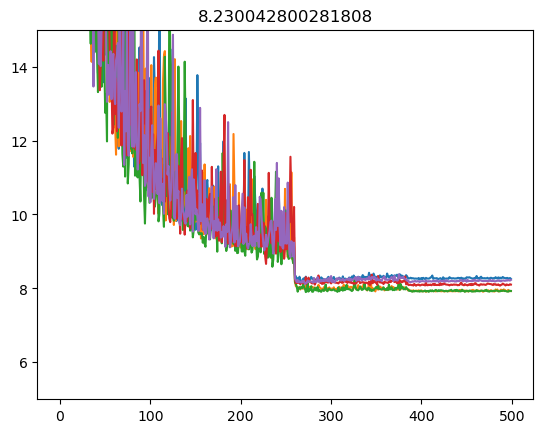

In [ ]:
# model configuration
norm = "BatchNorm"

conv_type="GATv2Conv"
hidden_channel=512 # 128
lr = 1e-3 
num_heads = 4
epochs=300

conv_type="NNConv"
hidden_channel=128
num_heads = 1
lr = 3e-3
epochs=500

dropout=0.5
num_layers=12
batchsize=128*4
warmup_epochs = 10
plot_interval = 100

id_emb_dim = 5 if atom_encoding == 'integer' else 0

results = []
train_loss_hist = []
test_loss_hist = []
train_MAE_hist = []
test_MAE_hist = []
#for cv in range(1):
for cv in range(n_splits):
    print(f'CV {cv}, started at {datetime.now().strftime("%H:%M:%S")}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_MAE_hist.append({k:[] for k in temp_targets})
    test_MAE_hist.append({k:[] for k in temp_targets})

    #model = GraphSAGE(-1, hidden_channels=64,num_layers=num_layers,dropout=dropout, out_channels=output_channels, norm=norm).to(device)
    model= GNN(hidden_channels=64,num_layers=num_layers,out_channels=[len(temp_targets)],dim_node_attr=dataset.dim_node_attr+id_emb_dim,dim_edge_attr=dataset.dim_edge_attr,id_emb_dim=id_emb_dim,num_heads=num_heads,conv_type=conv_type).to(device)

    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=1e-5)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.5*epochs), int(0.75*epochs)], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = DataLoader(dataset[train_indices[cv]], batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(dataset[test_indices[cv]], batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss, train_MAEs = train(train_loader,mode='regression')
            test_loss, test_MAEs = test(test_loader,mode='regression')
            if (epoch % plot_interval == 0) or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)},\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test MAE {temp_targets[k]}: {round(test_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(temp_targets):
                train_MAE_hist[-1][k].append(train_MAEs[j].avg)
                test_MAE_hist[-1][k].append(test_MAEs[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)

    # prediction
    res=predict(test_loader,mode='regression',targets=temp_targets)
    res=pd.DataFrame(res,index=test_indices[cv])
    results.append(res)
    #print(res.describe())
    plt.plot(test_MAE_hist[cv]['Np'])
    plt.ylim(5,15)
    plt.title(test_MAE_hist[cv]['Np'][-1])
    plt.savefig(os.path.join(outdir,f'{conv_type}_{cv}.jpg'))
# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).sort_index()
results_df = pd.concat([results_df,results_df2],axis=1)
colnames = ['ID', 'SMILES', 'Phases']
for s in temp_targets:
    colnames.extend([f'true_{s}',f'pred_{s}',f'error_{s}'])
results_df=results_df[colnames]    
results_df.to_csv(os.path.join(outdir,f'result_{conv_type}_temperature.csv'),index=False)
    

In [ ]:
ks = []
for k in temp_targets:
    ks.extend([f"error_{k}"])
#results_df[ks].to_csv(os.path.join(outdir,'error_GNN_temperature.csv'))
results_df[ks].describe()


error_Clearing  error_Melting      error_Np      error_Nm     error_Ap  \
count    43886.000000   43887.000000  20662.000000  20662.000000  9531.000000   
mean        11.397025      13.434875      8.138757     12.310243     9.883835   
std         16.238094      15.616138     12.175488     13.623022    13.766365   
min          0.000397       0.000114      0.000015      0.000031     0.000130   
25%          2.310896       3.763271      1.795811      3.525249     2.088369   
50%          5.884102       8.669228      4.347206      8.170532     5.223465   
75%         14.007001      17.528870      9.502425     16.431290    12.199669   
max        343.762268     303.374786    329.785126    307.636414   346.851257   

          error_Am     error_Bp     error_Bm     error_Cp     error_Cm  \
count  9531.000000  1710.000000  1710.000000  6444.000000  6444.000000   
mean     11.439542    12.330048    13.993464     9.312027     9.715130   
std      13.579625    14.578809    15.150415    12.071809    11.313726   
min       0.002174     0.007111     0.019569     0.000305     0.000725   
25%       3.088263     3.307646     4.035330     2.300453     2.785776   
50%       7.232811     7.557365     9.557106     5.528381     6.318735   
75%      14.686792    15.764345    18.996351    11.573044    12.685701   
max     303.216095   157.972382   159.416504   299.151245   270.434753   

         error_Dp    error_Dm    error_Ep    error_Em    error_Fp    error_Fm  \
count  341.000000  341.000000  392.000000  392.000000  307.000000  307.000000   
mean    17.921309   18.336960   11.742557   14.273231    8.239248   10.974026   
std     21.630699   22.563498   12.319947   14.423727   10.951151   12.215129   
min      0.037720    0.034134    0.002747    0.013611    0.014771    0.049164   
25%      4.560715    4.279396    3.905441    4.232067    1.781128    2.547722   
50%      9.571594   10.822632    7.919472    9.276676    4.502937    7.280121   
75%     23.433907   23.853111   15.980098   19.125025    9.606205   14.015812   
max    132.834839  158.281906   95.889359   80.252869   75.657692   66.841866   

         error_Gp    error_Gm   error_Hp   error_Hm    error_Ip    error_Im  \
count  328.000000  328.000000  52.000000  52.000000  274.000000  274.000000   
mean     9.844086   11.771960  12.116205  12.911325    8.791416   11.505571   
std     10.681623   12.655092  12.562594  10.970592   19.032019   19.937212   
min      0.017258    0.044476   0.290802   0.749207    0.033104    0.028362   
25%      3.189819    3.271942   3.159546   5.838047    2.005230    2.826967   
50%      6.853956    7.728117   8.901222   9.889174    4.380341    6.851665   
75%     12.685511   15.453612  14.313977  19.135296    9.985039   13.854181   
max    100.452957  108.755936  50.019257  53.351849  272.507935  270.972687   

        error_Jp   error_Jm  
count  67.000000  67.000000  
mean    6.354072  11.306289  
std     6.447413  11.148335  
min     0.082375   0.096481  
25%     1.722309   3.508932  
50%     3.669716   7.618248  
75%     9.398216  14.303200  
max    30.476570  52.449974

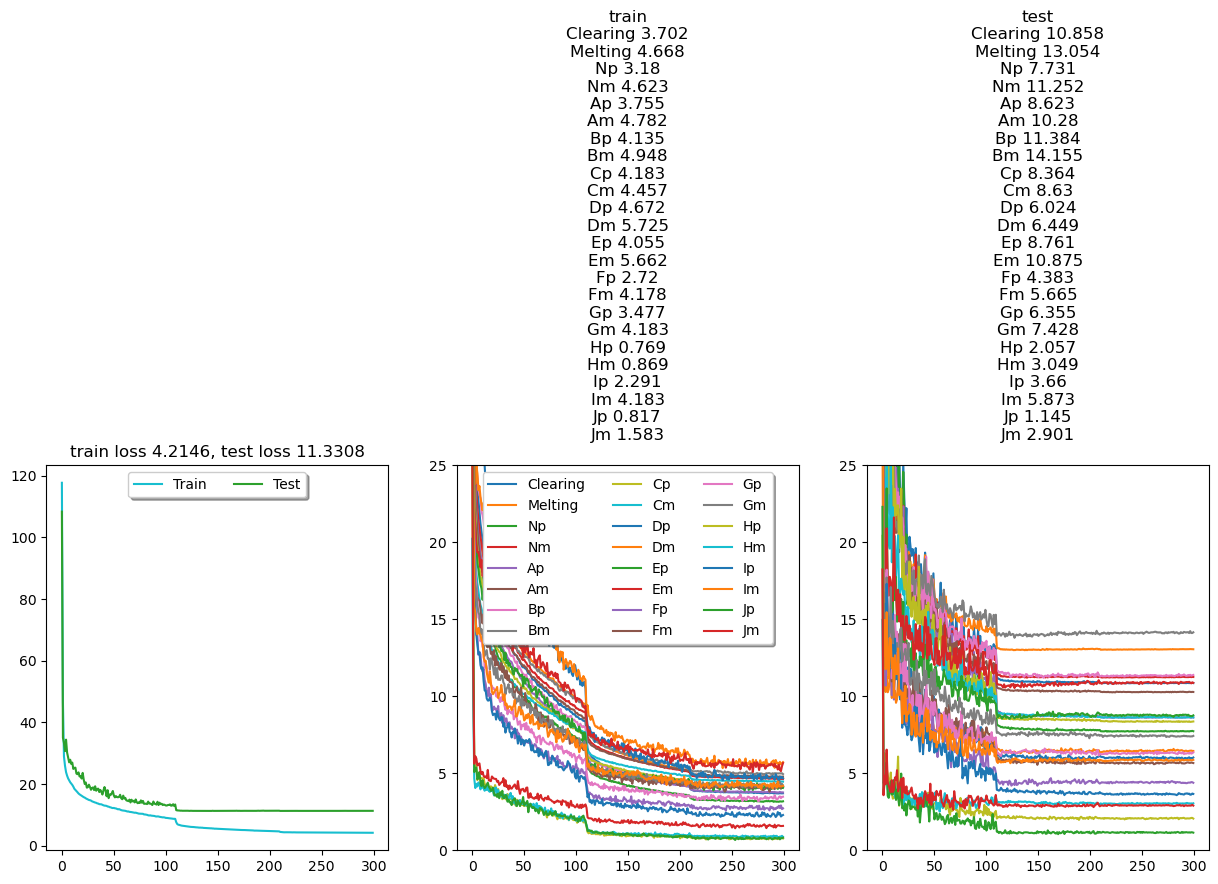

In [ ]:
plot_losses(train_loss_hist,test_loss_hist,train_MAE_hist,test_MAE_hist, ylim=(0,25),title=True)


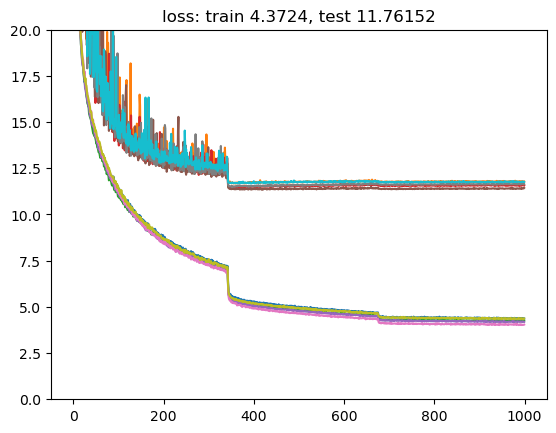

In [ ]:
# CV-wise
for loss_hist,test_hist in zip(train_loss_hist,test_loss_hist):
    plt.plot(loss_hist, label="Train Loss")
    plt.plot(test_hist, label="Test Loss")
#plt.yscale('log')
#plt.legend()
plt.ylim(0,20)
plt.title(f"loss: train {round(loss_hist[-1],5)}, test {round(test_hist[-1],5)}")
plt.show()


## phase existence

### learning

In [ ]:
# setup optimisation configuration
norm = "BatchNorm"
conv_type="GATv2Conv" # "NNConv"
dropout=0.5
num_layers=12
num_heads = 8
hidden_channel=512 # 128
batchsize=256
lr = 1e-3 #5e-3 for NNConv
epochs=100
warmup_epochs = 5
plot_interval = 50

id_emb_dim = 5 if atom_encoding == 'integer' else 0
    
results = []
train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []
train_f1_hist = []
test_f1_hist = []
#for cv in range(1):
for cv in range(n_splits):
    print(f'CV {cv}, started at {datetime.now().strftime("%H:%M:%S")}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_acc_hist.append({k:[] for k in phase_targets})
    test_acc_hist.append({k:[] for k in phase_targets})
    train_f1_hist.append({k:[] for k in phase_targets})
    test_f1_hist.append({k:[] for k in phase_targets})
    
    #model = GraphSAGE(-1, hidden_channels=64,num_layers=num_layers,dropout=dropout, out_channels=output_channels, norm=norm).to(device)
    model= GNN(hidden_channels=hidden_channel,num_layers=num_layers,dim_node_attr=dataset.dim_node_attr+id_emb_dim,dim_edge_attr=dataset.dim_edge_attr, out_channels=dataset.output_channels[:1], id_emb_dim=id_emb_dim,conv_type=conv_type).to(device)
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)#, amsgrad=False)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3, 2*epochs//3], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = DataLoader(dataset[train_indices[cv]], batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(dataset[test_indices[cv]], batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss,train_acc,train_f1 = train(train_loader,mode='classification',output_channel_masks=dataset.output_channel_masks)
            test_loss,test_acc,test_f1 = test(test_loader,mode='classification',output_channel_masks=dataset.output_channel_masks)
            if epoch % plot_interval == 0 or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)}\t"+
                      "\t".join([f'train acc {phase_targets[k]}: {round(train_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test acc {phase_targets[k]}: {round(test_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(phase_targets):
                train_acc_hist[-1][k].append(train_acc[j].avg)
                test_acc_hist[-1][k].append(test_acc[j].avg)
                train_f1_hist[-1][k].append(train_f1[j].avg)
                test_f1_hist[-1][k].append(test_f1[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)
    # prediction
    res=predict(test_loader,mode='classification',targets=phase_targets,output_channel_masks=dataset.output_channel_masks)
    res=pd.DataFrame(res)
    res['index']=test_indices[cv]
    results.append(res)

# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).set_index('index').sort_index()#.rename(columns=colname)
results_df = pd.concat([results_df,results_df2],axis=1)
results_df.to_csv(os.path.join(outdir,f'result_{conv_type}_phase.csv'),index=False)


In [ ]:
plot_losses(train_loss_hist,test_loss_hist,train_acc_hist,test_acc_hist)

In [ ]:
#print_results(results_df,phase_targets,display="all")
print_results(results_df,phase_targets,display="less")

# Combining results of different models

In [ ]:
#model_type = "GNN"
model_type = "LGBM_All"
phase_df = pd.read_csv(os.path.join(outdir,f'result_{model_type}_phase.csv'),index_col='ID').sort_index()
temperature_df = pd.read_csv(os.path.join(outdir,f'result_{model_type}_temperature.csv'),index_col='ID').sort_index()
temperature_df = temperature_df.drop(columns=['Phases','SMILES'])
results_df = pd.concat([phase_df,temperature_df],axis=1).reset_index().rename(columns={'index':'ID'})
results_df.insert(loc = 3, column= 'pred_Phases', value=pred_phases(results_df))
results_df.to_csv(os.path.join(outdir,f'result_{model_type}_combined.csv'),index=False)
results_df

  0%|          | 0/43889 [00:00<?, ?it/s]

ID                                             SMILES  \
0           3                   CCCCCCCCCCCCCCCC(=O)OC1C=CC=CC=1   
1           4                 CCCCCCCCCCCCCCCCCC(=O)OC1C=CC=CC=1   
2           5                  CCCCCCCCCCCCCCCC(=O)OCC1C=CC=CC=1   
3           6                CCCCCCCCCCCCCCCCCC(=O)OCC1C=CC=CC=1   
4           7                        COC(=O)C=CC=CC=CC1C=CC=CC=1   
...       ...                                                ...   
43884  130155                       O=C(C1=CC=CC=C1)CCCCC2CCCCC2   
43885  130180  OC(=O)C3C=C2N=C1C5C(C4C(C1=NC2=CC=3)=CC(OCCCCC...   
43886  130184  O=C(OC)C3C=C2N=C1C5C(C4C(C1=NC2=CC=3)=CC(OCCCC...   
43887  130186  COC(=O)C3=C2N=C1C5C(C4C(C1=NC2=CC=C3)=CC(OCCCC...   
43888  130225  O=C(CCC(=O)NCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC...   

                      Phases                         pred_Phases  true_Ntype  \
0                   Cr 46 is                   Cr 44.39 43.71 is           0   
1                   Cr 52 is                   Cr 49.51 48.03 is           0   
2                   Cr 36 is                   Cr 40.02 40.84 is           0   
3                 Cr 45.5 is                   Cr 46.85 40.43 is           0   
4                  Cr 114 is                  Cr 96.00 112.20 is           0   
...                      ...                                 ...         ...   
43884               Cr 25 is                   Cr 36.35 25.93 is           0   
43885  Cr 47 Dr 154 N 193 is  Cr 95.63 82.10 Dh 114.85 120.65 is           1   
43886         Cr 77 Dh 98 is                  Cr 75.74 143.41 is           0   
43887              Cr 127 is                  Cr 82.22 128.56 is           0   
43888    Cr' 51.8 Cr 73.2 is                  Cr 45.54 105.92 is           0   

       pred_Ntype  conf_Ntype  true_Atype  pred_Atype  conf_Atype  true_Btype  \
0               0    1.000000           0           0    1.000000           0   
1               0    1.000000           0           0    1.000000           0   
2               0    1.000000           0           0    1.000000           0   
3               0    1.000000           0           0    0.999999           0   
4               0    1.000000           0           0    0.999999           0   
...           ...         ...         ...         ...         ...         ...   
43884           0    1.000000           0           0    1.000000           0   
43885           0    0.999994           0           0    0.999995           0   
43886           0    0.698399           0           0    0.999999           0   
43887           0    0.999124           0           0    0.999999           0   
43888           0    0.999959           0           0    0.999992           0   

       pred_Btype  conf_Btype  true_Ctype  pred_Ctype  conf_Ctype  true_Dtype  \
0               0    0.999999           0           0    1.000000           0   
1               0    0.999999           0           0    1.000000           0   
2               0    0.999999           0           0    1.000000           0   
3               0    0.999999           0           0    1.000000           0   
4               0    1.000000           0           0    1.000000           0   
...           ...         ...         ...         ...         ...         ...   
43884           0    1.000000           0           0    1.000000           0   
43885           0    1.000000           0           0    0.999987           0   
43886           0    1.000000           0           0    0.999998           1   
43887           0    1.000000           0           0    1.000000           0   
43888           0    0.999973           0           0    0.999835           0   

       pred_Dtype  conf_Dtype  true_Etype  pred_Etype  conf_Etype  true_Ftype  \
0               0    1.000000           0           0    0.999999           0   
1               0    1.000000           0           0    1.000000           0   
2               0    1.000000           0   

In [ ]:
df_name = "result_GNN_phase_temp.csv"
#df_name =f'result_{model_type}_combined.csv'
results_df = pd.read_csv(os.path.join(outdir,df_name))
print_results(results_df,phase_targets,display="less")


# Compute descriptors from SMILES and parse Phase sequence

In [ ]:
import joblib
class ProgressParallel(joblib.Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return joblib.Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()
        

## Descriptors

In [ ]:
# compute descriptors
#smiles_fn = 'LiqCryst52.csv' # the csv should contain "ID", "SMILES", "Phases" columns
smiles_fn = 'sample.csv' # the csv should contain "ID", "SMILES", "Phases" columns. This sample file is too small! A database with a decent size is required for an actual usage.
csv_fn = 'sample_desc.csv' # save the computed descriptors to this file
parquet_fn = 'sample.parquet' # save the computed descriptors to this file

num_cores = 12

##
df = pd.read_csv(smiles_fn,low_memory=False).sort_values('ID').set_index('ID')
calc = Calculator(descriptors, ignore_3D=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mds = pd.DataFrame(ProgressParallel(n_jobs=num_cores, total=len(df))(joblib.delayed(lambda x:calc(Chem.MolFromSmiles(x)).fill_missing(np.nan).asdict())(smi) for smi in df['SMILES']))
#slist=[Chem.MolFromSmiles(x) for x in df['SMILES']]
#mds=calc.pandas(slist,nproc=num_cores,ipynb=True)
mds['ID']=df.index.values
mds = mds.set_index('ID')

#df = df.loc[:,nonvars]
df = pd.concat([df,mds],axis=1)
df.head(5)


  0%|          | 0/5 [00:00<?, ?it/s]

SMILES              Phases  \
ID                                                                          
0                                         C1C=CC=CC=1             Cr 6 is   
3      CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)C)C3       Cr 64 A 81 is   
4   CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)CCCC...  Cr 37 A 38 N 40 is   
5                CCCCCC1C=CC(=CC=1)C2C=CC(OCCCC)=CC=2  Cr 63 B 81 A 89 is   
6                 O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O       Cr 65 N 72 is   

          ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
ID                                                                      
0    4.242641   4.000000      0      0   8.000000  2.000000  4.000000   
3   19.148902  14.058137      0      0  32.262513  2.501601  4.842936   
4   21.867940  15.050497      0      0  37.953147  2.472014  4.944029   
5   16.223016  12.052430      0      0  28.508519  2.332798  4.665595   
6   15.694249  12.724119      0      0  27.800002  2.305462  4.610924   

       SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A        VR1_A  \
ID                                                                             
0    8.000000  1.333333  2.687624  2.449490  0.408248  0.385054    14.696938   
3   32.262513  1.290501  4.138220  3.806670  0.152267  2.253045  4322.930660   
4   37.953147  1.308729  4.272890  4.063423  0.140118  2.466736  3872.362914   
5   28.508519  1.295842  3.981100  3.881541  0.176434  2.144690   303.753493   
6   27.800002  1.263636  3.952457  3.681050  0.167320  2.091655   381.438810   

         VR2_A     VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  \
ID                                                                          
0     2.449490  2.176814          6          6     12           6       0   
3   172.917226  9.287980         12         12     55          25       0   
4   133.529756  9.326331         12         12     67          29       0   
5    13.806977  6.504674         12         12     50          22       0   
6    17.338128  6.732408          6          6     44          22       0   

    nBridgehead  nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX  \
ID                                                                           
0             0        0   6   0   6   0   0   0   0   0    0    0   0   0   
3             0        1  30   0  24   0   1   0   0   0    0    0   0   0   
4             0        1  38   0  28   0   1   0   0   0    0    0   0   0   
5             0        1  28   0  21   0   1   0   0   0    0    0   0   0   
6             0        6  22   0  16   0   6   0   0   0    0    0   0   0   

    ATS0dv  ATS1dv  ATS2dv  ATS3dv  ATS4dv  ATS5dv  ATS6dv  ATS7dv  ATS8dv  \
ID                                                                           
0     54.0    54.0    54.0    27.0     0.0     0.0     0.0     0.0     0.0   
3    240.0   260.0   350.0   333.0   282.0   225.0   204.0   164.0   147.0   
4    256.0   278.0   374.0   389.0   336.0   284.0   238.0   217.0   190.0   
5    202.0   216.0   272.0   260.0   208.0   188.0   164.0   132.0   104.0   
6    326.0   262.0   358.0   334.0   300.0   276.0   240.0   324.0   164.0   

    ATS0d  ATS1d  ATS2d  ATS3d  ...      GGI7      GGI8      GGI9     GGI10  \
ID                              ...                                           
0    30.0   36.0   48.0   42.0  ...  0.000000  0.000000  0.000000  0.000000   
3   156.0  200.0  330.0  369.0  ...  0.218785  0.207137  0.115008  0.093668   
4   180.0  233.0  382.0  454.0  ...  0.326389  0.221214  0.183750  0.127844   
5   130.0  163.0  255.0  290.0  ...  0.149306  0.131015  0.071250  0.057749   
6   118.0  146.0  210.0  235.0  ...  0.180556  0.139582  0.111250  0.074278   

        JGI1      JGI2      JGI3      JGI4      JGI5      JGI6      JGI7  \
ID                                                                         
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.148148  0.06

## LiqCryst's 'Phases' entry parser

In [ ]:
# phase parser
melting_types = ["Cr","Cr'","Tg"] # Tg: glass
clearing_types = ["is","chg","dec"] # no, un, ex: ambiguous
L=[]

def is_number(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

def is_valid_temp(x, nan=np.nan):
    if x=="?" or "<" in x or ">" in x:
        return(False)
    if not is_number(x):
        return(False)
    x=float(x)
    if x < kelv or x==0:
        return(False)
    else:
        return(True)
    
def is_valid_phase(x):
    if is_number(x):
        return(False)
    if '(' in x:   # this occurs only in the form "(number) Cr"
        return(False)
    if '>' in x or '<' in x: # this occurs only in the form "<number" or "<?"
        return(False)
    if '=0' in x:
        return(False)
    else:
        return(x)

# do some cleaning for Phases
L=[]
p1 = re.compile('isSciDex.*')
p2 = re.compile('\s]\s')
for ph in tqdm(df['Phases'],total=len(df)):
    L.append(p2.sub(' J ',p1.sub('is', ph)))
df['Phases']=L

#
exclude = np.zeros(len(df),dtype=bool)
reentrant = np.zeros(len(df),dtype=bool)
exclude_list = ['X','BS','So','cub','Are','Nre','Nre*','I/F*','Dsq','Dob','Bhx','C~a','C~g','CA','CA*','Tg','tr','Y','S','D']
phtype={sym: np.zeros(len(df),dtype=np.int8) for sym in phase_types+['Clearing','Melting']}
tempL=[sym+"m" for sym in phase_types]+[sym+"p" for sym in phase_types]+['Clearing','Melting']
phtemp={sym: np.full(len(df),np.nan,dtype=np.float32) for sym in tempL}
phase_words = []
for i,ph in enumerate(tqdm(df['Phases'],total=len(df))):
    pL=[]
    # each entry
    phsplit=ph.split()
    #print(phsplit)
    for j,x in enumerate(phsplit):
        for sym in exclude_list:
            if x==sym:
                exclude[i]=True
        if is_valid_phase(x) and not exclude[i]:
            pL.append(x)
        for sym in phase_types:
            search_temp = False
            if sym=="D":
                if "Dh" in x:
                    phtype[sym][i]=1
                    search_temp = True
            else:
                if x==sym:
                    phtype[sym][i]=1
                    search_temp = True
                elif x==sym+"*":
                    phtype[sym][i]=2
                    search_temp = True
            # temperature
            if search_temp:
                if j>0 and is_valid_temp(phsplit[j-1]):
                    phtemp[sym+"m"][i]=float(phsplit[j-1])
                else:
                    phtemp[sym+"m"][i]=np.nan
                    exclude[i]=True
                if j<len(phsplit)-1 and is_valid_temp(phsplit[j+1]):
                    phtemp[sym+"p"][i]=float(phsplit[j+1])
                else:
                    phtemp[sym+"p"][i]=np.nan
                    exclude[i]=True                        
                    
        if x in melting_types:
            phtype['Melting'][i]=2 if x=="Tg" else 1
            if j<len(phsplit)-1 and is_valid_temp(phsplit[j+1]):
                phtemp['Melting'][i]=float(phsplit[j+1])
            else:
                phtemp['Melting'][i]=np.nan
        if x in clearing_types:
            phtype['Clearing'][i]=1 if x=="is" else 2
            if j>0 and is_valid_temp(phsplit[j-1]):
                phtemp['Clearing'][i]=float(phsplit[j-1])
            else:
                phtemp['Clearing'][i]=np.nan
            
    phase_words.extend(pL)
    
    # re-entrant
    for uh in phase_types:
        if (ph.count(f" {uh} ")+ph.count(f" {uh}* ")>1):
            #print(ph) # ,df.iloc[i,:3])
            reentrant[i] = True
    if (ph.count("Dh")>1): # "Dh", "Dho", "Dhd"
        reentrant[i] = True
        #print(ph)
                        
print(f"Mols containing excluded phases {exclude.sum()}, re-entrant phases {reentrant.sum()}")    
pd.DataFrame(phase_words).value_counts()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Mols containing excluded phases 0, re-entrant phases 0


Cr    5
is    5
A     3
N     2
B     1
dtype: int64

In [ ]:
# save cleaned df
try:
    df=df.drop(columns=['exclude','reentrant'])
except:
    pass
df.insert(loc = 2, column= 'exclude', value=exclude)
df.insert(loc = 2, column= 'reentrant', value=reentrant)
for i,sym in enumerate(phase_types):
    try:
        df=df.drop(columns=[f'{sym}type',f'{sym}m',f'{sym}p'])
    except:
        pass
    df.insert(loc = 4+i, column= f'{sym}type', value=phtype[sym])
    df.insert(loc = 5+i, column= f'{sym}m', value=phtemp[f'{sym}m'])
    df.insert(loc = 6+i, column= f'{sym}p', value=phtemp[f'{sym}p'])
for i,sym in enumerate(['Clearing','Melting']):
    try:
        df=df.drop(columns=[f'{sym}type',f'{sym}'])
    except:
        pass
    df.insert(loc = 4+i, column= f'{sym}type', value=phtype[sym])
    df.insert(loc = 5+i, column= f'{sym}', value=phtemp[f'{sym}'])

if csv_fn is not None:
    df.reset_index().to_csv(csv_fn,index=False)
    print(f"the databse file is saved as {csv_fn}.")
if parquet_fn is not None:
    df.to_parquet(parquet_fn, compression="GZIP")
    print(f"the databse file is saved as {parquet_fn}.")
print("Now, the saved database file can be used for model learning: Jump to ``Load dataset from file'' section.")
df

the databse file is saved as sample_desc.csv.
the databse file is saved as sample.parquet.
Now, the saved database file can be used for model learning: Jump to ``Load dataset from file'' section.


SMILES              Phases  \
ID                                                                          
0                                         C1C=CC=CC=1             Cr 6 is   
3      CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)C)C3       Cr 64 A 81 is   
4   CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)CCCC...  Cr 37 A 38 N 40 is   
5                CCCCCC1C=CC(=CC=1)C2C=CC(OCCCC)=CC=2  Cr 63 B 81 A 89 is   
6                 O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O       Cr 65 N 72 is   

    reentrant  exclude  Clearingtype  Meltingtype  Melting  Clearing  Ntype  \
ID                                                                            
0       False    False             1            1      6.0       6.0      0   
3       False    False             1            1     64.0      81.0      0   
4       False    False             1            1     37.0      40.0      1   
5       False    False             1            1     63.0      89.0      0   
6       False    False             1            1     65.0      72.0      1   

    Atype  Btype  Ctype  Dtype  Etype  Ftype  Gtype  Htype  Itype  Jtype  Jm  \
ID                                                                             
0       0      0      0      0      0      0      0      0      0      0 NaN   
3       1      0      0      0      0      0      0      0      0      0 NaN   
4       1      0      0      0      0      0      0      0      0      0 NaN   
5       1      1      0      0      0      0      0      0      0      0 NaN   
6       0      0      0      0      0      0      0      0      0      0 NaN   

    Jp  Im  Ip  Hm  Hp  Gm  Gp  Fm  Fp  Em  Ep  Dm  Dp  Cm  Cp    Bm    Bp  \
ID                                                                           
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN   NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN   NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN   NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  63.0  81.0   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN   NaN   

      Am    Ap    Nm    Np        ABC      ABCGG  nAcid  nBase    SpAbs_A  \
ID                                                                          
0    NaN   NaN   NaN   NaN   4.242641   4.000000      0      0   8.000000   
3   64.0  81.0   NaN   NaN  19.148902  14.058137      0      0  32.262513   
4   37.0  38.0  38.0  40.0  21.867940  15.050497      0      0  37.953147   
5   81.0  89.0   NaN   NaN  16.223016  12.052430      0      0  28.508519   
6    NaN   NaN  65.0  72.0  15.694249  12.724119      0      0  27.800002   

     SpMax_A  SpDiam_A     SpAD_A   SpMAD_A  ...      GGI7      GGI8  \
ID                                           ...                       
0   2.000000  4.000000   8.000000  1.333333  ...  0.000000  0.000000   
3   2.501601  4.842936  32.262513  1.290501  ...  0.218785  0.207137   
4   2.472014  4.944029  37.953147  1.308729  ...  0.326389  0.221214   
5   2.332798  4.665595  28.508519  1.295842  ...  0.149306  0.131015   
6   2.305462  4.610924  27.800002  1.263636  ...  0.180556  0.139582   

        GGI9     GGI10      JGI1      JGI2      JGI3      JGI4      JGI5  \
ID                                                                         
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.115008  0.093668  0.148148  0.061728  0.045525  0.027634  0.027532   
4   0.183750  0.127844  0.129032  0.066667  0.031977  0.037721  0.016865   
5   0.071250  0.057749  0.130435  0.063492  0.017857  0.021852  0.024621   
6   0.111250  0.074278  0.136364  0.085470  0.037037  0.025926  0.025132   

        JGI6      JGI7      JGI8      JGI9     JGI10     JGT10  Diameter  \
ID                                                                         
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000         3   
3   0.019809  0.010418  0.010902  0.007

# (Cells below are not maintained)

## Fitting MLP models

### model

In [ ]:
import torch
import torch.utils.data
from sklearn.preprocessing import StandardScaler

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels=64, num_layers=5, out_channels=[1], dropout=0):
        super(MLP, self).__init__()
        self.dropout = dropout
        
        self.fcs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(num_layers-1):
            fc = torch.nn.LazyLinear(hidden_channels)
            self.fcs.append(fc)
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        # multi-head output, we assume [classification, regression] or [classification] or [regression]
        self.fc1 = torch.nn.ModuleList()
        self.fc2 = torch.nn.ModuleList()
        for i in range(len(out_channels)):
            self.fc1.append(torch.nn.Linear(hidden_channels, hidden_channels))
            self.fc2.append(torch.nn.Linear(hidden_channels, out_channels[i]))

    def forward(self, x):
        for i in range(len(self.fcs)):
            x = F.relu(self.bns[i](self.fcs[i](x)))
        if self.dropout>0:
            x = F.dropout(x, p=self.dropout, training=self.training)
        z = []
        for i in range(len(self.fc1)):
            z.append(F.elu(self.fc1[i](x)))
            if self.dropout>0:
                z[i] = F.dropout(z[i], p=self.dropout, training=self.training)
            z[i] = self.fc2[i](z[i])
        return z

class TabDataset(torch.utils.data.Dataset):
    def __init__(self, X,y,z,device=None):
        ms = StandardScaler()
        X=X.replace([np.inf,-np.inf],np.nan).dropna(axis=1)
        self.varnames = X.keys().tolist()
        self.X = torch.tensor(ms.fit_transform(X), dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).to(device)
        self.z = torch.tensor(z.values, dtype=torch.long).to(device)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return [self.X[idx], self.y[idx], self.z[idx]]



### phase

In [ ]:
norm = "BatchNorm"
dropout=0.5
num_layers=8
hidden_channel=256
batchsize=512
lr = 1e-3
epochs=100
warmup_epochs = 5
plot_interval = 50

use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
varnames = list(desc_names[use_desc])
tabdataset = TabDataset(sub_df[varnames],sub_df[temp_targets],sub_df[phase_targets],device=device)

results = []
train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []
#for cv in range(1):
for cv in range(n_splits):
    print(f'CV {cv}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_acc_hist.append({k:[] for k in phase_targets})
    test_acc_hist.append({k:[] for k in phase_targets})
    
    model = MLP(hidden_channels=hidden_channel,num_layers=num_layers, out_channels=dataset.output_channels[:1]).to(device)
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=1e-4)#, amsgrad=False)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3, 2*epochs//3], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(tabdataset,train_indices[cv]), batch_size=batchsize, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(tabdataset,test_indices[cv]), batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss,train_acc = train(train_loader,mode='classification',output_channel_masks=dataset.output_channel_masks)
            test_loss,test_acc = test(test_loader,mode='classification',output_channel_masks=dataset.output_channel_masks)
            if epoch % plot_interval == 0 or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)}\t"+
                      "\t".join([f'train acc {phase_targets[k]}: {round(train_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test acc {phase_targets[k]}: {round(test_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(phase_targets):
                train_acc_hist[-1][k].append(train_acc[j].avg)
                test_acc_hist[-1][k].append(test_acc[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)
    # prediction
    res=predict(test_loader,mode='classification',targets=phase_targets,output_channel_masks=dataset.output_channel_masks)
    res=pd.DataFrame(res)
    res['index']=test_indices[cv]
    results.append(res)

# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).set_index('index').sort_index()#.rename(columns=colname)
results_df = pd.concat([results_df,results_df2],axis=1)
results_df.to_csv(os.path.join(outdir,f'result_MLP_phase.csv'),index=False)
results_df


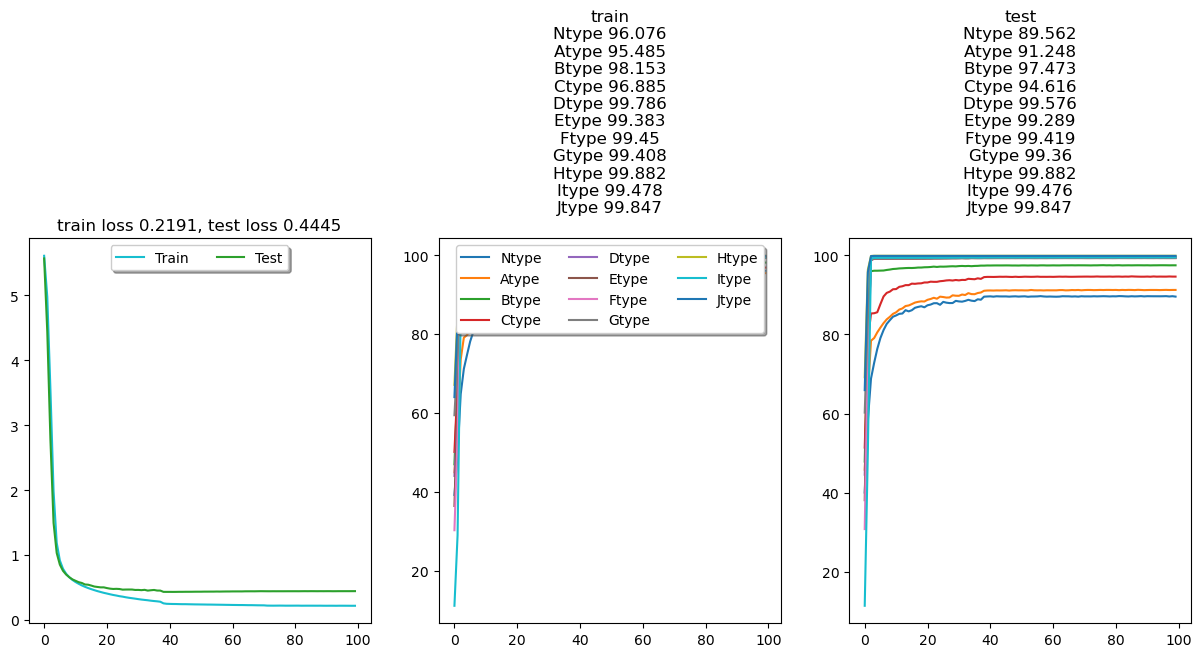

In [ ]:
plot_losses(train_loss_hist,test_loss_hist,train_acc_hist,test_acc_hist)

In [ ]:
print_results(results_df,targets)

Number of SMILES: 43889
All: num of variables: 1615

prediction target Ntype (3 classes)
              precision    recall  f1-score   support

           0    0.90832   0.90007   0.90418     23227
           1    0.89087   0.90459   0.89768     18185
           2    0.81063   0.78805   0.79918      2477

    accuracy                        0.89562     43889
   macro avg    0.86994   0.86424   0.86701     43889
weighted avg    0.89558   0.89562   0.89556     43889

[[20906  1936   385]
 [ 1664 16450    71]
 [  446    79  1952]]
Cohen's kappa:  0.8085005159457656
Matthew's coeff:  0.8085496837475165

prediction target Ntype (2 classes)
              precision    recall  f1-score   support

       False    0.90832   0.90007   0.90418     23227
        True    0.88880   0.89788   0.89332     20662

    accuracy                        0.89904     43889
   macro avg    0.89856   0.89898   0.89875     43889
weighted avg    0.89913   0.89904   0.89907     43889

[[20906  2321]
 [ 2110 18552]]

/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.

              precision    recall  f1-score   support

           0    0.99349   0.99938   0.99642     43497
           1    0.79851   0.30398   0.44033       352
           2    0.00000   0.00000   0.00000        40

    accuracy                        0.99289     43889
   macro avg    0.59733   0.43445   0.47892     43889
weighted avg    0.99102   0.99289   0.99106     43889

[[43470    27     0]
 [  245   107     0]
 [   40     0     0]]
Cohen's kappa:  0.404271432622356
Matthew's coeff:  0.46450109582712573

prediction target Etype (2 classes)
              precision    recall  f1-score   support

       False    0.99349   0.99938   0.99642     43497
        True    0.79851   0.27296   0.40684       392

    accuracy                        0.99289     43889
   macro avg    0.89600   0.63617   0.70163     43889
weighted avg    0.99174   0.99289   0.99116     43889

[[43470    27]
 [  285   107]]
Cohen's kappa:  0.40413248451147266
Matthew's coeff:  0.46442480329422897
AUC:  0.951980

/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.

### joint phase and temperature

In [ ]:
norm = "BatchNorm"
dropout=0.5
num_layers=12
hidden_channel=128
batchsize=256
lr = 5e-3
epochs= 1000
warmup_epochs = 10
plot_interval = 100

use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
varnames = list(desc_names[use_desc])
tabdataset = TabDataset(sub_df[varnames],sub_df[temp_targets],sub_df[phase_targets],device=device)
    
results = []
train_loss_hist = []
test_loss_hist = []
train_MAE_hist = []
test_MAE_hist = []
train_acc_hist = []
test_acc_hist = []
for cv in range(n_splits):
    print(f'CV {cv}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_MAE_hist.append({k:[] for k in temp_targets})
    test_MAE_hist.append({k:[] for k in temp_targets})
    train_acc_hist.append({k:[] for k in phase_targets})
    test_acc_hist.append({k:[] for k in phase_targets})
    
    model = MLP(hidden_channels=hidden_channel,num_layers=num_layers, out_channels=dataset.output_channels).to(device)
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=1e-5)#, amsgrad=False)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3, 2*epochs//3], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(tabdataset,train_indices[cv]), batch_size=batchsize, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(tabdataset,test_indices[cv]), batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss,train_acc,train_MAEs = train(train_loader,mode='both',output_channel_masks=dataset.output_channel_masks)
            test_loss,test_acc,test_MAEs = test(test_loader,mode='both',output_channel_masks=dataset.output_channel_masks)
            if epoch % plot_interval == 0 or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)}\t"+
                      "\t".join([f'train MAE {temp_targets[k]}: {round(train_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      "\t".join([f'\ttrain acc {phase_targets[k]}: {round(train_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test MAE {temp_targets[k]}: {round(test_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      "\t".join([f'\ttest acc {phase_targets[k]}: {round(test_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(temp_targets):
                train_MAE_hist[-1][k].append(train_MAEs[j].avg)
                test_MAE_hist[-1][k].append(test_MAEs[j].avg)
            for j,k in enumerate(phase_targets):
                train_acc_hist[-1][k].append(train_acc[j].avg)
                test_acc_hist[-1][k].append(test_acc[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)
    # prediction
    res=predict(test_loader,mode='both',targets=phase_targets+temp_targets,output_channel_masks=dataset.output_channel_masks)
    res=pd.DataFrame(res)
    res['index']=test_indices[cv]
    results.append(res)

# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).set_index('index').sort_index()
results_df = pd.concat([results_df,results_df2],axis=1)
results_df['pred_Phases']=pred_phases(results_df)
results_df.to_csv(os.path.join(outdir,'result_MLP_phase_temp.csv'),index=False)

CV 0


/home/skaji/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/1000 [00:00<?, ?epoch/s]

epoch 0	train loss: 124.04466	train MAE Clearing: 136.0261	train MAE Melting: 101.75793	train MAE Np: 155.31055	train acc Ntype: 50.44858		train acc Atype: 77.98411		train acc Btype: 84.89647	test loss: 121.7274	test MAE Clearing: 136.17921	test MAE Melting: 102.11017	test MAE Np: 148.38206	test acc Ntype: 61.67692		test acc Atype: 78.29802		test acc Btype: 96.1039	time 5.0


/home/skaji/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 100	train loss: 11.60359	train MAE Clearing: 11.00971	train MAE Melting: 11.00814	train MAE Np: 10.0219	train acc Ntype: 80.00057		train acc Atype: 83.60913		train acc Btype: 96.22056	test loss: 15.32007	test MAE Clearing: 15.0735	test MAE Melting: 15.10933	test MAE Np: 12.82434	test acc Ntype: 78.49168		test acc Atype: 83.25359		test acc Btype: 96.20643	time 455.0
epoch 200	train loss: 9.65891	train MAE Clearing: 9.17316	train MAE Melting: 9.3388	train MAE Np: 8.50386	train acc Ntype: 84.80248		train acc Atype: 87.84427		train acc Btype: 96.57657	test loss: 14.7594	test MAE Clearing: 14.66648	test MAE Melting: 14.8907	test MAE Np: 12.18742	test acc Ntype: 83.17384		test acc Atype: 85.87378		test acc Btype: 96.44566	time 899.0
epoch 300	train loss: 8.64012	train MAE Clearing: 8.11624	train MAE Melting: 8.38534	train MAE Np: 7.64406	train acc Ntype: 86.82179		train acc Atype: 89.66136		train acc Btype: 96.74461	test loss: 14.30603	test MAE Clearing: 14.26238	test MAE Melting: 14.5

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



epoch 100	train loss: 11.43001	train MAE Clearing: 10.85676	train MAE Melting: 10.93445	train MAE Np: 9.74638	train acc Ntype: 80.59353		train acc Atype: 85.05924		train acc Btype: 96.28902	test loss: 15.48477	test MAE Clearing: 15.31575	test MAE Melting: 15.59543	test MAE Np: 13.09158	test acc Ntype: 77.76005		test acc Atype: 84.07201		test acc Btype: 96.1946	time 441.0
epoch 200	train loss: 9.57945	train MAE Clearing: 9.07766	train MAE Melting: 9.21167	train MAE Np: 8.41129	train acc Ntype: 85.22442		train acc Atype: 87.70221		train acc Btype: 96.41718	test loss: 14.53562	test MAE Clearing: 14.73527	test MAE Melting: 14.77555	test MAE Np: 12.58158	test acc Ntype: 83.19471		test acc Atype: 85.99749		test acc Btype: 96.27435	time 860.0
epoch 300	train loss: 8.61242	train MAE Clearing: 8.20539	train MAE Melting: 8.39675	train MAE Np: 7.66578	train acc Ntype: 87.34905		train acc Atype: 89.66165		train acc Btype: 96.83014	test loss: 14.41769	test MAE Clearing: 14.67713	test MAE Melting: 1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



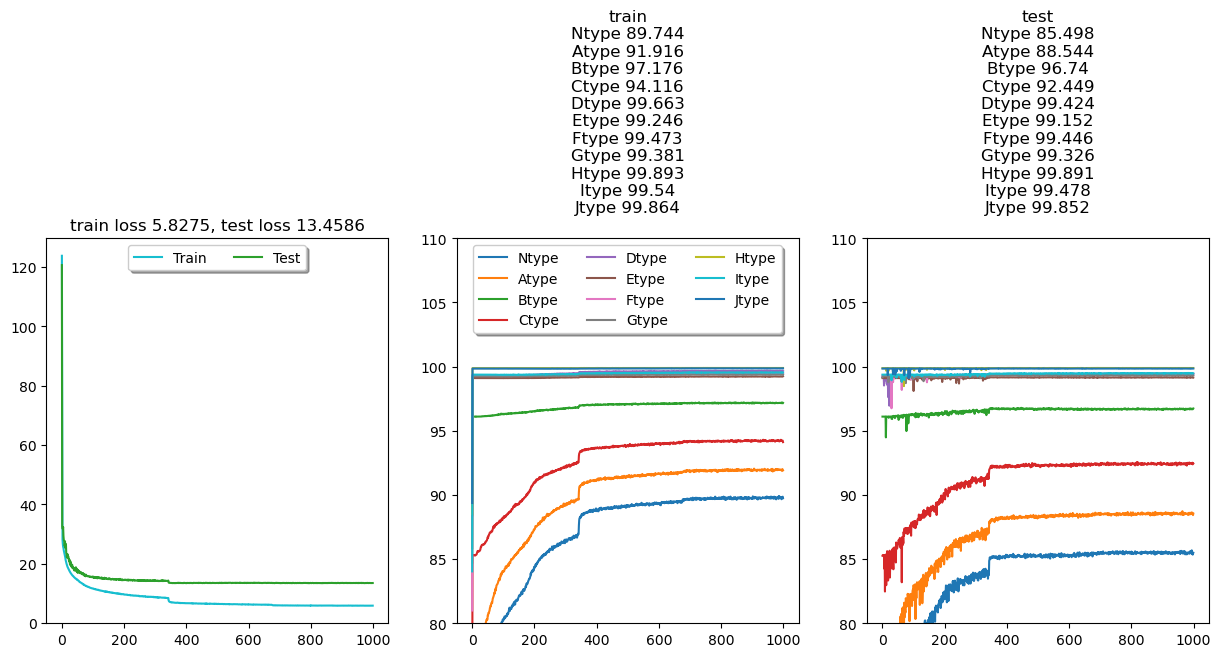

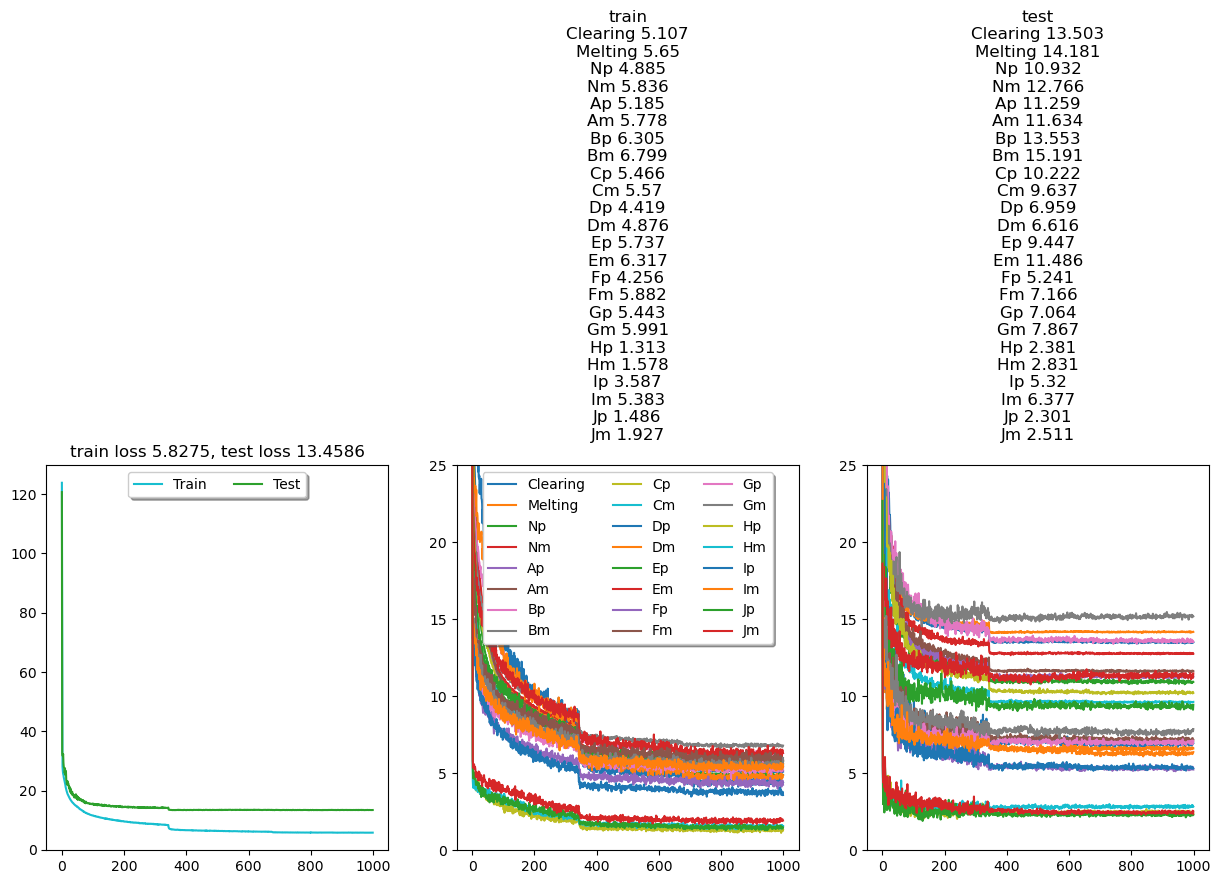

In [ ]:
plot_losses(train_loss_hist,test_loss_hist,train_acc_hist,test_acc_hist, ylim=(80,110))
plot_losses(train_loss_hist,test_loss_hist,train_MAE_hist,test_MAE_hist, ylim=(0,25))

In [ ]:
print_results(results_df,phase_targets)

Number of SMILES: 43889
All: num of variables: 1615

prediction target Ntype (3 classes)
              precision    recall  f1-score   support

           0    0.87259   0.87248   0.87253     23227
           1    0.84652   0.86714   0.85671     18185
           2    0.73147   0.60153   0.66017      2477

    accuracy                        0.85498     43889
   macro avg    0.81686   0.78038   0.79647     43889
weighted avg    0.85382   0.85498   0.85399     43889

[[20265  2569   393]
 [ 2262 15769   154]
 [  697   290  1490]]
Cohen's kappa:  0.7321698134296433
Matthew's coeff:  0.7323236048107897

prediction target Ntype (2 classes)
              precision    recall  f1-score   support

       False    0.87259   0.87248   0.87253     23227
        True    0.85667   0.85679   0.85673     20662

    accuracy                        0.86509     43889
   macro avg    0.86463   0.86463   0.86463     43889
weighted avg    0.86509   0.86509   0.86509     43889

[[20265  2962]
 [ 2959 17703]]

In [ ]:
ks = []
for k in temp_targets:
    ks.extend([f"error_{k}"])
#results_df[ks].to_csv(os.path.join(outdir,'error_GNN_temperature.csv'))
results_df[ks].describe()

error_Clearing  error_Melting      error_Np      error_Nm     error_Ap  \
count    43886.000000   43887.000000  20662.000000  20662.000000  9531.000000   
mean        13.502786      14.181354     10.983251     12.921862    11.378296   
std         16.973816      15.895142     14.175811     14.374227    14.832272   
min          0.000137       0.000031      0.000648      0.000565     0.002228   
25%          3.078630       3.947529      2.659300      3.676385     2.440414   
50%          7.672073       9.239761      6.405312      8.544004     6.120148   
75%         17.512383      18.854969     13.716980     17.119316    14.539036   
max        329.135651     309.162598    327.861694    302.961151   282.970642   

          error_Am     error_Bp     error_Bm     error_Cp     error_Cm  \
count  9531.000000  1710.000000  1710.000000  6444.000000  6444.000000   
mean     11.842627    13.715529    14.796945    10.433273    10.070134   
std      14.084367    15.337874    15.984586    13.231476    11.997228   
min       0.003143     0.010681     0.004992     0.000183     0.003647   
25%       3.070995     3.533440     4.073771     2.527828     2.804867   
50%       7.254471     8.837051     9.939513     6.080276     6.341179   
75%      15.523251    17.971523    19.941391    13.452253    12.905291   
max     268.354065   191.078979   184.715530   267.287720   249.547974   

         error_Dp    error_Dm    error_Ep    error_Em    error_Fp    error_Fm  \
count  341.000000  341.000000  392.000000  392.000000  307.000000  307.000000   
mean    18.579454   18.289335   12.107491   15.534292    8.419113   11.577724   
std     22.584038   21.473198   13.756028   16.620235   11.034281   12.929491   
min      0.115807    0.035538    0.054596    0.110405    0.018700    0.011940   
25%      4.025681    5.092354    3.088633    4.434528    2.097031    3.393410   
50%     10.500572   12.035866    7.636612   10.333927    4.594986    6.576160   
75%     24.680145   23.206284   15.687183   20.836855   10.017467   14.862295   
max    167.725815  200.230133   91.183922   96.303604   71.858170   68.715286   

         error_Gp    error_Gm   error_Hp   error_Hm    error_Ip    error_Im  \
count  328.000000  328.000000  52.000000  52.000000  274.000000  274.000000   
mean    10.502936   10.816733  11.099741  13.154708    9.164503   11.626381   
std     12.803295   13.609569  10.884594   9.921094   17.230280   17.547026   
min      0.061050    0.022064   0.490776   0.215488    0.015976    0.071884   
25%      2.739630    2.714669   3.545506   5.741795    2.110477    3.321592   
50%      7.079819    6.546638   6.908558  12.087734    4.779327    6.918755   
75%     14.467257   14.740257  14.785959  17.496340   10.379172   14.920820   
max    159.822723  171.589844  45.589127  48.552982  234.348190  231.775787   

        error_Jp   error_Jm  
count  67.000000  67.000000  
mean   10.715888  11.242750  
std    10.605879  10.172484  
min     0.162369   0.086044  
25%     3.306923   3.644852  
50%     6.867752   8.071136  
75%    15.146595  15.908646  
max    43.552162  47.160141

## Py-Boost

In [ ]:
!pip install cupy-cuda11x
!pip install py-boost

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from py_boost import GradientBoosting, SketchBoost
from py_boost.multioutput.sketching import *
from py_boost.multioutput.target_splitter import *


In [ ]:
targets = [lt+"type" for lt in phase_types]
sub_df = df

use_desc = "All" # "Shape" # "Electric" "Flexible"
varnames = desc_names[use_desc]

X=sub_df.loc[:,varnames].values
Y=sub_df.loc[:,targets].values
train_indices, test_indices = cv_split("classification",sub_df,n_splits=n_splits,targets=targets)
print(X.shape, Y.shape)

(43889, 1615) (43889, 11)


In [ ]:
# fitting
models=[]
clf = GradientBoosting # SketchBoost 
for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
    X_train,X_test,y_train,y_test=X[train_index],X[test_index],Y[train_index],Y[test_index]
    model = clf('crossentropy',
                         ntrees=10000, lr=0.03, verbose=10, es=300, lambda_l2=1, gd_steps=1,
                         subsample=1, colsample=1, min_data_in_leaf=20, use_hess=True,
                         max_bin=256, max_depth=10)

    model.fit(X_train, y_train, eval_sets = [{'X': X_test, 'y': y_test}])
    models.append(model)
    break


## CatBoost

In [ ]:
!conda install -c conda-forge catboost

In [ ]:
from catboost.utils import get_gpu_device_count
from catboost import Pool,CatBoost,CatBoostClassifier,CatBoostRegressor
from sklearn.metrics import accuracy_score
print(get_gpu_device_count())


2


### classification

In [ ]:
targets = phase_targets
sub_df = df

## select predictive variables
use_desc = "All" # "Shape" # "Electric" "Flexible"
varnames = desc_names[use_desc]

X=sub_df[varnames]
Y=sub_df[target]
pred = np.zeros_like(sub_df[target])
num_class=len(Y.unique())
print(X.shape, Y.shape)

evals_result = [{} for i in range(n_splits)]
models = []
for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
    X_train,X_test,y_train,y_test=X.iloc[train_index],X.iloc[test_index],Y.iloc[train_index],Y.iloc[test_index]
    clf = CatBoostClassifier(num_boost_round=10000,verbose=200,
                           loss_function='MultiClass',eval_metric='Accuracy',
                           learning_rate=0.03,
                            max_depth=10,
                            random_seed=42,min_data_in_leaf=20,
                            l2_leaf_reg=1,# auto_class_weights=True,
                            #task_type='GPU',
                            thread_count=num_cores
                           )
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_score = clf.predict_proba(X_test)
    #pred = clf.predict(X_test)
    pred[test_index] = np.argmax(y_score,axis=1)
    models.append(clf)

# save results
result_df = sub_df[['ID','SMILES',target]].copy()
result_df['pred_'+target]=pred
result_df['error_'+target]=np.abs(pred-Y)
result_df = result_df.sort_values('ID')
result_df.to_csv(f'result_Cat_{use_desc}_{target}.csv',index=False)
result_df.head()




### regression

In [ ]:
## select predictive variables
use_desc = "All" # "Shape" # "Electric" "Flexible"
varnames = desc_names[use_desc]

lr = 0.05

X=sub_df[varnames]
Y=sub_df[targets]
pred = np.zeros_like(Y)

evals_result = [{} for i in range(n_splits)]
models = []
for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
    X_train,X_test,y_train,y_test=X.iloc[train_index],X.iloc[test_index],Y.iloc[train_index],Y.iloc[test_index]
    clf = CatBoostRegressor(num_boost_round=20000,verbose=5000,
                             loss_function='MultiRMSE',
                            learning_rate=lr,
                            max_depth=10, # max_leavs=2**6,
                            random_seed=42,
                            l2_leaf_reg=1,                    
                            #task_type='GPU',
                            thread_count=num_cores
                           )
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_score = clf.predict(X_test)
    pred[test_index] = y_score
    print(np.abs(y_test-y_score).mean(axis=0))
    models.append(clf)

# save results
result_df = sub_df[['ID','SMILES','Phases',target]].copy()
result_df['pred_'+target]=pred
result_df['error_'+target]=np.abs(pred-Y)
result_df = result_df.sort_values('ID')
result_df.to_csv(f'result_Cat_{use_desc}_{target}.csv',index=False)
result_df.head()


In [ ]:
num = 10
#feature_importance = model.get_feature_importance()
sorted_feature_importance = model.feature_importances_.argsort()[:10]
plt.barh(varnames[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = varnames[sorted_feature_importance])

# Misc

## molecule graph as networkx

In [ ]:
## molecule graph as networkx
import networkx as nx
from collections import defaultdict

def mol_to_nx(mol):
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G

def plot_nx(G):
    colour_map = defaultdict(lambda x:'gray')
    colour_map['C']='cyan'
    colour_map['O']='orange'
    colour_map['N']='magenta'
    nx.draw_spring(G,
            labels=nx.get_node_attributes(G, 'atom_symbol'),
            with_labels = True,
            node_color=[colour_map[G.nodes[idx]['atom_symbol']] for idx in G.nodes()],
            node_size=500)

    plt.show()
        
G = mol_to_nx(mol)
plot_nx(G)

## Process management

In [ ]:
# terminate child processes
from multiprocessing import active_children
active = active_children()
for child in active:
#    child.terminate()
    child.kill()
    

## Plot statistics

In [ ]:
import seaborn as sns; 
sns.set()

df = pd.read_csv("size_dependence.csv", index_col=0)
df.describe()

#%%
df
#%%
target = "D"
x = df.index
x.name = "training data size"
tags = [target + pm for pm in ['p','m']]
#tags = [target + pm for pm in ['p_r','m_r']]
tagss = [target + pm for pm in ['+','-']]
for tag in tags:
    medians = df['q2_{}'.format(tag)]
    medians.name = 'K'
    quartiles1 = df['q1_{}'.format(tag)]
    quartiles1.name = '25%'
    quartiles3 = df['q3_{}'.format(tag)]
    quartiles3.name = '75%'
    ax = sns.lineplot(x, medians) 
    ax.fill_between(x, quartiles1, quartiles3, alpha=0.3)
ax.legend(tagss)
fig = ax.get_figure()
fig.savefig(target+"_size_dependence.png")

## df comparison

In [ ]:
# check-up!
for target in temperature_types:
    df.loc[df[target]<kelv,target]=np.nan
    mask = (np.abs(phtemp[target]-df[target])<1) | (np.isnan(phtemp[target]) & np.isnan(df[target]))
    print(target, sum(~mask))
    for (i,sd),k,r,ex in zip(df[~mask].iterrows(),phtemp[target][~mask],reentrant[~mask],exclude[~mask]):
        print(i,sd['Phases'],"\tDF: ",sd[target],"New: ",k, "reentrant: ",r, "exclude: ",ex)

# Setup environment
this is required only once; skip from the second time

In [ ]:
## it is recommended to create a new conda environment

# install standard libraries
!conda install seaborn jupyterlab ipywidgets pyarrow
!pip install iterative-stratification rdkit mordred
#!ipython kernel install --user --name=mordred
!jupyter nbextension enable --py widgetsnbextension

## install LightGBM 
!pip install lightgbm

## install Graph NN (PyG): this requires GPU and CUDA to be properly configured on your machine.
!conda install pytorch torchvision torchaudio torcheval pytorch-cuda=11.8 -c pytorch -c nvidia
!conda install pyg -c pyg


# Load libraries
start here

In [ ]:
# load necessary libraries
import pandas as pd
import os,re,warnings
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time, warnings
from datetime import datetime

from rdkit import Chem
from mordred import Calculator, descriptors

from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score,classification_report,confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from tqdm.auto import tqdm

pd.options.display.max_columns = 100

# splitting for CV
def cv_split(mode,sub_df,n_splits=5,targets=None):
    if mode=="classification":
        skf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    skf.get_n_splits(sub_df['SMILES'],sub_df.loc[:,targets])
    train_indices, test_indices = [],[]
    for (train_i, test_i) in skf.split(sub_df,sub_df.loc[:,targets]):
        train_indices.append(train_i)
        test_indices.append(test_i)
    return(train_indices,test_indices)

# print classification results
def print_results(result_df,targets,use_desc=None,display="all"):
    print(f"Number of SMILES: {len(result_df)}")
    csv_df=[]
    if use_desc is not None:
        print(f"{use_desc}: num of variables: {len(varnames)}")
    for target in targets:
        rdic = {'type':target[0]}
        #mask = ~result_df['true_'+target].isna()
        num_classes=result_df['true_'+target].nunique()
        if num_classes<2:
            continue
        print(f'\nprediction target {target} ({num_classes} classes)')
        if display=="all":
            print(classification_report(result_df['true_'+target],result_df['pred_'+target],digits=5))
            print(confusion_matrix(result_df['true_'+target],result_df['pred_'+target]))
        else:
            print("Accuracy: ",round(metrics.accuracy_score(result_df['true_'+target],result_df['pred_'+target]),5))
        print("Cohen's kappa: ",metrics.cohen_kappa_score(result_df['true_'+target],result_df['pred_'+target]))
        print("Matthew's coeff: ", metrics.matthews_corrcoef(result_df['true_'+target],result_df['pred_'+target]))
        rdic['npos'] = sum(result_df['true_'+target]>0)
        print(f"Positives: {rdic['npos']}")
        rdic['acc'] = round(metrics.accuracy_score(result_df['true_'+target]>0,result_df['pred_'+target]>0),5)
        rdic['f1']=round(metrics.f1_score(result_df['true_'+target]>0,result_df['pred_'+target]>0),5)
        if f'pos_conf_{target}' in result_df.keys():
            auc = roc_auc_score(result_df['true_'+target]>0,result_df['pos_conf_'+target])
            print("AUC: ",auc)
            rdic['AUC']=auc            
        # temperature
        lte = f'error_{target[0]}'
        if lte+'p' in result_df.keys():
            rdic['Tp_mean'] = result_df[lte+'p'].mean()
            rdic['Tp_std'] = result_df[lte+'p'].std()
            rdic['Tm_mean'] = result_df[lte+'m'].mean()
            rdic['Tm_std'] = result_df[lte+'m'].std()
        # two-class
        if num_classes==2:
            val = result_df['conf_'+target].values
            val[result_df['pred_'+target]==0] = 1-val[result_df['pred_'+target]==0]
            #print("AUC: ",roc_auc_score(result_df['true_'+target]>0,val))
            print("F1: ",round(metrics.f1_score(result_df['true_'+target],result_df['pred_'+target]),5))
        else:
            print(f'\nprediction target {target} (2 classes)')
            if display=="all":
                print(classification_report(result_df['true_'+target]>0,result_df['pred_'+target]>0,digits=5))
                print(confusion_matrix(result_df['true_'+target]>0,result_df['pred_'+target]>0))
            else:
                print("Accuracy: ",rdic['acc'])
                print("F1: ",rdic['f1'])
            print("Cohen's kappa: ",metrics.cohen_kappa_score(result_df['true_'+target]>0,result_df['pred_'+target]>0))
            print("Matthew's coeff: ", metrics.matthews_corrcoef(result_df['true_'+target]>0,result_df['pred_'+target]>0))
        csv_df.append(rdic)
    return(pd.DataFrame(csv_df).set_index('type'))

# construct predicted Phase sequences from dataframe
def pred_phases(results_df):
    PHS = []
    for i,sd in tqdm(results_df.iterrows(),total=len(results_df)):
        ph=f"Cr {sd['pred_Melting']:.2f}"
        pts = []
        for t in phase_types:
            if sd[f'pred_{t}type']>0:
                ut = "Dh" if t=="D" else t
                ut = ut if sd[f'pred_{t}type']==1 else ut+"*"
                pts.append((sd[f'pred_{t}m'],ut,sd[f'pred_{t}p']))
        for p in sorted(pts,key=lambda x:x[2]):
            ph += f" {p[0]:.2f} {p[1]} {p[2]:.2f}"
            
        ph += f" {sd['pred_Clearing']:.2f} is"
        PHS.append(ph)
    return(PHS)



In [ ]:
## global settings
# after this cell, jump to the "Compute descriptors from SMILES and parse Phase sequence" section at the first run

num_cores = 32 ## choose an appropriate number depending on your CPU
random_state = 42 # use this seed globally to obtain consistent CV splitting
n_splits=2 ## number of splits in CV

## data files
descriptor_fn = os.path.expanduser("~/ssd/LiqCryst52.parquet") # the csv or parquet file produced by the "Compute descriptors from SMILES and parse Phase sequence" section in this file
descriptor_fn = 'sample_desc.csv' # the csv or parquet file produced by the "Compute descriptors from SMILES and parse Phase sequence" section in this file
outdir = "result_sample" # results will be saved in this directory
remove_duplicate_SMILES = True

os.makedirs(outdir,exist_ok=True)

### global variables
nonvars =[
  "ID","SMILES","Phases","rac_en","Melting","Melting_type",
  "Clearing_type","Clearing",
  "Stype","Xtype","Ytype", ## unclear phases
  "exclude","reentrant","prohibited"
]

min_number_of_NandC = 12 # molecules with the total N and C atoms less than this number will be excluded
kelv = -273.15
permitted_list_of_atoms =  ['H','C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
phase_types = ["N","A","B","C","D","E","F","G","H","I","J"]
temperature_types = ["Clearing","Melting"]
for lt in phase_types:
    temperature_types.extend([lt+"p",lt+"m"])
    nonvars.extend([lt+"m",lt+"p",lt+"type"])


# Load dataset from file

In [ ]:
# load the master data file containing SMILES, transition temperaturs etc
if os.path.isfile(descriptor_fn):
    if descriptor_fn.endswith('.parquet'):
        print("loading from parquet...")
        df = pd.read_parquet(descriptor_fn)
        if 'ID' in df.keys():
            df = df.sort_values('ID').set_index('ID')        
    else:
        print("loading from csvs...")
        df = pd.read_csv(descriptor_fn,low_memory=False).sort_values('ID').set_index('ID')
if 'num_C' in df.keys():
    df = df.drop(columns=['num_H','num_N','num_C'])
f=df.pop('Phases')
df.insert(loc=2,column='Phases',value=f)
print("# entries: ", len(df))

if remove_duplicate_SMILES:
    vc = df['SMILES'].value_counts()
    nonunique = vc[vc>1].keys()
    df = df[~df['SMILES'].isin(nonunique)]
    #df[df['SMILES'].isin(nonunique)].sort_values(['SMILES'])[['ID','SMILES','Phases']].to_csv('nonunique_smiles.csv')
    print("# entries after removing duplicates: ", len(df))


loading from csvs...
# entries:  5
# entries after removing duplicates:  5


In [ ]:
# filtering
if min_number_of_NandC>0:
    df = df[(df['nC']+df['nN']>=min_number_of_NandC)]
    print("# after excluding small molecules: ",len(df))    
if 'exclude' in df.keys():   
    df = df[ ~df['exclude'] ]
    print("# after excluding those with ambiguous phase entries: ",len(df))
if 'prohibited' in df.keys():
    df['prohibited']=df['prohibited'].astype(bool)
    df = df[~df['prohibited']]
    print("# after excluding those containing prohibited atoms: ",len(df))
if 'reentrant' in df.keys():   
    df = df[ ~df['reentrant'] ]
    print("# after excluding reentrant phases: ",len(df))
if 'Clearingtype' in df.keys():   
    df = df[ df['Clearingtype']==1 ]
    print("# after excluding non-standard clearing type: ",len(df))

# Wrong phase?
er = []
for lt in phase_types:
    mask = df[lt+"m"]>df[lt+"p"]
    if sum(mask)>0:
        er.append(df[mask][['SMILES','Phases']])
        print("non-increasing phase transition temperatures: ",lt,sum(mask),"/",sum(df[lt+'type']>0))
    df = df[~mask]
#err_df = pd.concat(er)
#err_df.to_csv('inverted_phases.csv')

# teperature types
for tt in temperature_types:
    df.loc[(df[tt] < kelv) | (df[tt] >= 800) | (df[tt] == 0), tt] = np.nan ## magic number to indicate invalid or non-existent      
# clearing and melting type
#df = df[df['Clearingtype']<2]
#df = df[df['Meltingtype']<2]

for x in ['X','S','no','un','ex']:
    mask = [x not in z for z in df['Phases']]
    print(f"Excluding {len(mask)-sum(mask)} phases containing {x}")
    df=df[mask]
# df = df[ (df['Xtype']==0) & (df['Stype']==0) & (df['Ytype']==0) ] 
#df = df[ ["'" not in z for z in df['Phases']] ] # remove Cr'
#df = df[df[temperature_types].min(axis=1)<df[temperature_types].max(axis=1)] # at least two
df = df[ ["?" not in z for z in df['Phases']] ]
df = df[ [" 0 " not in z for z in df['Phases']] ] # remove 0 temperature
df = df[~np.isnan(df[temperature_types].min(axis=1))] # at least one known temperature
print("# after filtering: ",len(df))

df.head()

# after excluding small molecules:  4
# after excluding those with ambiguous phase entries:  4
# after excluding reentrant phases:  4
# after excluding non-standard clearing type:  4
Excluding 0 phases containing X
Excluding 0 phases containing S
Excluding 0 phases containing no
Excluding 0 phases containing un
Excluding 0 phases containing ex
# after filtering:  4


SMILES  reentrant  \
ID                                                                 
3      CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)C)C3      False   
4   CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)CCCC...      False   
5                CCCCCC1C=CC(=CC=1)C2C=CC(OCCCC)=CC=2      False   
6                 O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O      False   

                Phases  exclude  Clearingtype  Meltingtype  Melting  Clearing  \
ID                                                                              
3        Cr 64 A 81 is    False             1            1     64.0      81.0   
4   Cr 37 A 38 N 40 is    False             1            1     37.0      40.0   
5   Cr 63 B 81 A 89 is    False             1            1     63.0      89.0   
6        Cr 65 N 72 is    False             1            1     65.0      72.0   

    Ntype  Atype  Btype  Ctype  Dtype  Etype  Ftype  Gtype  Htype  Itype  \
ID                                                                         
3       0      1      0      0      0      0      0      0      0      0   
4       1      1      0      0      0      0      0      0      0      0   
5       0      1      1      0      0      0      0      0      0      0   
6       1      0      0      0      0      0      0      0      0      0   

    Jtype  Jm  Jp  Im  Ip  Hm  Hp  Gm  Gp  Fm  Fp  Em  Ep  Dm  Dp  Cm  Cp  \
ID                                                                          
3       0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4       0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
5       0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
6       0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

      Bm    Bp    Am    Ap    Nm    Np        ABC      ABCGG  nAcid  nBase  \
ID                                                                           
3    NaN   NaN  64.0  81.0   NaN   NaN  19.148902  14.058137      0      0   
4    NaN   NaN  37.0  38.0  38.0  40.0  21.867940  15.050497      0      0   
5   63.0  81.0  81.0  89.0   NaN   NaN  16.223016  12.052430      0      0   
6    NaN   NaN   NaN   NaN  65.0  72.0  15.694249  12.724119      0      0   

      SpAbs_A   SpMax_A  SpDiam_A     SpAD_A   SpMAD_A  ...      GGI7  \
ID                                                      ...             
3   32.262513  2.501601  4.842936  32.262513  1.290501  ...  0.218785   
4   37.953147  2.472014  4.944029  37.953147  1.308729  ...  0.326389   
5   28.508519  2.332798  4.665595  28.508519  1.295842  ...  0.149306   
6   27.800002  2.305462  4.610924  27.800002  1.263636  ...  0.180556   

        GGI8      GGI9     GGI10      JGI1      JGI2      JGI3      JGI4  \
ID                                                                         
3   0.207137  0.115008  0.093668  0.148148  0.061728  0.045525  0.027634   
4   0.221214  0.183750  0.127844  0.129032  0.066667  0.031977  0.037721   
5   0.131015  0.071250  0.057749  0.130435  0.063492  0.017857  0.021852   
6   0.139582  0.111250  0.074278  0.136364  0.085470  0.037037  0.025926   

        JGI5      JGI6      JGI7      JGI8      JGI9     JGI10     JGT10  \
ID                                                                         
3   0.027532  0.019809  0.010418  0.010902  0.007188  0.006245  0.365129   
4   0.016865  0.018150  0.011657  0.008508  0.007989  0.006088  0.334653   
5   0.024621  0.018122  0.008783  0.009358  0.005481  0.004812  0.304814   
6   0.025132  0.018286  0.009028  0.008724  0.008558  0.007428  0.361952   

    Diameter  Radius  TopoShapeIndex  PetitjeanIndex        Vabc   VAdjMat  \
ID                                                                           
3         17       9        0.888889        0.470588  355.125742  5.754888   
4         21      11        0.909091        0.476190  424.309683  5.954196   
5         17       9        0.888889        0.470588  318.230704  5.523562   
6         17       

# Fitting GBM models

In [ ]:
# dict of descriptors
desc_df = pd.read_csv("mordred_descriptors.csv")
desc_names = {}
for desc_type in ["Shape","Electric","Flexible"]:
    #rr = desc_df[desc_df['type']==desc_type].name.values
    rr = desc_df[desc_df[desc_type]==1].name.values
    #print(desc_type,rr)
    calc = Calculator([getattr(descriptors,r) for r in rr])
    # name of descriptors sorted by their types
    desc_names[desc_type] = [str(r) for r in calc.descriptors]

#desc_names['Electric'] += ['RPCG', 'RNCG'] # manually added
desc_names['All']=set(df.columns) - set(nonvars)
desc_names['ShapeElectric']=set(desc_names['Shape']+desc_names['Electric'])
desc_names['ShapeFlexible']=set(desc_names['Shape']+desc_names['Flexible'])
desc_names['ElectricFlexible']=set(desc_names['Electric']+desc_names['Flexible'])
desc_names['-Flexible']=set(desc_names['All'])-set(desc_names['Flexible'])
desc_names['-Shape']=set(desc_names['All'])-set(desc_names['Shape'])
desc_names['-Electric']=set(desc_names['All'])-set(desc_names['Electric'])

for k,v in desc_names.items():
    print(k,len(v))

print("non associated desc: ", set(df.columns) - set(nonvars) - set(desc_names["Shape"]) - set(desc_names["Electric"]) - set(desc_names["Flexible"]))

desc_df.head()


Shape 1057
Electric 1148
Flexible 511
All 1615
ShapeElectric 1498
ShapeFlexible 1387
ElectricFlexible 1287
-Flexible 1104
-Shape 558
-Electric 508
non associated desc:  {'VE1_D', 'SpMAD_A', 'SpMax_Dzse', 'SpMAD_Dzm', 'SpDiam_Dzare', 'SpAbs_D', 'VR2_Dzpe', 'LogEE_Dzare', 'VE2_Dzare', 'SpAD_A', 'SpAbs_DzZ', 'VE2_Dt', 'SpAbs_Dzi', 'VR3_Dzp', 'VR2_A', 'SpAbs_Dzpe', 'VE3_Dzp', 'VE2_Dzse', 'DetourIndex', 'VR3_Dzare', 'VR1_Dzpe', 'SpAbs_Dzm', 'VE2_DzZ', 'SpAD_Dzi', 'VE1_Dt', 'VE1_Dzpe', 'SpDiam_D', 'SpDiam_Dzm', 'SpAD_DzZ', 'VE1_Dzare', 'SpAbs_Dt', 'LogEE_Dzp', 'VR1_Dzp', 'SpMAD_Dt', 'VR2_Dzv', 'VE2_Dzpe', 'SM1_Dzv', 'VE1_DzZ', 'VE1_Dzp', 'VR3_Dzm', 'VR3_Dzse', 'VE1_Dzse', 'VE3_Dzpe', 'VE2_Dzp', 'LogEE_A', 'VE1_Dzm', 'LogEE_D', 'SpAD_Dzm', 'SpDiam_Dzpe', 'SpAbs_A', 'SpMax_D', 'LogEE_Dzv', 'SpDiam_A', 'VR2_Dzp', 'SpMax_Dzare', 'VR2_DzZ', 'VR1_Dzse', 'SpDiam_Dzi', 'LogEE_Dzi', 'SpDiam_Dzse', 'VR1_Dzare', 'LogEE_Dzse', 'Clearingtype', 'SpMAD_Dzpe', 'VR3_D', 'SpMax_Dzpe', 'SM1_Dzm', 'VR3_Dt', 'VR

name      type  top20           Ref.  Shape  Electric  Flexible
0         ABCIndex     Shape      0    2018Furtula      1         0         1
1         AcidBase  Electric      0         2019Wu      0         1         0
2  AdjacencyMatrix     Shape      1            NaN      0         0         0
3         Aromatic  Flexible      0     2021Miyake      1         1         1
4        AtomCount     Shape      0  2020Schneider      1         0         0

In [ ]:
import lightgbm as lgb
#from optuna.integration import lightgbm as lgb

print("LightGBM ver. ",lgb.__version__)

from lightgbm.callback import CallbackEnv
from tqdm.auto import tqdm
from typing import Optional
from collections import OrderedDict

def accuracy_gbm(preds, data):
    y_true = data.get_label()
    if len(preds.shape)==1:
        preds = preds.reshape(-1,len(y_true)).T # for backward compatibility of LightGBM
    #print(preds.shape, y_true.shape)
    y_pred = np.argmax(preds, axis=1)
    acc = np.mean(y_true == y_pred)
    # name, result, is_higher_better
    return 'accuracy', acc, True

def MAE(preds, data):
    y_true = data.get_label()
    return 'MAE', np.nanmean(np.abs(y_true - preds)), False

class LgbmProgressBarCallback:
    description: Optional[str]
    pbar: tqdm
    update_interval: int

    def __init__(self, description: Optional[str] = "LGBM", update_interval=10):
        self.description = description
        self.pbar = tqdm()
        self.update_interval=update_interval

    def __call__(self, env: CallbackEnv):
        is_first_iteration: bool = env.iteration == env.begin_iteration
        if is_first_iteration:
            total: int = env.end_iteration - env.begin_iteration
            self.pbar.reset(total=total)
            self.pbar.set_description(self.description, refresh=False)

        if (env.iteration - env.begin_iteration) % self.update_interval == 0:
            if len(env.evaluation_result_list) > 0:
                postfix = OrderedDict(
                    [
                        (f"{entry[0]}:{entry[1]}", str(round(entry[2],5)))
                        for entry in env.evaluation_result_list
                    ]
                )
                self.pbar.set_postfix(ordered_dict=postfix, refresh=False)

        self.pbar.update(1)
        self.pbar.refresh()

def GBM_importance(models,varnames):
    importance = [pd.DataFrame(models[cv].feature_importance(), index=varnames, columns=['importance']) for cv in range(n_splits)]
    importance = pd.concat(importance, axis=1, keys=[f'CV{i}_{target}' for i in range(n_splits)])
    importance[f'{target}_median']=importance.median(axis=1)
    L=[]
    for k,v in importance.iterrows():
        for dt,dns in desc_names.items():
            if k in dns:
                L.append(dt)
                break
    importance['dtype']=L
    return(importance)


LightGBM ver.  3.3.5


## phase existence classification

In [ ]:
# classification: select relevant subset
targets = [lt+"type" for lt in phase_types]
sub_df = df
print(f'Number of SMILES to be analysed: {len(sub_df)}')
train_indices, test_indices = cv_split("classification",sub_df,n_splits=n_splits,targets=targets)


Number of SMILES to be analysed: 4


In [ ]:
## select predictive variables
use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
#use_desc = "-Flexible" # "-Electric" # 
varnames = list(desc_names[use_desc])
standardize = False

epochs = 5 # 10000
classifier = "LGBM" # "MLP", "LGBM"

# explanatory var
X=sub_df[varnames]

## standardise
if standardize:
    X=X.replace([np.inf,-np.inf],np.nan).dropna(axis=1)
    varnames = X.keys().tolist()
    ms = StandardScaler()
    X = ms.fit_transform(X)
    print(f'num vars {X.shape[1]}')
else:
    X=X.values


evals_result = {t: [{} for i in range(n_splits)] for t in targets}
models = {t:[] for t in targets}
result_df = sub_df[['SMILES','Phases']].copy()
for tid,target in enumerate(targets):
    # target var
    Y=sub_df[target]
    num_class=max(len(Y.unique()),2)
    print(target, f'{tid} / {len(targets)}\n', Y.value_counts())
    Y=Y.values
    pred = np.zeros((len(Y),num_class))

    #setting up model parameters
    params={'learning_rate': 0.01, 'boosting_type':'gbdt', # 'gbdt' or 'dart'
            #'objective':'multiclass','metric':'multi_logloss', 
            'objective':'multiclassova',
            'is_unbalance': True,
            'max_depth':10, 'num_leaves': 256, 'num_class': num_class,
            'seed':42,'force_col_wise':True,'min_child_samples':20,
            #'lambda_l1' :1,
            'lambda_l2':0.327,
            'feature_fraction':0.775, 'bagging_fraction' :0.643,  
            'num_threads':num_cores, 'device_type':'cpu', # "gpu" or "cpu"
            'verbosity': -1
           }

    # params from tuning
    #params.update(trial.params)

    #
    for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
        #X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)
        X_train,X_test,y_train,y_test=X[train_index],X[test_index],Y[train_index],Y[test_index]
        print(f'train/val {len(X_train)}/{len(X_test)}')
        #print(y_test.value_counts())
        if classifier=="MLP":
            clf = MLPClassifier(hidden_layer_sizes=(256,128,128,128),activation="relu",random_state=42,verbose=False,max_iter=1000,n_iter_no_change=40).fit(X_train, y_train)
            y_pred=clf.predict_proba(X_test)
        else:
            d_train=lgb.Dataset(X_train, label=y_train)
            d_test=lgb.Dataset(X_test, label=y_test, params={'verbose': -1})    
            clf=lgb.train(params,d_train,num_boost_round=epochs,
                          valid_names=['eval'],valid_sets=[d_test],
                          feval=lambda x,y:accuracy_gbm(x,y),
                          callbacks=[LgbmProgressBarCallback(),lgb.callback.record_evaluation(evals_result[target][i])]
                          )
            y_pred=clf.predict(X_test)

        pred[test_index] = y_pred
        models[target].append(clf)

    # save results
    if classifier=="LGBM":
        importance = GBM_importance(models[target],varnames)
        importance = importance.sort_values(f'{target}_median',ascending=False)
        importance.to_csv(os.path.join(outdir,f'importance_LGBM_{use_desc}_{target}.csv'))

    result_df['true_'+target]=Y
    result_df['pred_'+target]=np.argmax(pred,axis=1)
    result_df['conf_'+target]=np.max(pred,axis=1)
    result_df['pos_conf_'+target]=np.sum(pred[:,1:],axis=1)
result_df.to_csv(os.path.join(outdir,f'result_{classifier}_{use_desc}_phase.csv'))
result_df.head()


Ntype 0 / 11
 0    2
1    2
Name: Ntype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Atype 1 / 11
 1    3
0    1
Name: Atype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Btype 2 / 11
 0    3
1    1
Name: Btype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Ctype 3 / 11
 0    4
Name: Ctype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Dtype 4 / 11
 0    4
Name: Dtype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Etype 5 / 11
 0    4
Name: Etype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Ftype 6 / 11
 0    4
Name: Ftype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Gtype 7 / 11
 0    4
Name: Gtype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Htype 8 / 11
 0    4
Name: Htype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Itype 9 / 11
 0    4
Name: Itype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

Jtype 10 / 11
 0    4
Name: Jtype, dtype: int64
train/val 1/3


0it [00:00, ?it/s]

train/val 3/1


0it [00:00, ?it/s]

SMILES              Phases  \
ID                                                                          
3      CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)C)C3       Cr 64 A 81 is   
4   CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)CCCC...  Cr 37 A 38 N 40 is   
5                CCCCCC1C=CC(=CC=1)C2C=CC(OCCCC)=CC=2  Cr 63 B 81 A 89 is   
6                 O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O       Cr 65 N 72 is   

    true_Ntype  pred_Ntype  conf_Ntype  pos_conf_Ntype  true_Atype  \
ID                                                                   
3            0           1    1.000000        1.000000           1   
4            1           0    0.666667        0.333333           1   
5            0           1    1.000000        1.000000           1   
6            1           1    1.000000        1.000000           0   

    pred_Atype  conf_Atype  pos_conf_Atype  true_Btype  pred_Btype  \
ID                                                                   
3            1    1.000000        1.000000           0           0   
4            1    0.666667        0.666667           0           0   
5            1    1.000000        1.000000           1           0   
6            1    1.000000        1.000000           0           0   

    conf_Btype  pos_conf_Btype  true_Ctype  pred_Ctype  conf_Ctype  \
ID                                                                   
3     1.000000    1.000000e-15           0           0         1.0   
4     0.666667    3.333333e-01           0           0         1.0   
5     1.000000    1.000000e-15           0           0         1.0   
6     1.000000    1.000000e-15           0           0         1.0   

    pos_conf_Ctype  true_Dtype  pred_Dtype  conf_Dtype  pos_conf_Dtype  \
ID                                                                       
3     1.000000e-15           0           0         1.0    1.000000e-15   
4     1.000000e-15           0           0         1.0    1.000000e-15   
5     1.000000e-15           0           0         1.0    1.000000e-15   
6     1.000000e-15           0           0         1.0    1.000000e-15   

    true_Etype  pred_Etype  conf_Etype  pos_conf_Etype  true_Ftype  \
ID                                                                   
3            0           0         1.0    1.000000e-15           0   
4            0           0         1.0    1.000000e-15           0   
5            0           0         1.0    1.000000e-15           0   
6            0           0         1.0    1.000000e-15           0   

    pred_Ftype  conf_Ftype  pos_conf_Ftype  true_Gtype  pred_Gtype  \
ID                                                                   
3            0         1.0    1.000000e-15           0           0   
4            0         1.0    1.000000e-15           0           0   
5            0         1.0    1.000000e-15           0           0   
6            0         1.0    1.000000e-15           0           0   

    conf_Gtype  pos_conf_Gtype  true_Htype  pred_Htype  conf_Htype  \
ID                                                                   
3          1.0    1.000000e-15           0           0         1.0   
4          1.0    1.000000e-15           0           0         1.0   
5          1.0    1.000000e-15           0           0         1.0   
6          1.0    1.000000e-15           0           0         1.0   

    pos_conf_Htype  true_Itype  pred_Itype  conf_Itype  pos_conf_Itype  \
ID                                                                       
3     1.000000e-15           0           0         1.0    1.000000e-15   
4     1.000000e-15           0           0         1.0    1.000000e-15   
5     1.000000e-15           0           0         1.0    1.000000e-15   
6     1.000000e-15           0           0         1.0    1.000000e-15   

    true_Jtype  pred_Jtype  conf_Jtype  pos_conf_Jtype  
ID                                                      
3            0           0         1.0    1.000000e-15

In [ ]:
# results
print_results(result_df,targets,display="less")

Number of SMILES: 4

prediction target Ntype (2 classes)
Accuracy:  0.25
Cohen's kappa:  -0.5
Matthew's coeff:  -0.5773502691896258
Positives: 2
AUC:  0.25
F1:  0.4

prediction target Atype (2 classes)
Accuracy:  0.75
Cohen's kappa:  0.0
Matthew's coeff:  0.0
Positives: 3
AUC:  0.3333333333333333
F1:  0.85714

prediction target Btype (2 classes)
Accuracy:  0.75
Cohen's kappa:  0.0
Matthew's coeff:  0.0
Positives: 1
AUC:  0.33333333333333337
F1:  0.0


npos   acc       f1       AUC
type                               
N        2  0.25  0.40000  0.250000
A        3  0.75  0.85714  0.333333
B        1  0.75  0.00000  0.333333

In [ ]:
# plot loss and accuracy
fig,axs = plt.subplots(len(targets),2,figsize=(8,4*len(targets)))
for tid,target in enumerate(targets):
    for i in range(len(evals_result[target])):
        for _,dic in evals_result[target][i].items():
            for j,(k,v) in enumerate(dic.items()):
                axs[tid,j].plot(v)
    axs[tid,0].set_title(f'loss_{target}')
    axs[tid,1].set_title(f'accuracy_{target}')
    #axs[tid,0].set_ylim([0.2,0.4])
    #axs[tid,1].set_ylim([0.85,0.95])


## transition temperature regression

In [ ]:
use_desc = "All" # "Shape" # "Electric" "Flexible" "All"
epochs = 50000
standardize = False

#
varnames = list(desc_names[use_desc])
print(f"#variables: {len(varnames)}")

#setting up the parameters
params={'learning_rate': 0.01, 'boosting_type':'gbdt',
        'objective':'regression','metric':'l2', # 'l1,l2': multiple
        'seed':42,'force_col_wise':True,
        'min_data':20,
        'max_depth':10, 'num_leaves': 2**5, # keep num_leaves small!
        'lambda_l2':0.327,
        'verbosity': -1, 'verbose_eval': -1, #'early_stopping_rounds':1000,  
        'num_threads':num_cores, 'device_type':'cpu',
        'feature_fraction':0.494, 'bagging_fraction':0.845,'bagging_freq':3
       }

# params from tuning
#params.update(trial.params)

# explanatory var
X=df[varnames]

## standardise
if standardize:
    X=X.replace([np.inf,-np.inf],np.nan).dropna(axis=1)
    varnames = X.keys().tolist()
    ms = StandardScaler()
    X = ms.fit_transform(X)
    print(f'num vars {X.shape[1]}')
else:
    X=X.values

evals_result = {t: [{} for i in range(n_splits)] for t in temperature_types}
models = {t:[] for t in temperature_types}
result_df = df[['SMILES','Phases']].copy()
for tid,target in enumerate(temperature_types):
    print(target, f'{tid} / {len(temperature_types)}')
    # target var
    Y=sub_df[target].values

    pred = np.zeros_like(sub_df[target])
    for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
        #X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)
        X_train,X_test,y_train,y_test=X[train_index],X[test_index],Y[train_index],Y[test_index]
        train_mask, test_mask = ~np.isnan(y_train), ~np.isnan(y_test)
        d_train=lgb.Dataset(X_train[train_mask], label=y_train[train_mask], params={'verbose': -1})
        d_test=lgb.Dataset(X_test[test_mask], label=y_test[test_mask], params={'verbose': -1})    
        clf=lgb.train(params,d_train,num_boost_round=epochs,
                      valid_names=['eval'],valid_sets=[d_test],feval=MAE,
                      callbacks=[LgbmProgressBarCallback(),lgb.callback.record_evaluation(evals_result[target][i])]
                     )
        models[target].append(clf)
        pred[test_index]=clf.predict(X_test)
        #print(metrics.mean_absolute_error(y_test,pred[test_index]))
    # # save results
    importance = GBM_importance(models[target],varnames)
    importance = importance.sort_values(f'{target}_median',ascending=False)
    importance.to_csv(os.path.join(outdir,f'importance_LGBM_{use_desc}_{target}.csv'))
    result_df['true_'+target]=Y
    result_df['pred_'+target]=pred
    result_df['error_'+target]=np.abs(pred-Y)
    # save after every target
    result_df.to_csv(os.path.join(outdir,f'result_LGBM_{use_desc}_temperature.csv'))
#result_df.head()
result_df.describe()

In [ ]:
result_df = pd.read_csv(os.path.join(outdir,f'result_LGBM_{use_desc}_temperature.csv'))
print(f"{use_desc}: num of variables: {len(varnames)}")
result_df[[f"error_{t}" for t in temperature_types]].describe()

All: num of variables: 1615


error_Clearing  error_Melting      error_Np      error_Nm     error_Ap  \
count    43886.000000   43887.000000  20662.000000  20662.000000  9531.000000   
mean        13.048144      13.162309     10.805120     12.900757    11.561144   
std         15.806696      14.389595     13.614035     13.792473    14.621560   
min          0.000122       0.000443      0.000046      0.000095     0.000107   
25%          3.051846       3.894768      2.542309      3.925948     2.542366   
50%          7.697977       8.916222      6.291813      8.835503     6.506470   
75%         17.161242      17.448189     13.776789     17.162893    14.979342   
max        319.530150     296.387000    316.240840    291.984700   312.277300   

          error_Am     error_Bp     error_Bm     error_Cp     error_Cm  \
count  9531.000000  1710.000000  1710.000000  6444.000000  6444.000000   
mean     12.093247    13.672163    14.934776    10.221714     9.736380   
std      13.860456    14.959842    15.327314    12.914435    11.350864   
min       0.000168     0.000000     0.000000     0.000038     0.000019   
25%       3.318516     3.287821     4.499855     2.250568     2.708790   
50%       7.793716     8.652851    10.476052     5.857487     6.234175   
75%      15.936306    18.858856    20.624794    12.919723    13.048714   
max     289.522280   121.121920   157.010760   269.568730   256.955400   

         error_Dp    error_Dm    error_Ep    error_Em    error_Fp    error_Fm  \
count  341.000000  341.000000  392.000000  392.000000  307.000000  307.000000   
mean    17.309729   17.494626   13.297599   15.308383    8.914390   11.490870   
std     18.552012   20.399424   14.633475   15.132386   12.620720   13.899151   
min      0.041847    0.012371    0.008934    0.251625    0.028503    0.088249   
25%      4.666435    4.792381    2.906774    4.882128    1.961050    2.843395   
50%     12.018669   11.099365    8.180168   10.281563    4.492752    6.105312   
75%     22.957573   22.202599   18.925296   21.613256    9.745297   15.325721   
max    130.127410  158.188430  103.359300   87.605804   92.640915   97.263420   

         error_Gp    error_Gm   error_Hp   error_Hm    error_Ip    error_Im  \
count  328.000000  328.000000  52.000000  52.000000  274.000000  274.000000   
mean    11.777105   10.805982  14.093497  18.843781   10.150578   13.015641   
std     12.503132   11.990421  18.008744  16.424430   17.972249   18.102113   
min      0.011879    0.104362   0.148781   0.790024    0.060371    0.025562   
25%      3.116886    2.762730   3.109449   7.319783    2.519815    3.062136   
50%      7.985024    7.046577   6.437302  13.902950    5.115341    8.517109   
75%     15.587370   14.320353  19.249287  23.631319   12.632610   16.293906   
max     81.017800   87.864660  92.230360  70.523180  242.160930  223.557510   

        error_Jp   error_Jm  
count  67.000000  67.000000  
mean   10.395631  14.381316  
std    12.089278  16.761549  
min     0.200813   0.087036  
25%     3.412334   5.023697  
50%     6.096657   8.016182  
75%    13.314201  16.938713  
max    72.703110  99.498760

In [ ]:
# plot results
fig,axs = plt.subplots(len(targets),2,figsize=(8,4*len(targets)))
for tid,target in enumerate(targets):
    for i in range(len(evals_result[target])):
        for _,dic in evals_result[target][i].items():
            for j,(k,v) in enumerate(dic.items()):
                axs[tid,j].plot(v)
    axs[tid,0].set_title('MSE')
    axs[tid,1].set_title('MAE')
    axs[tid,0].set_ylim([200,1000])
    axs[tid,1].set_ylim([10.5,12])


## parameter tuning

In [ ]:
import optuna
import sklearn.metrics
from sklearn.model_selection import train_test_split

def objective(trial):
    data, target = X,Y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        #'learning_rage': 0.02,
        'objective':'regression','metric':'l2', # 'l1,l2': multiple
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_boost_round": 5000,
        'seed':42,'force_col_wise':True,     
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    if mode=='classification':
        param.update({"objective": "binary","metric": "binary_logloss","is_unbalance":True})

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    if mode=='classification':
        pred_labels = np.rint(preds)
        res = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    else:
        res = np.mean(np.abs(valid_y-preds))
    return res

####
use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
varnames = desc_names[use_desc]
np.random.seed(42)
##

mode='regression'
#mode='classification'

if mode=='classification':
    target = "Ntype"
else:
    target = "Np"
    
sub_df = df[ ~df[target].isna() ]
perm = np.random.permutation(len(sub_df))
sub_df = sub_df.iloc[perm[:20000]]
X=sub_df[varnames]
#num_class=len(Y.unique())
optuna.logging.set_verbosity(optuna.logging.WARNING)

if mode=='classification':
    Y=sub_df[target]>0
    study = optuna.create_study(direction="maximize")
else:
    Y=sub_df[target]
    study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000, show_progress_bar=True)

trial = study.best_trial
print("  Value: {}".format(trial.value))
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
trial.params

In [ ]:
import optuna.integration.lightgbm as lgb_op
from sklearn.model_selection import train_test_split
optuna.logging.set_verbosity(optuna.logging.WARNING)

lt = "N"
target = lt+"type"

## select predictive variables
use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
varnames = desc_names[use_desc]

epochs = 1000

##
np.random.seed(42)
sub_df = df[ ~df[target].isna() ]
perm = np.random.permutation(len(sub_df))
sub_df = sub_df.iloc[perm[:1000]]
X=sub_df[varnames]
Y=sub_df[target]>0
#num_class=len(Y.unique())

#setting up the parameters
params={#'learning_rate': 0.03, 
        'boosting_type':'gbdt', # 'gbdt' or 'dart'
        "objective": "binary", "metric": "binary_logloss",
        'is_unbalance': True,
#        'num_class': num_class,
        'seed':42,'force_col_wise':True,'early_stopping_rounds':100,
#        'num_threads':num_cores,
        'verbosity': -1
       }
    
X_train,X_test,y_train,y_test= train_test_split(X, Y, test_size=0.25)
d_train=lgb_op.Dataset(X_train, label=y_train)
d_test=lgb_op.Dataset(X_test, label=y_test, params={'verbose': -1})    
clf=lgb_op.train(params,d_train,num_boost_round=epochs,valid_sets=d_test, show_progress_bar=False)
print(clf.params)
print(clf.best_score)



# Fitting GNN models

## function definition

### model

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import smiles
from torch_geometric.nn import GraphSAGE, NNConv, global_mean_pool, global_max_pool
import torch_geometric.nn
from rdkit import Chem

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels=64, num_layers=5, out_channels=[1,1], dim_node_attr=-1, dim_edge_attr=-1, dropout=0, id_emb_dim=0, num_heads=4, conv_type="GATv2Conv"):
        super(GNN, self).__init__()
        self.dropout = dropout
        self.conv_type = conv_type
        
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(num_layers):
            ndim = dim_node_attr if i==0 else hidden_channels
            dim = dim_node_attr if i==0 else hidden_channels
            if self.conv_type=="NNConv":
                nn1 = nn.Sequential(nn.Linear(dim_edge_attr, hidden_channels), nn.ReLU(),
                                    nn.Linear(hidden_channels, hidden_channels*ndim))
                self.convs.append(NNConv(dim, hidden_channels, nn1, aggr='mean'))
            else:
                heads = 4
                conv = getattr(torch_geometric.nn,self.conv_type)
                self.convs.append(conv(dim, out_channels=hidden_channels//num_heads, edge_dim=dim_edge_attr, heads=num_heads))
                
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        # embedding: ID => vector
        if id_emb_dim>0:
            self.emb = torch.nn.Embedding(num_embeddings=len(permitted_list_of_atoms), embedding_dim=id_emb_dim)
        else:
            self.emb = None
        
        # multi-head output, we assume [classification, regression] or [classification] or [regression]
        self.fc1 = torch.nn.ModuleList()
        self.fc2 = torch.nn.ModuleList()
        for i in range(len(out_channels)):
            self.fc1.append(torch.nn.Linear(2*hidden_channels, 2*hidden_channels))
            self.fc2.append(torch.nn.Linear(2*hidden_channels, out_channels[i]))

    def forward(self, data):
        x = data.x
        if self.emb is not None:
            x = torch.cat([self.emb(data.node_id),x],dim=1)
        for i in range(len(self.convs)):
            x = F.elu(self.bns[i](self.convs[i](x, data.edge_index, data.edge_attr)))
        x = torch.cat([global_mean_pool(x, data.batch), global_max_pool(x, data.batch)], dim=1)
        z = []
        for i in range(len(self.fc1)):
            z.append(F.elu(self.fc1[i](x)))
            if self.dropout>0:
                z[i] = F.dropout(z[i], p=self.dropout, training=self.training)
            z[i] = self.fc2[i](z[i])
        return z
    

In [ ]:
# show results
def plot_losses(train_loss_hist,test_loss_hist,train_metric_hist,test_metric_hist,ylim=None,title=True):
    fig, axs = plt.subplots(1,3,figsize=(15, 5))
    plt.subplots_adjust(wspace=0.2)
    ax = axs[0]
    #ax2 = ax.twinx()
    ax2 = axs[1]
    ax3 = axs[2]
    mean_train_loss = sum([np.array(t) for t in train_loss_hist])/len(train_loss_hist)
    mean_test_loss = sum([np.array(t) for t in test_loss_hist])/len(test_loss_hist)
    ax.set_title(f"train loss {round(mean_train_loss[-1],4)}, test loss {round(mean_test_loss[-1],4)}")

    ax.plot(mean_train_loss, c="tab:cyan", label="Train")
    ax.plot(mean_test_loss, c='tab:green', label="Test")
    #ax.ylim(0,40)
    #plt.yscale('log')

    title2="train\n"
    title3="test\n"
    for i,k in enumerate(train_metric_hist[0].keys()):
        mean_train_acc = np.nanmean([np.array(train_metric_hist[i][k]) for i in range(n_splits)],axis=0)
        mean_test_acc = np.nanmean([np.array(test_metric_hist[i][k]) for i in range(n_splits)],axis=0)
        ax2.plot(mean_train_acc, label=k)
        ax3.plot(mean_test_acc, label=k)
        if title:
            title2 += f"{k} {round(mean_train_acc[-1],3)}\n"
            title3 += f"{k} {round(mean_test_acc[-1],3)}\n"
    ax2.set_title(title2)
    ax3.set_title(title3)
    if ylim is not None:
        ax2.set_ylim(ylim)
        ax3.set_ylim(ylim)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),ncol=3, fancybox=True, shadow=True)
    #plt.legend()
    plt.show()

### dataset

In [ ]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding


def get_atom_features(atom, atom_encoding = 'one-hot',exclude=['n_heavy_neighbors']):
    # define list of permitted atoms
    atom_dict = {k: i for i,k in enumerate(permitted_list_of_atoms)}
 
    # compute atom features
    if atom_encoding == 'one-hot':
        atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    elif atom_encoding == 'integer':
        atom_type_enc = [atom_dict[str(atom.GetSymbol())]]
    else:
        atom_type_enc = []
    
    atom_feature_vector = atom_type_enc     
    if 'n_heavy_neighbors' not in exclude:
        atom_feature_vector += one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    if 'n_valence' not in exclude:
        atom_feature_vector += one_hot_encoding(int(atom.GetTotalValence()), [0, 1, 2, 3, 4, 5,6,"MoreThanSix"]) # this yields better results than degree
    if 'formal_charge' not in exclude:    
         atom_feature_vector += one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    if 'hybridisation_type' not in exclude:
        atom_feature_vector += one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    if 'is_in_a_ring' not in exclude:
        atom_feature_vector += [int(atom.IsInRing())]
    if 'is_aromatic' not in exclude:
        atom_feature_vector += [int(atom.GetIsAromatic())]
    if 'atomic_mass_scaled' not in exclude:
        atom_feature_vector += [float((atom.GetMass() - 10.812)/116.092)]
    if 'vdw_radius_scaled' not in exclude:
        atom_feature_vector += [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    if 'covalent_radius_scaled' not in exclude:
        atom_feature_vector += [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]                                    
    if 'chirality_type' not in exclude:
        atom_feature_vector += one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
    if 'n_hydrogens' not in exclude:
        atom_feature_vector += one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])

    return np.array(atom_feature_vector)

def get_bond_features(bond, exclude=[]):
    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_feature_vector =[]
    if 'bond_type' not in exclude:
        bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    if 'bond_is_conj' not in exclude:
        bond_feature_vector += [int(bond.GetIsConjugated())]
    if 'bond_is_in_ring' not in exclude:
        bond_feature_vector += [int(bond.IsInRing())]
    if 'stereochemistry' not in exclude:
        bond_feature_vector += one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
    return np.array(bond_feature_vector)


class PyGDataset(InMemoryDataset):
    def __init__(self, sub_df, device=None, label_dtype=torch.float):
        super().__init__('.')
        data_list = []
        for idx,sd in tqdm(sub_df.iterrows(),total=len(sub_df)):
            graph = smiles.from_smiles(sd['SMILES'])
            graph.x = graph.x.type(torch.float32)
            graph.y = torch.tensor(sd[target], dtype=label_dtype)
            data_list.append(graph.to(device))
        self.data, self.slices = self.collate(data_list)
    
class LCDataset(InMemoryDataset):
    def __init__(self, smiles_list, y_float=None, y_long=None, device=None, transform = None, atom_encoding = 'one-hot',exclude=[], explicitH=True):
        super().__init__('.', transform)
        data_list = []        
        # dummy data to check the dimension
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        if explicitH:
            unrelated_mol = Chem.AddHs(unrelated_mol)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0), atom_encoding = atom_encoding,exclude=exclude))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1),exclude=exclude))
        print(f'#node features {n_node_features}, #edge features {n_edge_features}')
        # multi-label, multi-class classification
        self.output_channel_masks = []
        self.output_channels=[]
        # [int64,float32]
        if y_long is not None:
            L = y_long.nunique().values
            self.output_channels.append(sum(L))            
            for i in range(len(L)):
                mask = []
                for j in range(len(L)):
                    if i==j:
                        mask.extend([True]*L[j])
                    else:
                        mask.extend([False]*L[j])
                self.output_channel_masks.append(mask)
        if y_float is not None:
            self.output_channels.append(y_float.shape[1])

        # create datalist
        if y_float is None:
            y_float = pd.DataFrame(np.zeros(len(y_long)))
        if y_long is None:
            y_long = pd.DataFrame(np.zeros(len(y_float)))
        # process each smiles
        for (sm, y_val, z_val) in tqdm(zip(smiles_list.values, y_float.values, y_long.values),total=len(y_float)):
            mol = Chem.MolFromSmiles(sm)
            if explicitH:
                mol = Chem.AddHs(mol)
            n_nodes = mol.GetNumAtoms()
            n_edges = 2*mol.GetNumBonds()
            X = np.zeros((n_nodes, n_node_features))
            for atom in mol.GetAtoms():
                X[atom.GetIdx(), :] = get_atom_features(atom, atom_encoding=atom_encoding ,exclude=exclude)
            X = torch.tensor(X, dtype = torch.float)

            # construct edge index array E of shape (2, n_edges)
            (rows, cols) = np.nonzero(Chem.GetAdjacencyMatrix(mol))
            torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
            torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
            E = torch.stack([torch_rows, torch_cols], dim = 0)
            EF = np.zeros((n_edges, n_edge_features))
            for (k, (i,j)) in enumerate(zip(rows, cols)):
                EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)),exclude=exclude)
            EF = torch.tensor(EF, dtype = torch.float)

            # construct label tensor
            y_tensor = torch.tensor(y_val, dtype = torch.float32).unsqueeze(dim=0)
            z_tensor = torch.tensor(z_val, dtype = torch.long).unsqueeze(dim=0)

            # construct Pytorch Geometric data object and append to data list
            if atom_encoding != 'one-hot':
                data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor, z=z_tensor).to(device))
            else:
                data_list.append(Data(x = X[:,1:], node_id=X[:,0].type(torch.int32), edge_index = E, edge_attr = EF, y = y_tensor, z=z_tensor).to(device))
                
        self.data, self.slices = self.collate(data_list)
        
        # attr dimensions
        self.dim_node_attr=data_list[0].x.shape[1]
        self.dim_edge_attr=data_list[0].edge_attr.shape[1]



### training

In [ ]:
## training loop
from torcheval.metrics.functional import multiclass_f1_score

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.1):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = inputs.squeeze()
        targets = targets.squeeze()
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()
    
def batch_loss(batch_id,output,target):
    # NOT USED CURRENTLY
    lossfunc = torch.nn.L1Loss()    
    loss = 0
    for i in range(len(target)):
        idx = torch.where(batch_id == i)
        loss += lossfunc(output[idx].mean(), target[i])
    return(loss/len(target))


def accuracy(output, target):
    with torch.no_grad():
        batch_size = target.size(0)
        _, pred = output.topk(1, 1, True, True)
        correct = (pred == target).expand_as(pred)
        correct_k = correct.reshape(-1).float().sum()
        return correct_k * (100.0 / batch_size)

def f1_score(output, target, num_classes):
    with torch.no_grad():
        batch_size = target.size(0)
        _, pred = output.topk(1, 1, True, True)
        score = multiclass_f1_score(pred[:,0], target[:,0], num_classes=num_classes, average='micro')
    return score
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def update(self, val, n=1):
        if n>0:
            val = np.nan_to_num(val)
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count
        
        
def train(loader, mode='regression',output_channel_masks=None):
    model.train()
    losses = AverageMeter()
    MAEs = None
    if mode=='regression':
        lossfunc = torch.nn.L1Loss()
    elif mode=='classification':
        lossfunc = FocalLoss()
        top1 = [AverageMeter() for i in range(len(output_channel_masks))]
        f1 = [AverageMeter() for i in range(len(output_channel_masks))]
    elif mode=='both':
        lossfuncs = [FocalLoss(),torch.nn.L1Loss()]
        top1 = [AverageMeter() for i in range(len(output_channel_masks))]
        f1 = [AverageMeter() for i in range(len(output_channel_masks))]
    
    # batch
    for i,data in enumerate(loader):
        optimizer.zero_grad()
        if type(model)==GNN:
            output = model(data)
            y = data.y
            z = data.z
        elif type(model)=='GraphSAGE': # temp
            output = model(data.x, data.edge_index).mean(dim=1,keepdims=True)
            output = global_mean_pool(output,data.batch)
        else:
            output = model(data[0])
            y = data[1]
            z = data[2]
        
        if mode=='classification':
            loss = 0
            for k,mask in enumerate(output_channel_masks):
                loss += lossfunc(output[0][:,mask], z[:,[k]])
        elif mode=='regression':
            mask = ~torch.isnan(y)
            loss = lossfunc(output[0][mask], y[mask])            
        elif mode=='both':
            mask = ~torch.isnan(y)
            loss = lossfuncs[1](output[1][mask], y[mask])
            for k,mask in enumerate(output_channel_masks):
                loss += lossfuncs[0](output[0][:,mask], z[:,[k]])
        else:
            loss = batch_loss(data.batch, output, y)
        loss.backward()
        optimizer.step()
        
        # statistics
        losses.update(loss.detach().cpu().numpy(), y.size(0))
        if mode=='classification' or mode=='both':
            for k,mask in enumerate(output_channel_masks):
                acc1 = accuracy(output[0][:,mask], z[:,[k]])
                f1s = f1_score(output[0][:,mask], z[:,[k]],sum(mask))
                top1[k].update(acc1.detach().cpu().numpy(), y.size(0))
                f1[k].update(f1s.detach().cpu().numpy(), y.size(0))
        if mode=='regression' or mode=='both':
            if MAEs is None:
                MAEs = [AverageMeter() for i in range(y.shape[1])]
            q = 0 if mode=='regression' else 1
            for k in range(output[q].shape[1]):
                diff = (y[:,k]-output[q][:,k])[~torch.isnan(y[:,k])]
                MAEs[k].update(torch.abs(diff).mean().squeeze().detach().cpu().numpy(), y.size(0))
        
    if scheduler is not None:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            scheduler.step()
    if mode=='regression':
        return losses.avg, MAEs
    elif mode=='classification':
        return losses.avg, top1, f1
    else:
        return losses.avg, top1, f1, MAEs
                
@torch.no_grad()
def test(loader, mode='regression',output_channel_masks=None):
    model.eval()
    losses = AverageMeter()
    MAEs = None
    if mode=='regression':
        lossfunc = torch.nn.L1Loss()
    elif mode=='classification':
        lossfunc = FocalLoss()
        top1 = [AverageMeter() for i in range(len(output_channel_masks))]
        f1 = [AverageMeter() for i in range(len(output_channel_masks))]
    elif mode=='both':
        lossfuncs = [FocalLoss(),torch.nn.L1Loss()]
        top1 = [AverageMeter() for i in range(len(output_channel_masks))]
        f1 = [AverageMeter() for i in range(len(output_channel_masks))]
    for data in loader:
        if type(model)==GNN:
            output = model(data)
            y = data.y
            z = data.z
        elif type(model)=='GraphSAGE':
            output = model(data.x, data.edge_index).mean(dim=1,keepdims=True)
            output = global_mean_pool(output,data.batch)
        else:
            output = model(data[0])
            y = data[1]
            z = data[2]
             
        if mode=='classification':
            loss = 0
            for k,mask in enumerate(output_channel_masks):
                loss += lossfunc(output[0][:,mask], z[:,[k]])
        elif mode=='regression':
            mask = ~torch.isnan(y)
            loss = lossfunc(output[0][mask], y[mask])            
        elif mode=='both':
            mask = ~torch.isnan(y)
            loss = lossfuncs[1](output[1][mask], y[mask])
            for k,mask in enumerate(output_channel_masks):
                loss += lossfuncs[0](output[0][:,mask], z[:,[k]])
                
        losses.update(loss.detach().cpu().numpy(), y.size(0))
        if mode=='classification' or mode=='both':
            for k,mask in enumerate(output_channel_masks):
                acc1 = accuracy(output[0][:,mask], z[:,[k]])
                f1s = f1_score(output[0][:,mask], z[:,[k]],sum(mask))
                top1[k].update(acc1.detach().cpu().numpy(), y.size(0))
                f1[k].update(f1s.detach().cpu().numpy(), y.size(0))
        if mode=='regression' or mode=='both':
            if MAEs is None:
                MAEs = [AverageMeter() for i in range(y.shape[1])]
            q = 0 if mode=='regression' else 1
            for k in range(output[q].shape[1]):
                diff = (y[:,k]-output[q][:,k])[~torch.isnan(y[:,k])]
                MAEs[k].update(torch.abs(diff).mean().squeeze().detach().cpu().numpy(), y.size(0))
                
    if mode=='regression':
        return losses.avg, MAEs
    elif mode=='classification':
        return losses.avg, top1, f1
    else:
        return losses.avg, top1, f1, MAEs

    
@torch.no_grad()
def predict(loader, mode='regression',targets=None,output_channel_masks=None):
    model.eval()
    result = {}
    for t in targets:
        result[f"true_{t}"]=[]
        result[f"pred_{t}"]=[]
        if 'type' in t:
            result[f"conf_{t}"]=[]
            result[f"pos_conf_{t}"]=[]
        else:
            result[f"error_{t}"]=[]
    
    for data in loader:
        if type(model)==GNN:
            output = model(data)
            y = data.y
            z = data.z
        elif type(model)=='GraphSAGE':
            output = model(data.x, data.edge_index).mean(dim=1,keepdims=True)
            output = global_mean_pool(output,data.batch)
        else:
            output = model(data[0])
            y = data[1]
            z = data[2]
    
        if mode=='classification' or mode=='both':
            for k,mask in enumerate(output_channel_masks):
                _, pred = output[0][:,mask].topk(1, 1, True, True)
                confs = output[0][:,mask].softmax(dim=1)
                result[f'true_{targets[k]}'].append(z[:,k].detach().cpu().numpy())
                result[f'pred_{targets[k]}'].append(pred.squeeze().detach().cpu().numpy())
                result[f'conf_{targets[k]}'].append(confs.max(dim=1)[0].detach().cpu().numpy())
                result[f'pos_conf_{targets[k]}'].append(confs[:,1:].sum(dim=1).detach().cpu().numpy())
        if mode=='regression' or mode=='both':
            q = 0 if mode=='regression' else 1
            shift = 0 if mode=='regression' else len(output_channel_masks)
            for k in range(output[q].shape[1]):
                truth = y[:,k].squeeze().detach().cpu().numpy()
                pred = output[q][:,k].squeeze().detach().cpu().numpy()
                result[f'true_{targets[k+shift]}'].append(truth)
                result[f'pred_{targets[k+shift]}'].append(pred)
                result[f'error_{targets[k+shift]}'].append(np.abs(truth-pred))

    for k,v in result.items():
        result[k] = np.concatenate(v,axis=0)
    return(result)

## data loading

In [ ]:
# choose the device for computation (CPU / GPU number)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.set_device(0)

# how to encode atom type
atom_encoding = 'none' # ['none', 'one-hot', 'integer']

# choose what node/edge attributes are excluded
#exclude_attr=['n_heavy_neighbors'] # this is standard
exclude_attr=['n_heavy_neighbors','is_in_a_ring','is_aromatic','bond_is_in_ring', 
              'atomic_mass_scaled', 'vdw_radius_scaled','covalent_radius_scaled',
              'formal_charge','n_valence'] # ablation study

# Will H be explicitly included in the graph?
explicitH = False


## split dataset
phase_targets = [lt+"type" for lt in phase_types]
sub_df = df
print(f'Number of SMILES to be analysed: {len(sub_df)}')

train_indices, test_indices = cv_split("classification",sub_df,n_splits=n_splits,targets=phase_targets)

# if we want to focus on a single target variable
single_target = None # "N"
if single_target:
    lt = single_target
    sub_df = df[ ~df[target].isna() ]
    sub_df = sub_df[ (sub_df[lt+"type"]>0) | (sub_df['Xtype']==0) ] 
    sub_df = sub_df[ sub_df[lt+"m"]<sub_df[lt+"p"] ]
    temp_targets = [lt+"p",lt+"m"]
else:    
    temp_targets = temperature_types

# dataset preparation
dataset = LCDataset(sub_df['SMILES'],y_long=sub_df[phase_targets],y_float=sub_df[temp_targets],device=device, explicitH=explicitH,
                    atom_encoding = atom_encoding,exclude=exclude_attr)
#dataset = PyGDataset(sub_df,device=device)

print(f'#classification output {dataset.output_channels[0]}, #regression output {dataset.output_channels[1]}')
print('phases:',phase_targets)
print('num classes: ',[sum(l) for l in dataset.output_channel_masks])
dataset[0],df.iloc[0],dataset.output_channels


Number of SMILES to be analysed: 43889
#node features 17, #edge features 5


  0%|          | 0/43889 [00:00<?, ?it/s]

#classification output 27, #regression output 24
phases: ['Ntype', 'Atype', 'Btype', 'Ctype', 'Dtype', 'Etype', 'Ftype', 'Gtype', 'Htype', 'Itype', 'Jtype']
num classes:  [3, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2]


(Data(x=[24, 17], edge_index=[2, 48], edge_attr=[48, 5], y=[1, 24], z=[1, 11]),
 SMILES          CCCCCCCCCCCCCCCC(=O)OC1C=CC=CC=1
 reentrant                                  False
 Phases                                  Cr 46 is
 Clearingtype                                   1
 Meltingtype                                    1
                               ...               
 WPol                                          24
 Zagreb1                                      100
 Zagreb2                                      103
 mZagreb1                                7.222222
 mZagreb2                                5.916667
 Name: 3, Length: 1659, dtype: object,
 [27, 24])

## joint learning of phase & temperature

### learning

In [ ]:
# setup optimisation configuration
norm = "BatchNorm"
dropout=0.5
num_layers=12
batchsize=128
warmup_epochs = 10
plot_interval = 100

conv_type="GATv2Conv"
hidden_channel=512 # 128
lr = 1e-3 
num_heads = 4
epochs= 300

# conv_type="NNConv"
# hidden_channel=128
# num_heads = 1
# lr = 5e-3
# epochs= 1000

id_emb_dim = 5 if atom_encoding == 'integer' else 0
    
results = []
train_loss_hist = []
test_loss_hist = []
train_MAE_hist = []
test_MAE_hist = []
train_acc_hist = []
test_acc_hist = []
train_f1_hist = []
test_f1_hist = []
#for cv in range(1):
for cv in range(n_splits):
    print(f'CV {cv}, started at {datetime.now().strftime("%H:%M:%S")}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_MAE_hist.append({k:[] for k in temp_targets})
    test_MAE_hist.append({k:[] for k in temp_targets})
    train_acc_hist.append({k:[] for k in phase_targets})
    test_acc_hist.append({k:[] for k in phase_targets})
    train_f1_hist.append({k:[] for k in phase_targets})
    test_f1_hist.append({k:[] for k in phase_targets})
    
    #model = GraphSAGE(-1, hidden_channels=64,num_layers=num_layers,dropout=dropout, out_channels=output_channels, norm=norm).to(device)
    model= GNN(hidden_channels=hidden_channel,num_layers=num_layers,dim_node_attr=dataset.dim_node_attr+id_emb_dim,dim_edge_attr=dataset.dim_edge_attr, out_channels=dataset.output_channels+[len(temp_targets)], id_emb_dim=id_emb_dim,num_heads=num_heads,conv_type=conv_type).to(device)
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=1e-5)#, amsgrad=False)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3, 2*epochs//3], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = DataLoader(dataset[train_indices[cv]], batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(dataset[test_indices[cv]], batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss,train_acc,train_f1,train_MAEs = train(train_loader,mode='both',output_channel_masks=dataset.output_channel_masks)
            test_loss,test_acc,test_f1,test_MAEs = test(test_loader,mode='both',output_channel_masks=dataset.output_channel_masks)
            if epoch % plot_interval == 0 or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)}\t"+
                      "\t".join([f'train MAE {temp_targets[k]}: {round(train_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      "\t".join([f'\ttrain acc {phase_targets[k]}: {round(train_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      "\t".join([f'\ttrain f1 {phase_targets[k]}: {round(train_f1[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test MAE {temp_targets[k]}: {round(test_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      "\t".join([f'\ttest acc {phase_targets[k]}: {round(test_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      "\t".join([f'\ttest f1 {phase_targets[k]}: {round(test_f1[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(temp_targets):
                train_MAE_hist[-1][k].append(train_MAEs[j].avg)
                test_MAE_hist[-1][k].append(test_MAEs[j].avg)
            for j,k in enumerate(phase_targets):
                train_acc_hist[-1][k].append(train_acc[j].avg)
                test_acc_hist[-1][k].append(test_acc[j].avg)
                train_f1_hist[-1][k].append(train_f1[j].avg)
                test_f1_hist[-1][k].append(test_f1[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)
    # prediction
    res=predict(test_loader,mode='both',targets=phase_targets+temp_targets,output_channel_masks=dataset.output_channel_masks)
    res=pd.DataFrame(res)
    res['index']=test_indices[cv]
    results.append(res)
    torch.save(model.state_dict(), os.path.join(outdir,f'model_{conv_type}_phase_temp_cv{cv}.pth'))

# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).set_index('index').sort_index()
results_df = pd.concat([results_df,results_df2],axis=1)
results_df['pred_Phases']=pred_phases(results_df)
results_df.to_csv(os.path.join(outdir,f'result_{conv_type}_phase_temp.csv'),index=False)


CV 0, started at 09:41:39


  0%|          | 0/300 [00:00<?, ?epoch/s]

epoch 0	train loss: 106.91813	train MAE Clearing: 117.53949	train MAE Melting: 83.30368	train MAE Np: 141.03974	train acc Ntype: 62.22551		train acc Atype: 75.47207		train acc Btype: 94.63701	train f1 Ntype: 0.62226		train f1 Atype: 0.75472		train f1 Btype: 0.94637	test loss: 81.72266	test MAE Clearing: 88.08926	test MAE Melting: 57.26412	test MAE Np: 107.25958	test acc Ntype: 66.54135		test acc Atype: 77.21577		test acc Btype: 95.88745	test f1 Ntype: 0.66541		test f1 Atype: 0.77216		test f1 Btype: 0.95887	time 27.0
epoch 100	train loss: 11.01678	train MAE Clearing: 11.56801	train MAE Melting: 12.01507	train MAE Np: 9.3403	train acc Ntype: 92.75726		train acc Atype: 94.21549		train acc Btype: 98.22848	train f1 Ntype: 0.92757		train f1 Atype: 0.94215		train f1 Btype: 0.98228	test loss: 15.12658	test MAE Clearing: 15.69264	test MAE Melting: 16.04254	test MAE Np: 12.32056	test acc Ntype: 87.44589		test acc Atype: 91.05719		test acc Btype: 97.00387	test f1 Ntype: 0.87446		test f1 Atype: 0.

  0%|          | 0/300 [00:00<?, ?epoch/s]

epoch 0	train loss: 107.39619	train MAE Clearing: 115.51052	train MAE Melting: 84.41056	train MAE Np: 143.83044	train acc Ntype: 63.04007		train acc Atype: 77.04993		train acc Btype: 95.96423	train f1 Ntype: 0.6304		train f1 Atype: 0.7705		train f1 Btype: 0.95964	test loss: 82.89674	test MAE Clearing: 84.55839	test MAE Melting: 59.09454	test MAE Np: 112.61662	test acc Ntype: 65.49328		test acc Atype: 77.63727		test acc Btype: 96.00137	test f1 Ntype: 0.65493		test f1 Atype: 0.77637		test f1 Btype: 0.96001	time 24.0
epoch 100	train loss: 11.50736	train MAE Clearing: 12.15552	train MAE Melting: 12.47046	train MAE Np: 9.8359	train acc Ntype: 92.38131		train acc Atype: 94.04745		train acc Btype: 98.23702	train f1 Ntype: 0.92381		train f1 Atype: 0.94047		train f1 Btype: 0.98237	test loss: 15.00374	test MAE Clearing: 15.70151	test MAE Melting: 15.80104	test MAE Np: 12.54389	test acc Ntype: 89.23445		test acc Atype: 91.62679		test acc Btype: 97.17476	test f1 Ntype: 0.89234		test f1 Atype: 0.91

  0%|          | 0/300 [00:00<?, ?epoch/s]

epoch 0	train loss: 107.18696	train MAE Clearing: 117.61178	train MAE Melting: 83.82019	train MAE Np: 141.95957	train acc Ntype: 63.83754		train acc Atype: 73.76606		train acc Btype: 94.13574	train f1 Ntype: 0.63838		train f1 Atype: 0.73766		train f1 Btype: 0.94136	test loss: 78.96482	test MAE Clearing: 84.73348	test MAE Melting: 54.94742	test MAE Np: 109.6933	test acc Ntype: 62.23513		test acc Atype: 77.55753		test acc Btype: 95.94441	test f1 Ntype: 0.62235		test f1 Atype: 0.77558		test f1 Btype: 0.95944	time 24.0
epoch 100	train loss: 11.12167	train MAE Clearing: 11.75593	train MAE Melting: 12.09611	train MAE Np: 9.45531	train acc Ntype: 92.74871		train acc Atype: 94.2041		train acc Btype: 98.38512	train f1 Ntype: 0.92749		train f1 Atype: 0.94204		train f1 Btype: 0.98385	test loss: 14.84547	test MAE Clearing: 15.87681	test MAE Melting: 15.34138	test MAE Np: 13.10207	test acc Ntype: 88.91547		test acc Atype: 91.20529		test acc Btype: 97.26589	test f1 Ntype: 0.88915		test f1 Atype: 0.9

  0%|          | 0/300 [00:00<?, ?epoch/s]

epoch 0	train loss: 107.64871	train MAE Clearing: 117.36362	train MAE Melting: 84.36574	train MAE Np: 143.24496	train acc Ntype: 63.80621		train acc Atype: 76.82777		train acc Btype: 95.97847	train f1 Ntype: 0.63806		train f1 Atype: 0.76828		train f1 Btype: 0.95978	test loss: 78.13945	test MAE Clearing: 81.38974	test MAE Melting: 54.04464	test MAE Np: 107.77732	test acc Ntype: 64.71861		test acc Atype: 77.93347		test acc Btype: 96.08111	test f1 Ntype: 0.64719		test f1 Atype: 0.77933		test f1 Btype: 0.96081	time 25.0
epoch 100	train loss: 11.12914	train MAE Clearing: 11.67353	train MAE Melting: 12.00095	train MAE Np: 9.66868	train acc Ntype: 92.52086		train acc Atype: 93.86517		train acc Btype: 98.3424	train f1 Ntype: 0.92521		train f1 Atype: 0.93865		train f1 Btype: 0.98342	test loss: 14.87924	test MAE Clearing: 15.4897	test MAE Melting: 15.83035	test MAE Np: 12.17876	test acc Ntype: 87.68512		test acc Atype: 91.83185		test acc Btype: 97.27728	test f1 Ntype: 0.87685		test f1 Atype: 0.9

  0%|          | 0/300 [00:00<?, ?epoch/s]

epoch 0	train loss: 107.18856	train MAE Clearing: 117.26212	train MAE Melting: 84.19805	train MAE Np: 141.492	train acc Ntype: 64.57621		train acc Atype: 76.84267		train acc Btype: 95.53714	train f1 Ntype: 0.64576		train f1 Atype: 0.76843		train f1 Btype: 0.95537	test loss: 80.42092	test MAE Clearing: 84.73606	test MAE Melting: 55.94814	test MAE Np: 107.76867	test acc Ntype: 66.58311		test acc Atype: 76.33588		test acc Btype: 96.04649	test f1 Ntype: 0.66583		test f1 Atype: 0.76336		test f1 Btype: 0.96046	time 24.0
epoch 100	train loss: 11.451	train MAE Clearing: 12.10699	train MAE Melting: 12.37038	train MAE Np: 9.79627	train acc Ntype: 92.30463		train acc Atype: 93.78275		train acc Btype: 98.24561	train f1 Ntype: 0.92305		train f1 Atype: 0.93783		train f1 Btype: 0.98246	test loss: 15.2243	test MAE Clearing: 15.96002	test MAE Melting: 16.1625	test MAE Np: 13.01233	test acc Ntype: 88.35593		test acc Atype: 90.88527		test acc Btype: 94.71346	test f1 Ntype: 0.88356		test f1 Atype: 0.90885

  0%|          | 0/43889 [00:00<?, ?it/s]

### results

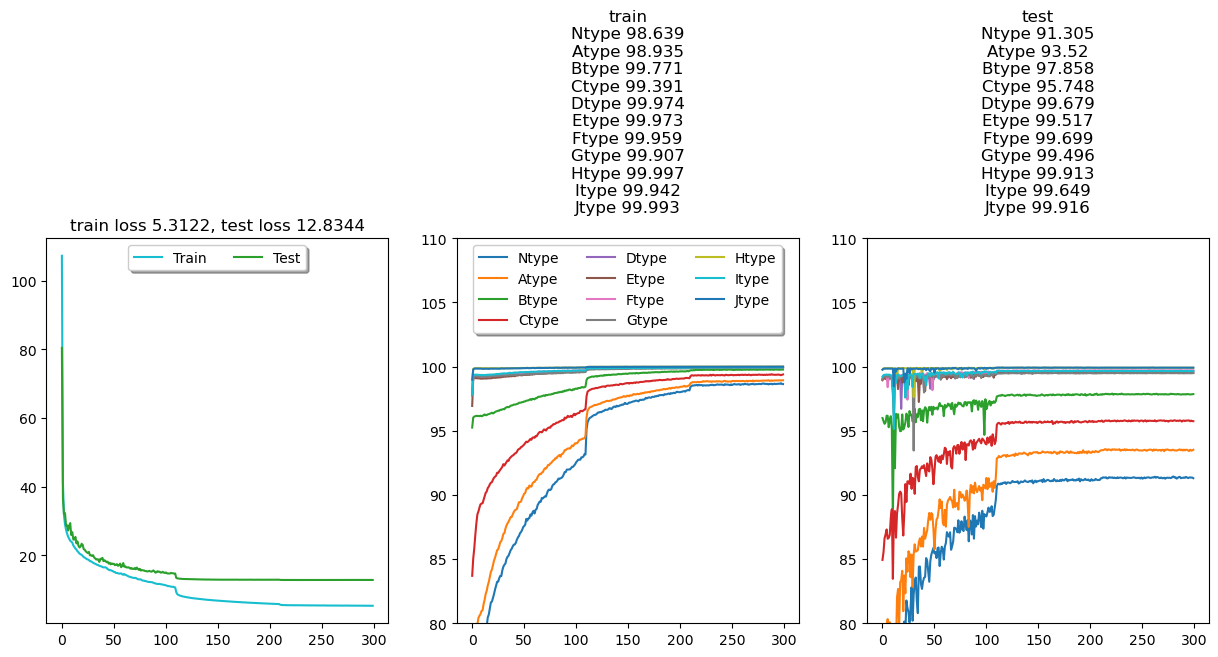

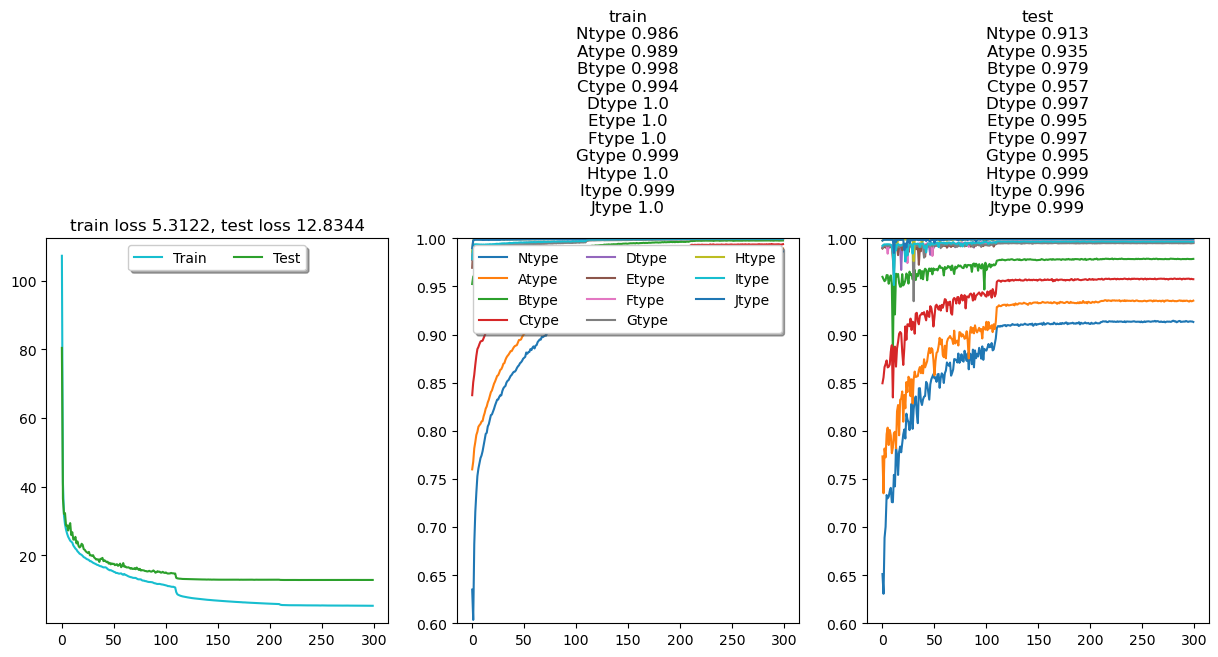

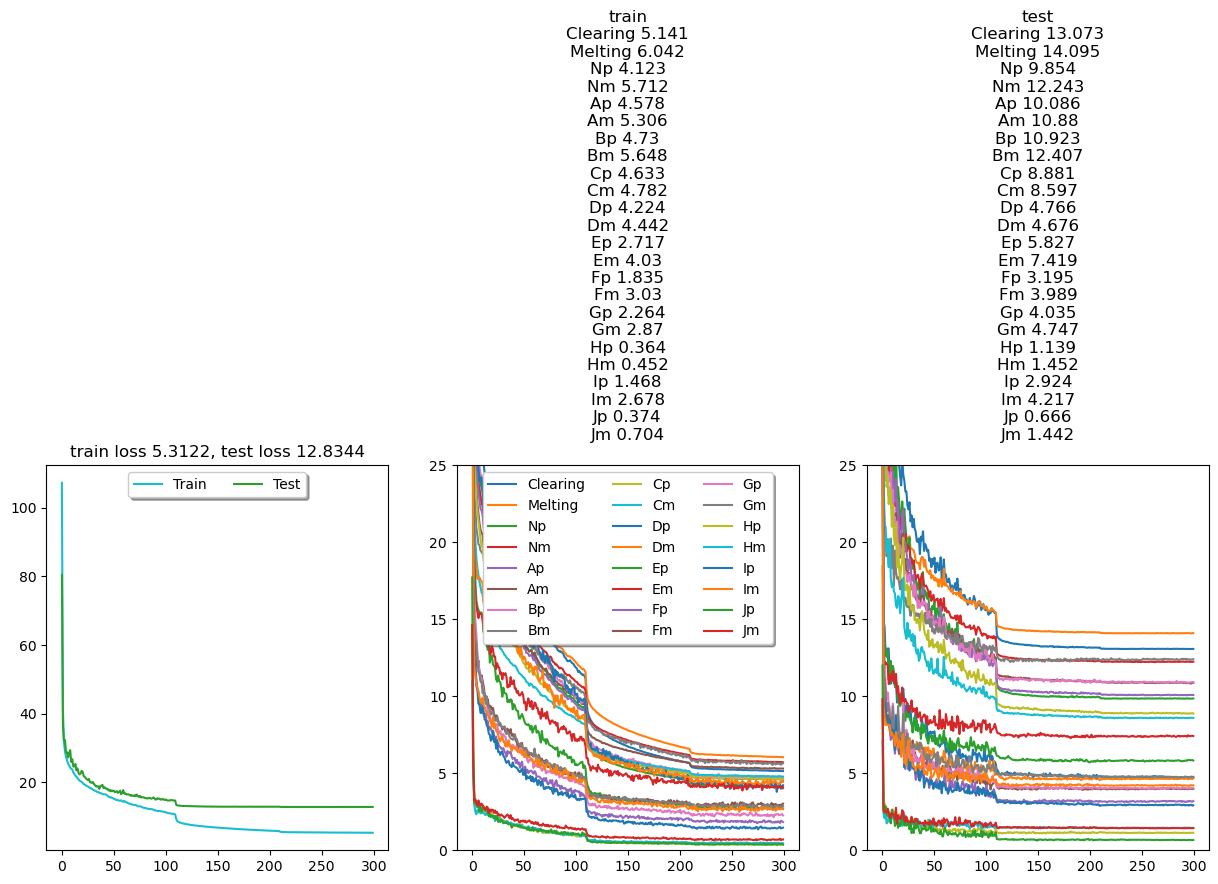

In [ ]:
plot_losses(train_loss_hist,test_loss_hist,train_acc_hist,test_acc_hist, ylim=(80,110))
plot_losses(train_loss_hist,test_loss_hist,train_f1_hist,test_f1_hist, ylim=(0.6,1.0))
plot_losses(train_loss_hist,test_loss_hist,train_MAE_hist,test_MAE_hist, ylim=(0,25))


In [ ]:
summary_csv = print_results(results_df,phase_targets, display="less")
summary_csv.to_csv(os.path.join(outdir,f'summary_{conv_type}_phase_temp.csv'))
summary_csv


Number of SMILES: 43889

prediction target Ntype (3 classes)
Accuracy:  0.91305
Cohen's kappa:  0.8404950931393917
Matthew's coeff:  0.8405051865542796
Positives: 20662
AUC:  0.9707882087782671

prediction target Ntype (2 classes)
Accuracy:  0.91586
F1:  0.91084
Cohen's kappa:  0.8311788094899079
Matthew's coeff:  0.8311869811377379

prediction target Atype (2 classes)
Accuracy:  0.9352
Cohen's kappa:  0.8092123980018007
Matthew's coeff:  0.8092138255502578
Positives: 9531
AUC:  0.9688128005849326
AUC:  0.9687970249060713
F1:  0.85058

prediction target Btype (2 classes)
Accuracy:  0.97858
Cohen's kappa:  0.6996802488417437
Matthew's coeff:  0.7007145373433047
Positives: 1710
AUC:  0.9644428319904766
AUC:  0.964365176318306
F1:  0.71077

prediction target Ctype (3 classes)
Accuracy:  0.95748
Cohen's kappa:  0.8369097051285215
Matthew's coeff:  0.8369147010730683
Positives: 6444
AUC:  0.9830236364047779

prediction target Ctype (2 classes)
Accuracy:  0.9602
F1:  0.86439
Cohen's kappa:  

npos      acc       f1       AUC    Tp_mean     Tp_std    Tm_mean  \
type                                                                       
N     20662  0.91586  0.91084  0.970788   9.860557  14.405076  12.251262   
A      9531  0.93520  0.85058  0.968813   9.903167  14.905500  10.786633   
B      1710  0.97858  0.71077  0.964443  12.371610  15.478976  13.852159   
C      6444  0.96020  0.86439  0.983024   8.993011  12.836100   9.106521   
D       341  0.99679  0.78861  0.983323  18.044724  21.023706  17.712036   
E       392  0.99517  0.70308  0.964186  10.719658  12.853891  14.789991   
F       307  0.99699  0.77627  0.975357   6.965815  10.441863   9.691195   
G       328  0.99496  0.65415  0.970309   8.434942   9.599637   9.939332   
H        52  0.99913  0.60417  0.968684  10.325297  10.724372  14.498205   
I       274  0.99649  0.71795  0.985728   6.896934  17.629391  11.136006   
J        67  0.99916  0.72180  0.996902   5.477681   6.769070  11.141775   

         Tm_std  
type             
N     14.232385  
A     13.407090  
B     15.727155  
C     11.386058  
D     20.089476  
E     15.860155  
F     11.677833  
G     10.998789  
H     13.559382  
I     19.087315  
J     14.879209

In [ ]:
# temperature error statistics
ks = []
for k in temp_targets:
    ks.extend([f"error_{k}"])
#results_df[ks].to_csv(os.path.join(outdir,'error_GNN_temperature.csv'))
results_df[ks].describe()


error_Clearing  error_Melting      error_Np      error_Nm     error_Ap  \
count    43886.000000   43887.000000  20662.000000  20662.000000  9531.000000   
mean        10.621435      12.832171      7.388669     11.048438     8.395593   
std         15.263071      14.895403     11.440285     12.523917    12.281552   
min          0.000023       0.000793      0.000031      0.001389     0.000854   
25%          2.078949       3.590446      1.568775      3.115299     1.695328   
50%          5.376530       8.402229      3.792553      7.357407     4.299629   
75%         13.017469      16.730808      8.668983     14.581429     9.946690   
max        337.499756     308.562683    330.322479    311.521423   296.278625   

          error_Am     error_Bp     error_Bm     error_Cp     error_Cm  \
count  9531.000000  1710.000000  1710.000000  6444.000000  6444.000000   
mean     10.111967    10.722628    13.325513     7.995680     8.773100   
std      12.273414    12.779169    15.315522    11.007058    10.651996   
min       0.001770     0.000946     0.002842     0.000137     0.000782   
25%       2.722496     2.742207     3.501148     1.841581     2.445353   
50%       6.312420     6.414925     8.469999     4.438141     5.498039   
75%      13.040367    14.160298    17.487371     9.868525    11.328468   
max     256.860046   130.238907   166.007233   250.563080   257.979492   

         error_Dp    error_Dm    error_Ep    error_Em    error_Fp    error_Fm  \
count  341.000000  341.000000  392.000000  392.000000  307.000000  307.000000   
mean    15.651115   17.550411   10.109549   14.087395    6.200850    9.111895   
std     19.060852   19.985455   12.959334   15.012553    8.644573   11.469691   
min      0.096695    0.080544    0.000839    0.002800    0.027267    0.005386   
25%      3.381638    4.566757    2.514366    4.561569    1.153927    1.662159   
50%      9.370766   12.229507    6.130993    9.718880    2.866600    5.106712   
75%     20.572403   21.883865   13.269658   18.462746    7.853367   11.007925   
max    163.093063  171.991638  131.337280   89.241776   57.561432   69.024445   

         error_Gp    error_Gm    error_Hp   error_Hm    error_Ip    error_Im  \
count  328.000000  328.000000   52.000000  52.000000  274.000000  274.000000   
mean     8.542749   10.090222   13.109982  14.037842    6.134303   10.118507   
std     11.901827   10.921456   18.969456  13.850165   16.290634   18.049799   
min      0.030594    0.006248    0.232788   0.504822    0.085991    0.019547   
25%      2.174829    2.806118    3.404730   6.192884    1.361990    2.513566   
50%      5.386452    6.586293    7.123013  10.941193    3.209398    5.904848   
75%     10.475647   13.721920   16.400175  16.357887    6.700583   13.208868   
max    125.478943   80.359428  108.737274  91.926796  255.169037  257.657104   

        error_Jp   error_Jm  
count  67.000000  67.000000  
mean    6.436364  11.500400  
std     6.874889  15.221550  
min     0.274681   0.152481  
25%     1.700794   2.818691  
50%     3.856239   6.089890  
75%     8.699902  13.849960  
max    32.525841  77.461807

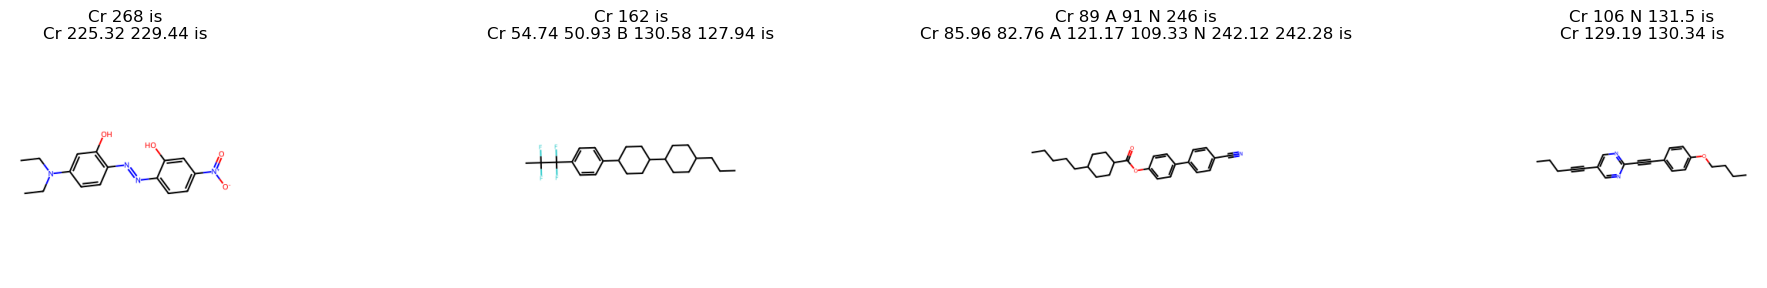

In [ ]:
from rdkit.Chem import Draw
k = 4
ind = np.random.randint(0,len(results_df),k)
fig,axs = plt.subplots(1,k,figsize=(25,3))
for j,i in enumerate(ind):
    #results_df[['SMILES','Phases','pred_Phases']].iloc[ind]
    smi = results_df['SMILES'].iloc[i]
    mol = Chem.MolFromSmiles(smi)
    img = Draw.MolToImage(mol)
    axs[j].imshow(img)
    axs[j].axis('off')
    axs[j].set_title(f"{results_df['Phases'].iloc[i]}\n{results_df['pred_Phases'].iloc[i]}")


### prediction with new dataset

In [ ]:
## inference with the trained model
new_df = pd.DataFrame({'SMILES':['CCC1(C2=CC=C(OCCCCCCCC)C=C2)CCC(C3=CC=C(OC(C4=CC=C(C#N)C=C4)=O)C=C3)(C)N1[O]','O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O','CC1(C2=CC=C(OCCCCCCCC)C=C2)CCC(C3=CC=C(OC(C4=CC=C(OC(F)(F)F)C=C4)=O)C=C3)(C)N1[O]']})
dummy_temp = np.zeros((len(new_df),len(temp_targets)))
dummy_phase = np.zeros((len(new_df),len(phase_targets)))
new_df[phase_targets]=dummy_phase
new_df[temp_targets]=dummy_temp

new_dataset = LCDataset(new_df['SMILES'],y_long=new_df[phase_targets],y_float=new_df[temp_targets],device=device, onehot_atom=onehot_atom, explicitH=explicitH)
predict_loader = DataLoader(new_dataset, batch_size=batchsize)
res = predict(predict_loader,mode='both',targets=phase_targets+temp_targets,output_channel_masks=dataset.output_channel_masks)
res=pd.DataFrame(res)
res.insert(loc = 0, column= 'pred_Phases', value=pred_phases(res))
drop_dummy_truth = [k for k in res.keys() if 'true' in k or 'error' in k]
res=res.drop(columns=drop_dummy_truth)
res.insert(loc = 0, column= 'SMILES', value=new_df['SMILES'])
res


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

SMILES  \
0  CCC1(C2=CC=C(OCCCCCCCC)C=C2)CCC(C3=CC=C(OC(C4=...   
1                O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O   
2  CC1(C2=CC=C(OCCCCCCCC)C=C2)CCC(C3=CC=C(OC(C4=C...   

                       pred_Phases  pred_Ntype  conf_Ntype  pred_Atype  \
0               Cr 101.08 94.91 is           0    0.979793           0   
1  Cr 69.53 62.29 N 75.68 73.63 is           1    0.808179           0   
2                Cr 95.43 96.67 is           0    0.997721           0   

   conf_Atype  pred_Btype  conf_Btype  pred_Ctype  conf_Ctype  pred_Dtype  \
0    0.999740           0    0.999978           0    0.996460           0   
1    0.999902           0    1.000000           0    0.999997           0   
2    0.781948           0    0.996436           0    0.999793           0   

   conf_Dtype  pred_Etype  conf_Etype  pred_Ftype  conf_Ftype  pred_Gtype  \
0    1.000000           0    1.000000           0         1.0           0   
1    1.000000           0    1.000000           0         1.0           0   
2    0.999993           0    0.999994           0         1.0           0   

   conf_Gtype  pred_Htype  conf_Htype  pred_Itype  conf_Itype  pred_Jtype  \
0         1.0           0         1.0           0         1.0           0   
1         1.0           0         1.0           0         1.0           0   
2         1.0           0         1.0           0         1.0           0   

   conf_Jtype  pred_Clearing  pred_Melting     pred_Np     pred_Nm  \
0         1.0      94.909088    101.077049   99.198822  100.057838   
1         1.0      73.625061     69.533630   75.679100   62.285393   
2         1.0      96.671486     95.433121  101.569511  113.278717   

      pred_Ap     pred_Am     pred_Bp    pred_Bm    pred_Cp    pred_Cm  \
0   97.073540  100.465714  104.447098  98.453995  98.982353  87.673759   
1  101.216301   51.539677   64.704811  30.664261  63.907032  42.255051   
2   97.631783  100.211662  103.670448  96.917854  99.567444  85.338394   

      pred_Dp    pred_Dm     pred_Ep    pred_Em    pred_Fp    pred_Fm  \
0  106.602341  96.496033  107.699951  87.294594  79.699753  64.751358   
1   85.022758  72.121696   50.038582  36.717697  56.590561  24.825184   
2  103.679802  97.294266   98.945305  98.744125  79.086365  77.291252   

     pred_Gp    pred_Gm     pred_Hp     pred_Hm     pred_Ip    pred_Im  \
0  62.175911  68.607300   91.385712  121.902191  102.232162  75.618706   
1   3.577051  38.787617   62.926495   94.122749   47.140793  25.746504   
2  75.186394  70.588890  109.786392  109.520630   98.551132  81.469063   

     pred_Jp    pred_Jm  
0  84.328568  58.133606  
1  37.892399  32.534454  
2  80.729530  75.843018

## transition temperature

### learning

CV 0


  0%|          | 0/500 [00:00<?, ?epoch/s]

epoch 0	train loss: 119.71568,	test loss: 119.03519	test MAE Clearing: 136.28827	test MAE Melting: 100.84418	test MAE Np: 148.51701	time 11.0
epoch 100	train loss: 11.75489,	test loss: 15.75731	test MAE Clearing: 16.08968	test MAE Melting: 16.12051	test MAE Np: 13.70044	time 1088.0
epoch 200	train loss: 8.62911,	test loss: 12.7117	test MAE Clearing: 12.53411	test MAE Melting: 14.36634	test MAE Np: 9.67719	time 2158.0
epoch 400	train loss: 5.40771,	test loss: 11.70685	test MAE Clearing: 11.41511	test MAE Melting: 13.65339	test MAE Np: 8.28163	time 4301.0
epoch 499	train loss: 5.34131,	test loss: 11.7305	test MAE Clearing: 11.41693	test MAE Melting: 13.69184	test MAE Np: 8.25677	time 5363.0
CV 1


  0%|          | 0/500 [00:00<?, ?epoch/s]

epoch 0	train loss: 120.25529,	test loss: 118.20665	test MAE Clearing: 135.34936	test MAE Melting: 100.75791	test MAE Np: 147.45195	time 11.0
epoch 100	train loss: 11.55109,	test loss: 14.04262	test MAE Clearing: 14.14724	test MAE Melting: 15.25103	test MAE Np: 11.32298	time 1085.0
epoch 300	train loss: 5.96203,	test loss: 11.4921	test MAE Clearing: 11.53498	test MAE Melting: 13.45047	test MAE Np: 8.13546	time 3243.0
epoch 400	train loss: 5.29746,	test loss: 11.48031	test MAE Clearing: 11.52047	test MAE Melting: 13.5041	test MAE Np: 8.09824	time 4316.0
epoch 499	train loss: 5.26073,	test loss: 11.49041	test MAE Clearing: 11.53065	test MAE Melting: 13.52137	test MAE Np: 8.10365	time 5377.0
CV 4


  0%|          | 0/500 [00:00<?, ?epoch/s]

epoch 0	train loss: 119.87167,	test loss: 118.48957	test MAE Clearing: 134.65636	test MAE Melting: 100.89994	test MAE Np: 146.84874	time 11.0
epoch 100	train loss: 11.43175,	test loss: 13.60056	test MAE Clearing: 13.56007	test MAE Melting: 15.13182	test MAE Np: 10.32908	time 1080.0
epoch 200	train loss: 8.64481,	test loss: 12.56345	test MAE Clearing: 12.70356	test MAE Melting: 14.16209	test MAE Np: 9.53212	time 2158.0
epoch 300	train loss: 5.94025,	test loss: 11.61692	test MAE Clearing: 11.55453	test MAE Melting: 13.54291	test MAE Np: 8.33356	time 3229.0
epoch 400	train loss: 5.41571,	test loss: 11.53225	test MAE Clearing: 11.46153	test MAE Melting: 13.52092	test MAE Np: 8.193	time 4302.0
epoch 499	train loss: 5.35316,	test loss: 11.55463	test MAE Clearing: 11.49781	test MAE Melting: 13.54236	test MAE Np: 8.23004	time 5367.0


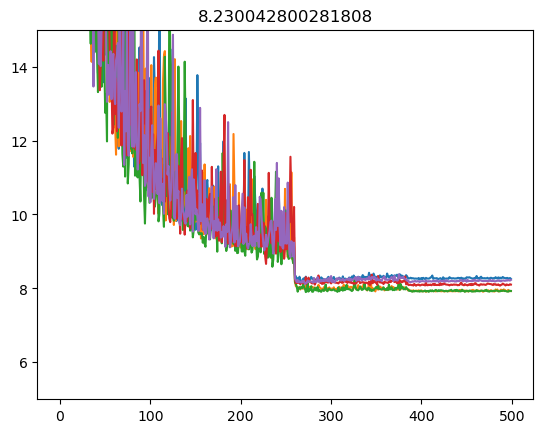

In [ ]:
# model configuration
norm = "BatchNorm"

conv_type="GATv2Conv"
hidden_channel=512 # 128
lr = 1e-3 
num_heads = 4
epochs=300

conv_type="NNConv"
hidden_channel=128
num_heads = 1
lr = 3e-3
epochs=500

dropout=0.5
num_layers=12
batchsize=128*4
warmup_epochs = 10
plot_interval = 100

id_emb_dim = 5 if atom_encoding == 'integer' else 0

results = []
train_loss_hist = []
test_loss_hist = []
train_MAE_hist = []
test_MAE_hist = []
#for cv in range(1):
for cv in range(n_splits):
    print(f'CV {cv}, started at {datetime.now().strftime("%H:%M:%S")}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_MAE_hist.append({k:[] for k in temp_targets})
    test_MAE_hist.append({k:[] for k in temp_targets})

    #model = GraphSAGE(-1, hidden_channels=64,num_layers=num_layers,dropout=dropout, out_channels=output_channels, norm=norm).to(device)
    model= GNN(hidden_channels=64,num_layers=num_layers,out_channels=[len(temp_targets)],dim_node_attr=dataset.dim_node_attr+id_emb_dim,dim_edge_attr=dataset.dim_edge_attr,id_emb_dim=id_emb_dim,num_heads=num_heads,conv_type=conv_type).to(device)

    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=1e-5)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.5*epochs), int(0.75*epochs)], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = DataLoader(dataset[train_indices[cv]], batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(dataset[test_indices[cv]], batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss, train_MAEs = train(train_loader,mode='regression')
            test_loss, test_MAEs = test(test_loader,mode='regression')
            if (epoch % plot_interval == 0) or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)},\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test MAE {temp_targets[k]}: {round(test_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(temp_targets):
                train_MAE_hist[-1][k].append(train_MAEs[j].avg)
                test_MAE_hist[-1][k].append(test_MAEs[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)

    # prediction
    res=predict(test_loader,mode='regression',targets=temp_targets)
    res=pd.DataFrame(res,index=test_indices[cv])
    results.append(res)
    #print(res.describe())
    plt.plot(test_MAE_hist[cv]['Np'])
    plt.ylim(5,15)
    plt.title(test_MAE_hist[cv]['Np'][-1])
    plt.savefig(os.path.join(outdir,f'{conv_type}_{cv}.jpg'))
# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).sort_index()
results_df = pd.concat([results_df,results_df2],axis=1)
colnames = ['ID', 'SMILES', 'Phases']
for s in temp_targets:
    colnames.extend([f'true_{s}',f'pred_{s}',f'error_{s}'])
results_df=results_df[colnames]    
results_df.to_csv(os.path.join(outdir,f'result_{conv_type}_temperature.csv'),index=False)
    

In [ ]:
ks = []
for k in temp_targets:
    ks.extend([f"error_{k}"])
#results_df[ks].to_csv(os.path.join(outdir,'error_GNN_temperature.csv'))
results_df[ks].describe()


error_Clearing  error_Melting      error_Np      error_Nm     error_Ap  \
count    43886.000000   43887.000000  20662.000000  20662.000000  9531.000000   
mean        11.397025      13.434875      8.138757     12.310243     9.883835   
std         16.238094      15.616138     12.175488     13.623022    13.766365   
min          0.000397       0.000114      0.000015      0.000031     0.000130   
25%          2.310896       3.763271      1.795811      3.525249     2.088369   
50%          5.884102       8.669228      4.347206      8.170532     5.223465   
75%         14.007001      17.528870      9.502425     16.431290    12.199669   
max        343.762268     303.374786    329.785126    307.636414   346.851257   

          error_Am     error_Bp     error_Bm     error_Cp     error_Cm  \
count  9531.000000  1710.000000  1710.000000  6444.000000  6444.000000   
mean     11.439542    12.330048    13.993464     9.312027     9.715130   
std      13.579625    14.578809    15.150415    12.071809    11.313726   
min       0.002174     0.007111     0.019569     0.000305     0.000725   
25%       3.088263     3.307646     4.035330     2.300453     2.785776   
50%       7.232811     7.557365     9.557106     5.528381     6.318735   
75%      14.686792    15.764345    18.996351    11.573044    12.685701   
max     303.216095   157.972382   159.416504   299.151245   270.434753   

         error_Dp    error_Dm    error_Ep    error_Em    error_Fp    error_Fm  \
count  341.000000  341.000000  392.000000  392.000000  307.000000  307.000000   
mean    17.921309   18.336960   11.742557   14.273231    8.239248   10.974026   
std     21.630699   22.563498   12.319947   14.423727   10.951151   12.215129   
min      0.037720    0.034134    0.002747    0.013611    0.014771    0.049164   
25%      4.560715    4.279396    3.905441    4.232067    1.781128    2.547722   
50%      9.571594   10.822632    7.919472    9.276676    4.502937    7.280121   
75%     23.433907   23.853111   15.980098   19.125025    9.606205   14.015812   
max    132.834839  158.281906   95.889359   80.252869   75.657692   66.841866   

         error_Gp    error_Gm   error_Hp   error_Hm    error_Ip    error_Im  \
count  328.000000  328.000000  52.000000  52.000000  274.000000  274.000000   
mean     9.844086   11.771960  12.116205  12.911325    8.791416   11.505571   
std     10.681623   12.655092  12.562594  10.970592   19.032019   19.937212   
min      0.017258    0.044476   0.290802   0.749207    0.033104    0.028362   
25%      3.189819    3.271942   3.159546   5.838047    2.005230    2.826967   
50%      6.853956    7.728117   8.901222   9.889174    4.380341    6.851665   
75%     12.685511   15.453612  14.313977  19.135296    9.985039   13.854181   
max    100.452957  108.755936  50.019257  53.351849  272.507935  270.972687   

        error_Jp   error_Jm  
count  67.000000  67.000000  
mean    6.354072  11.306289  
std     6.447413  11.148335  
min     0.082375   0.096481  
25%     1.722309   3.508932  
50%     3.669716   7.618248  
75%     9.398216  14.303200  
max    30.476570  52.449974

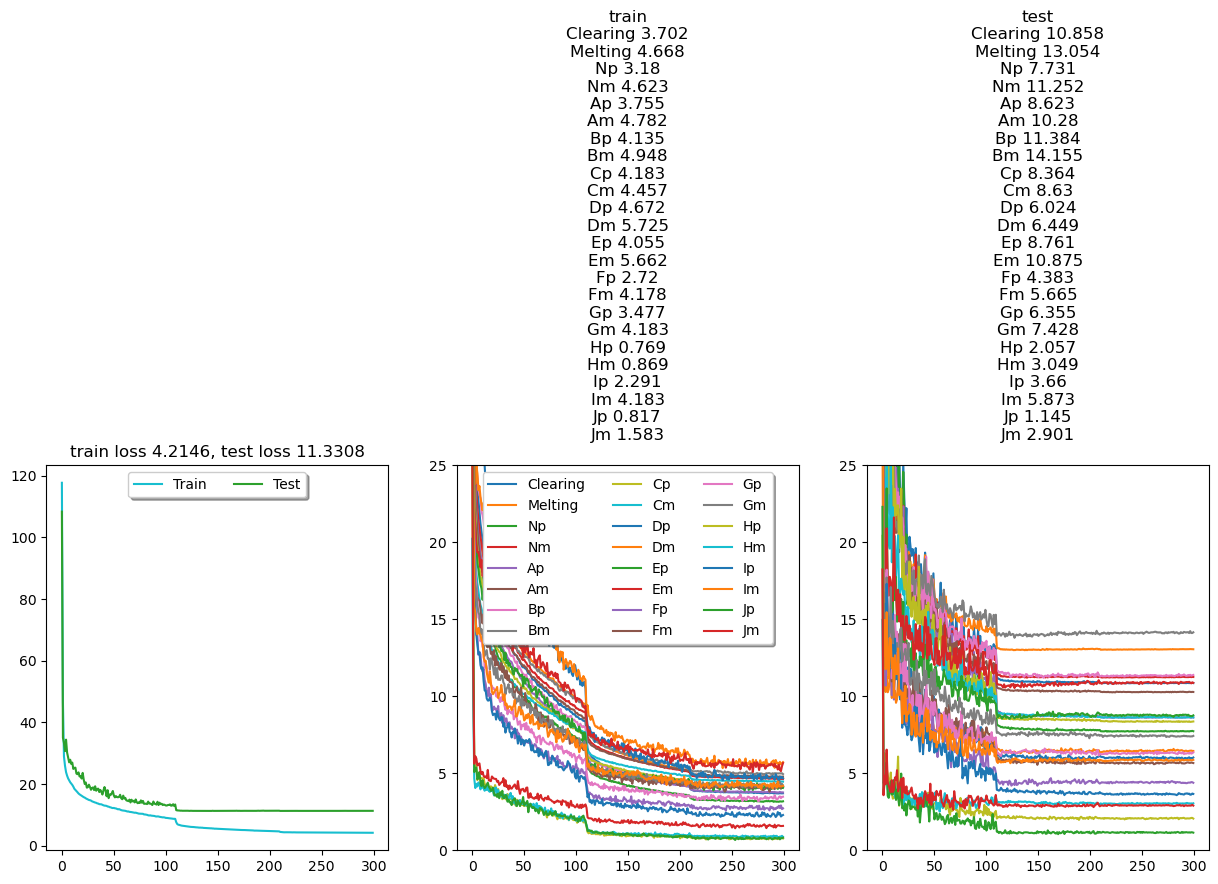

In [ ]:
plot_losses(train_loss_hist,test_loss_hist,train_MAE_hist,test_MAE_hist, ylim=(0,25),title=True)


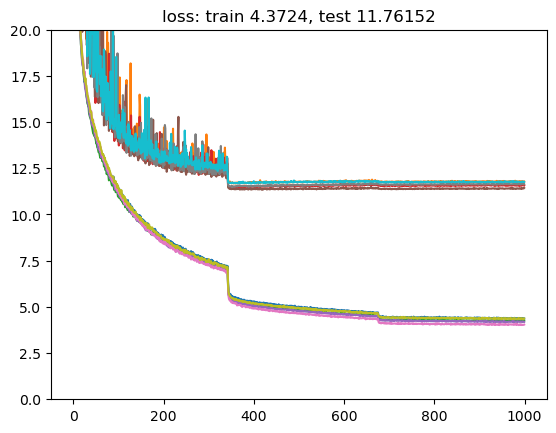

In [ ]:
# CV-wise
for loss_hist,test_hist in zip(train_loss_hist,test_loss_hist):
    plt.plot(loss_hist, label="Train Loss")
    plt.plot(test_hist, label="Test Loss")
#plt.yscale('log')
#plt.legend()
plt.ylim(0,20)
plt.title(f"loss: train {round(loss_hist[-1],5)}, test {round(test_hist[-1],5)}")
plt.show()


## phase existence

### learning

In [ ]:
# setup optimisation configuration
norm = "BatchNorm"
conv_type="GATv2Conv" # "NNConv"
dropout=0.5
num_layers=12
num_heads = 8
hidden_channel=512 # 128
batchsize=256
lr = 1e-3 #5e-3 for NNConv
epochs=100
warmup_epochs = 5
plot_interval = 50

id_emb_dim = 5 if atom_encoding == 'integer' else 0
    
results = []
train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []
train_f1_hist = []
test_f1_hist = []
#for cv in range(1):
for cv in range(n_splits):
    print(f'CV {cv}, started at {datetime.now().strftime("%H:%M:%S")}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_acc_hist.append({k:[] for k in phase_targets})
    test_acc_hist.append({k:[] for k in phase_targets})
    train_f1_hist.append({k:[] for k in phase_targets})
    test_f1_hist.append({k:[] for k in phase_targets})
    
    #model = GraphSAGE(-1, hidden_channels=64,num_layers=num_layers,dropout=dropout, out_channels=output_channels, norm=norm).to(device)
    model= GNN(hidden_channels=hidden_channel,num_layers=num_layers,dim_node_attr=dataset.dim_node_attr+id_emb_dim,dim_edge_attr=dataset.dim_edge_attr, out_channels=dataset.output_channels[:1], id_emb_dim=id_emb_dim,conv_type=conv_type).to(device)
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)#, amsgrad=False)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3, 2*epochs//3], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = DataLoader(dataset[train_indices[cv]], batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(dataset[test_indices[cv]], batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss,train_acc,train_f1 = train(train_loader,mode='classification',output_channel_masks=dataset.output_channel_masks)
            test_loss,test_acc,test_f1 = test(test_loader,mode='classification',output_channel_masks=dataset.output_channel_masks)
            if epoch % plot_interval == 0 or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)}\t"+
                      "\t".join([f'train acc {phase_targets[k]}: {round(train_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test acc {phase_targets[k]}: {round(test_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(phase_targets):
                train_acc_hist[-1][k].append(train_acc[j].avg)
                test_acc_hist[-1][k].append(test_acc[j].avg)
                train_f1_hist[-1][k].append(train_f1[j].avg)
                test_f1_hist[-1][k].append(test_f1[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)
    # prediction
    res=predict(test_loader,mode='classification',targets=phase_targets,output_channel_masks=dataset.output_channel_masks)
    res=pd.DataFrame(res)
    res['index']=test_indices[cv]
    results.append(res)

# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).set_index('index').sort_index()#.rename(columns=colname)
results_df = pd.concat([results_df,results_df2],axis=1)
results_df.to_csv(os.path.join(outdir,f'result_{conv_type}_phase.csv'),index=False)


In [ ]:
plot_losses(train_loss_hist,test_loss_hist,train_acc_hist,test_acc_hist)

In [ ]:
#print_results(results_df,phase_targets,display="all")
print_results(results_df,phase_targets,display="less")

# Combining results of different models

In [ ]:
#model_type = "GNN"
model_type = "LGBM_All"
phase_df = pd.read_csv(os.path.join(outdir,f'result_{model_type}_phase.csv'),index_col='ID').sort_index()
temperature_df = pd.read_csv(os.path.join(outdir,f'result_{model_type}_temperature.csv'),index_col='ID').sort_index()
temperature_df = temperature_df.drop(columns=['Phases','SMILES'])
results_df = pd.concat([phase_df,temperature_df],axis=1).reset_index().rename(columns={'index':'ID'})
results_df.insert(loc = 3, column= 'pred_Phases', value=pred_phases(results_df))
results_df.to_csv(os.path.join(outdir,f'result_{model_type}_combined.csv'),index=False)
results_df

  0%|          | 0/43889 [00:00<?, ?it/s]

ID                                             SMILES  \
0           3                   CCCCCCCCCCCCCCCC(=O)OC1C=CC=CC=1   
1           4                 CCCCCCCCCCCCCCCCCC(=O)OC1C=CC=CC=1   
2           5                  CCCCCCCCCCCCCCCC(=O)OCC1C=CC=CC=1   
3           6                CCCCCCCCCCCCCCCCCC(=O)OCC1C=CC=CC=1   
4           7                        COC(=O)C=CC=CC=CC1C=CC=CC=1   
...       ...                                                ...   
43884  130155                       O=C(C1=CC=CC=C1)CCCCC2CCCCC2   
43885  130180  OC(=O)C3C=C2N=C1C5C(C4C(C1=NC2=CC=3)=CC(OCCCCC...   
43886  130184  O=C(OC)C3C=C2N=C1C5C(C4C(C1=NC2=CC=3)=CC(OCCCC...   
43887  130186  COC(=O)C3=C2N=C1C5C(C4C(C1=NC2=CC=C3)=CC(OCCCC...   
43888  130225  O=C(CCC(=O)NCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC...   

                      Phases                         pred_Phases  true_Ntype  \
0                   Cr 46 is                   Cr 44.39 43.71 is           0   
1                   Cr 52 is                   Cr 49.51 48.03 is           0   
2                   Cr 36 is                   Cr 40.02 40.84 is           0   
3                 Cr 45.5 is                   Cr 46.85 40.43 is           0   
4                  Cr 114 is                  Cr 96.00 112.20 is           0   
...                      ...                                 ...         ...   
43884               Cr 25 is                   Cr 36.35 25.93 is           0   
43885  Cr 47 Dr 154 N 193 is  Cr 95.63 82.10 Dh 114.85 120.65 is           1   
43886         Cr 77 Dh 98 is                  Cr 75.74 143.41 is           0   
43887              Cr 127 is                  Cr 82.22 128.56 is           0   
43888    Cr' 51.8 Cr 73.2 is                  Cr 45.54 105.92 is           0   

       pred_Ntype  conf_Ntype  true_Atype  pred_Atype  conf_Atype  true_Btype  \
0               0    1.000000           0           0    1.000000           0   
1               0    1.000000           0           0    1.000000           0   
2               0    1.000000           0           0    1.000000           0   
3               0    1.000000           0           0    0.999999           0   
4               0    1.000000           0           0    0.999999           0   
...           ...         ...         ...         ...         ...         ...   
43884           0    1.000000           0           0    1.000000           0   
43885           0    0.999994           0           0    0.999995           0   
43886           0    0.698399           0           0    0.999999           0   
43887           0    0.999124           0           0    0.999999           0   
43888           0    0.999959           0           0    0.999992           0   

       pred_Btype  conf_Btype  true_Ctype  pred_Ctype  conf_Ctype  true_Dtype  \
0               0    0.999999           0           0    1.000000           0   
1               0    0.999999           0           0    1.000000           0   
2               0    0.999999           0           0    1.000000           0   
3               0    0.999999           0           0    1.000000           0   
4               0    1.000000           0           0    1.000000           0   
...           ...         ...         ...         ...         ...         ...   
43884           0    1.000000           0           0    1.000000           0   
43885           0    1.000000           0           0    0.999987           0   
43886           0    1.000000           0           0    0.999998           1   
43887           0    1.000000           0           0    1.000000           0   
43888           0    0.999973           0           0    0.999835           0   

       pred_Dtype  conf_Dtype  true_Etype  pred_Etype  conf_Etype  true_Ftype  \
0               0    1.000000           0           0    0.999999           0   
1               0    1.000000           0           0    1.000000           0   
2               0    1.000000           0   

In [ ]:
df_name = "result_GNN_phase_temp.csv"
#df_name =f'result_{model_type}_combined.csv'
results_df = pd.read_csv(os.path.join(outdir,df_name))
print_results(results_df,phase_targets,display="less")


# Compute descriptors from SMILES and parse Phase sequence

In [ ]:
import joblib
class ProgressParallel(joblib.Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return joblib.Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()
        

## Descriptors

In [ ]:
# compute descriptors
#smiles_fn = 'LiqCryst52.csv' # the csv should contain "ID", "SMILES", "Phases" columns
smiles_fn = 'sample.csv' # the csv should contain "ID", "SMILES", "Phases" columns. This sample file is too small! A database with a decent size is required for an actual usage.
csv_fn = 'sample_desc.csv' # save the computed descriptors to this file
parquet_fn = 'sample.parquet' # save the computed descriptors to this file

num_cores = 12

##
df = pd.read_csv(smiles_fn,low_memory=False).sort_values('ID').set_index('ID')
calc = Calculator(descriptors, ignore_3D=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mds = pd.DataFrame(ProgressParallel(n_jobs=num_cores, total=len(df))(joblib.delayed(lambda x:calc(Chem.MolFromSmiles(x)).fill_missing(np.nan).asdict())(smi) for smi in df['SMILES']))
#slist=[Chem.MolFromSmiles(x) for x in df['SMILES']]
#mds=calc.pandas(slist,nproc=num_cores,ipynb=True)
mds['ID']=df.index.values
mds = mds.set_index('ID')

#df = df.loc[:,nonvars]
df = pd.concat([df,mds],axis=1)
df.head(5)


  0%|          | 0/5 [00:00<?, ?it/s]

SMILES              Phases  \
ID                                                                          
0                                         C1C=CC=CC=1             Cr 6 is   
3      CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)C)C3       Cr 64 A 81 is   
4   CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)CCCC...  Cr 37 A 38 N 40 is   
5                CCCCCC1C=CC(=CC=1)C2C=CC(OCCCC)=CC=2  Cr 63 B 81 A 89 is   
6                 O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O       Cr 65 N 72 is   

          ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
ID                                                                      
0    4.242641   4.000000      0      0   8.000000  2.000000  4.000000   
3   19.148902  14.058137      0      0  32.262513  2.501601  4.842936   
4   21.867940  15.050497      0      0  37.953147  2.472014  4.944029   
5   16.223016  12.052430      0      0  28.508519  2.332798  4.665595   
6   15.694249  12.724119      0      0  27.800002  2.305462  4.610924   

       SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A        VR1_A  \
ID                                                                             
0    8.000000  1.333333  2.687624  2.449490  0.408248  0.385054    14.696938   
3   32.262513  1.290501  4.138220  3.806670  0.152267  2.253045  4322.930660   
4   37.953147  1.308729  4.272890  4.063423  0.140118  2.466736  3872.362914   
5   28.508519  1.295842  3.981100  3.881541  0.176434  2.144690   303.753493   
6   27.800002  1.263636  3.952457  3.681050  0.167320  2.091655   381.438810   

         VR2_A     VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  \
ID                                                                          
0     2.449490  2.176814          6          6     12           6       0   
3   172.917226  9.287980         12         12     55          25       0   
4   133.529756  9.326331         12         12     67          29       0   
5    13.806977  6.504674         12         12     50          22       0   
6    17.338128  6.732408          6          6     44          22       0   

    nBridgehead  nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX  \
ID                                                                           
0             0        0   6   0   6   0   0   0   0   0    0    0   0   0   
3             0        1  30   0  24   0   1   0   0   0    0    0   0   0   
4             0        1  38   0  28   0   1   0   0   0    0    0   0   0   
5             0        1  28   0  21   0   1   0   0   0    0    0   0   0   
6             0        6  22   0  16   0   6   0   0   0    0    0   0   0   

    ATS0dv  ATS1dv  ATS2dv  ATS3dv  ATS4dv  ATS5dv  ATS6dv  ATS7dv  ATS8dv  \
ID                                                                           
0     54.0    54.0    54.0    27.0     0.0     0.0     0.0     0.0     0.0   
3    240.0   260.0   350.0   333.0   282.0   225.0   204.0   164.0   147.0   
4    256.0   278.0   374.0   389.0   336.0   284.0   238.0   217.0   190.0   
5    202.0   216.0   272.0   260.0   208.0   188.0   164.0   132.0   104.0   
6    326.0   262.0   358.0   334.0   300.0   276.0   240.0   324.0   164.0   

    ATS0d  ATS1d  ATS2d  ATS3d  ...      GGI7      GGI8      GGI9     GGI10  \
ID                              ...                                           
0    30.0   36.0   48.0   42.0  ...  0.000000  0.000000  0.000000  0.000000   
3   156.0  200.0  330.0  369.0  ...  0.218785  0.207137  0.115008  0.093668   
4   180.0  233.0  382.0  454.0  ...  0.326389  0.221214  0.183750  0.127844   
5   130.0  163.0  255.0  290.0  ...  0.149306  0.131015  0.071250  0.057749   
6   118.0  146.0  210.0  235.0  ...  0.180556  0.139582  0.111250  0.074278   

        JGI1      JGI2      JGI3      JGI4      JGI5      JGI6      JGI7  \
ID                                                                         
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.148148  0.06

## LiqCryst's 'Phases' entry parser

In [ ]:
# phase parser
melting_types = ["Cr","Cr'","Tg"] # Tg: glass
clearing_types = ["is","chg","dec"] # no, un, ex: ambiguous
L=[]

def is_number(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

def is_valid_temp(x, nan=np.nan):
    if x=="?" or "<" in x or ">" in x:
        return(False)
    if not is_number(x):
        return(False)
    x=float(x)
    if x < kelv or x==0:
        return(False)
    else:
        return(True)
    
def is_valid_phase(x):
    if is_number(x):
        return(False)
    if '(' in x:   # this occurs only in the form "(number) Cr"
        return(False)
    if '>' in x or '<' in x: # this occurs only in the form "<number" or "<?"
        return(False)
    if '=0' in x:
        return(False)
    else:
        return(x)

# do some cleaning for Phases
L=[]
p1 = re.compile('isSciDex.*')
p2 = re.compile('\s]\s')
for ph in tqdm(df['Phases'],total=len(df)):
    L.append(p2.sub(' J ',p1.sub('is', ph)))
df['Phases']=L

#
exclude = np.zeros(len(df),dtype=bool)
reentrant = np.zeros(len(df),dtype=bool)
exclude_list = ['X','BS','So','cub','Are','Nre','Nre*','I/F*','Dsq','Dob','Bhx','C~a','C~g','CA','CA*','Tg','tr','Y','S','D']
phtype={sym: np.zeros(len(df),dtype=np.int8) for sym in phase_types+['Clearing','Melting']}
tempL=[sym+"m" for sym in phase_types]+[sym+"p" for sym in phase_types]+['Clearing','Melting']
phtemp={sym: np.full(len(df),np.nan,dtype=np.float32) for sym in tempL}
phase_words = []
for i,ph in enumerate(tqdm(df['Phases'],total=len(df))):
    pL=[]
    # each entry
    phsplit=ph.split()
    #print(phsplit)
    for j,x in enumerate(phsplit):
        for sym in exclude_list:
            if x==sym:
                exclude[i]=True
        if is_valid_phase(x) and not exclude[i]:
            pL.append(x)
        for sym in phase_types:
            search_temp = False
            if sym=="D":
                if "Dh" in x:
                    phtype[sym][i]=1
                    search_temp = True
            else:
                if x==sym:
                    phtype[sym][i]=1
                    search_temp = True
                elif x==sym+"*":
                    phtype[sym][i]=2
                    search_temp = True
            # temperature
            if search_temp:
                if j>0 and is_valid_temp(phsplit[j-1]):
                    phtemp[sym+"m"][i]=float(phsplit[j-1])
                else:
                    phtemp[sym+"m"][i]=np.nan
                    exclude[i]=True
                if j<len(phsplit)-1 and is_valid_temp(phsplit[j+1]):
                    phtemp[sym+"p"][i]=float(phsplit[j+1])
                else:
                    phtemp[sym+"p"][i]=np.nan
                    exclude[i]=True                        
                    
        if x in melting_types:
            phtype['Melting'][i]=2 if x=="Tg" else 1
            if j<len(phsplit)-1 and is_valid_temp(phsplit[j+1]):
                phtemp['Melting'][i]=float(phsplit[j+1])
            else:
                phtemp['Melting'][i]=np.nan
        if x in clearing_types:
            phtype['Clearing'][i]=1 if x=="is" else 2
            if j>0 and is_valid_temp(phsplit[j-1]):
                phtemp['Clearing'][i]=float(phsplit[j-1])
            else:
                phtemp['Clearing'][i]=np.nan
            
    phase_words.extend(pL)
    
    # re-entrant
    for uh in phase_types:
        if (ph.count(f" {uh} ")+ph.count(f" {uh}* ")>1):
            #print(ph) # ,df.iloc[i,:3])
            reentrant[i] = True
    if (ph.count("Dh")>1): # "Dh", "Dho", "Dhd"
        reentrant[i] = True
        #print(ph)
                        
print(f"Mols containing excluded phases {exclude.sum()}, re-entrant phases {reentrant.sum()}")    
pd.DataFrame(phase_words).value_counts()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Mols containing excluded phases 0, re-entrant phases 0


Cr    5
is    5
A     3
N     2
B     1
dtype: int64

In [ ]:
# save cleaned df
try:
    df=df.drop(columns=['exclude','reentrant'])
except:
    pass
df.insert(loc = 2, column= 'exclude', value=exclude)
df.insert(loc = 2, column= 'reentrant', value=reentrant)
for i,sym in enumerate(phase_types):
    try:
        df=df.drop(columns=[f'{sym}type',f'{sym}m',f'{sym}p'])
    except:
        pass
    df.insert(loc = 4+i, column= f'{sym}type', value=phtype[sym])
    df.insert(loc = 5+i, column= f'{sym}m', value=phtemp[f'{sym}m'])
    df.insert(loc = 6+i, column= f'{sym}p', value=phtemp[f'{sym}p'])
for i,sym in enumerate(['Clearing','Melting']):
    try:
        df=df.drop(columns=[f'{sym}type',f'{sym}'])
    except:
        pass
    df.insert(loc = 4+i, column= f'{sym}type', value=phtype[sym])
    df.insert(loc = 5+i, column= f'{sym}', value=phtemp[f'{sym}'])

if csv_fn is not None:
    df.reset_index().to_csv(csv_fn,index=False)
    print(f"the databse file is saved as {csv_fn}.")
if parquet_fn is not None:
    df.to_parquet(parquet_fn, compression="GZIP")
    print(f"the databse file is saved as {parquet_fn}.")
print("Now, the saved database file can be used for model learning: Jump to ``Load dataset from file'' section.")
df

the databse file is saved as sample_desc.csv.
the databse file is saved as sample.parquet.
Now, the saved database file can be used for model learning: Jump to ``Load dataset from file'' section.


SMILES              Phases  \
ID                                                                          
0                                         C1C=CC=CC=1             Cr 6 is   
3      CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)C)C3       Cr 64 A 81 is   
4   CCCCCCCCCC1C=C3C(=CC=1)C2C(=CC(=CC=2)C(=O)CCCC...  Cr 37 A 38 N 40 is   
5                CCCCCC1C=CC(=CC=1)C2C=CC(OCCCC)=CC=2  Cr 63 B 81 A 89 is   
6                 O=C(OCCCCO)C1C=CC(=CC=1)C(OCCCCO)=O       Cr 65 N 72 is   

    reentrant  exclude  Clearingtype  Meltingtype  Melting  Clearing  Ntype  \
ID                                                                            
0       False    False             1            1      6.0       6.0      0   
3       False    False             1            1     64.0      81.0      0   
4       False    False             1            1     37.0      40.0      1   
5       False    False             1            1     63.0      89.0      0   
6       False    False             1            1     65.0      72.0      1   

    Atype  Btype  Ctype  Dtype  Etype  Ftype  Gtype  Htype  Itype  Jtype  Jm  \
ID                                                                             
0       0      0      0      0      0      0      0      0      0      0 NaN   
3       1      0      0      0      0      0      0      0      0      0 NaN   
4       1      0      0      0      0      0      0      0      0      0 NaN   
5       1      1      0      0      0      0      0      0      0      0 NaN   
6       0      0      0      0      0      0      0      0      0      0 NaN   

    Jp  Im  Ip  Hm  Hp  Gm  Gp  Fm  Fp  Em  Ep  Dm  Dp  Cm  Cp    Bm    Bp  \
ID                                                                           
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN   NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN   NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN   NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  63.0  81.0   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN   NaN   

      Am    Ap    Nm    Np        ABC      ABCGG  nAcid  nBase    SpAbs_A  \
ID                                                                          
0    NaN   NaN   NaN   NaN   4.242641   4.000000      0      0   8.000000   
3   64.0  81.0   NaN   NaN  19.148902  14.058137      0      0  32.262513   
4   37.0  38.0  38.0  40.0  21.867940  15.050497      0      0  37.953147   
5   81.0  89.0   NaN   NaN  16.223016  12.052430      0      0  28.508519   
6    NaN   NaN  65.0  72.0  15.694249  12.724119      0      0  27.800002   

     SpMax_A  SpDiam_A     SpAD_A   SpMAD_A  ...      GGI7      GGI8  \
ID                                           ...                       
0   2.000000  4.000000   8.000000  1.333333  ...  0.000000  0.000000   
3   2.501601  4.842936  32.262513  1.290501  ...  0.218785  0.207137   
4   2.472014  4.944029  37.953147  1.308729  ...  0.326389  0.221214   
5   2.332798  4.665595  28.508519  1.295842  ...  0.149306  0.131015   
6   2.305462  4.610924  27.800002  1.263636  ...  0.180556  0.139582   

        GGI9     GGI10      JGI1      JGI2      JGI3      JGI4      JGI5  \
ID                                                                         
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.115008  0.093668  0.148148  0.061728  0.045525  0.027634  0.027532   
4   0.183750  0.127844  0.129032  0.066667  0.031977  0.037721  0.016865   
5   0.071250  0.057749  0.130435  0.063492  0.017857  0.021852  0.024621   
6   0.111250  0.074278  0.136364  0.085470  0.037037  0.025926  0.025132   

        JGI6      JGI7      JGI8      JGI9     JGI10     JGT10  Diameter  \
ID                                                                         
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000         3   
3   0.019809  0.010418  0.010902  0.007

# (Cells below are not maintained)

## Fitting MLP models

### model

In [ ]:
import torch
import torch.utils.data
from sklearn.preprocessing import StandardScaler

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels=64, num_layers=5, out_channels=[1], dropout=0):
        super(MLP, self).__init__()
        self.dropout = dropout
        
        self.fcs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(num_layers-1):
            fc = torch.nn.LazyLinear(hidden_channels)
            self.fcs.append(fc)
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        # multi-head output, we assume [classification, regression] or [classification] or [regression]
        self.fc1 = torch.nn.ModuleList()
        self.fc2 = torch.nn.ModuleList()
        for i in range(len(out_channels)):
            self.fc1.append(torch.nn.Linear(hidden_channels, hidden_channels))
            self.fc2.append(torch.nn.Linear(hidden_channels, out_channels[i]))

    def forward(self, x):
        for i in range(len(self.fcs)):
            x = F.relu(self.bns[i](self.fcs[i](x)))
        if self.dropout>0:
            x = F.dropout(x, p=self.dropout, training=self.training)
        z = []
        for i in range(len(self.fc1)):
            z.append(F.elu(self.fc1[i](x)))
            if self.dropout>0:
                z[i] = F.dropout(z[i], p=self.dropout, training=self.training)
            z[i] = self.fc2[i](z[i])
        return z

class TabDataset(torch.utils.data.Dataset):
    def __init__(self, X,y,z,device=None):
        ms = StandardScaler()
        X=X.replace([np.inf,-np.inf],np.nan).dropna(axis=1)
        self.varnames = X.keys().tolist()
        self.X = torch.tensor(ms.fit_transform(X), dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).to(device)
        self.z = torch.tensor(z.values, dtype=torch.long).to(device)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return [self.X[idx], self.y[idx], self.z[idx]]



### phase

In [ ]:
norm = "BatchNorm"
dropout=0.5
num_layers=8
hidden_channel=256
batchsize=512
lr = 1e-3
epochs=100
warmup_epochs = 5
plot_interval = 50

use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
varnames = list(desc_names[use_desc])
tabdataset = TabDataset(sub_df[varnames],sub_df[temp_targets],sub_df[phase_targets],device=device)

results = []
train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []
#for cv in range(1):
for cv in range(n_splits):
    print(f'CV {cv}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_acc_hist.append({k:[] for k in phase_targets})
    test_acc_hist.append({k:[] for k in phase_targets})
    
    model = MLP(hidden_channels=hidden_channel,num_layers=num_layers, out_channels=dataset.output_channels[:1]).to(device)
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=1e-4)#, amsgrad=False)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3, 2*epochs//3], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(tabdataset,train_indices[cv]), batch_size=batchsize, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(tabdataset,test_indices[cv]), batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss,train_acc = train(train_loader,mode='classification',output_channel_masks=dataset.output_channel_masks)
            test_loss,test_acc = test(test_loader,mode='classification',output_channel_masks=dataset.output_channel_masks)
            if epoch % plot_interval == 0 or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)}\t"+
                      "\t".join([f'train acc {phase_targets[k]}: {round(train_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test acc {phase_targets[k]}: {round(test_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(phase_targets):
                train_acc_hist[-1][k].append(train_acc[j].avg)
                test_acc_hist[-1][k].append(test_acc[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)
    # prediction
    res=predict(test_loader,mode='classification',targets=phase_targets,output_channel_masks=dataset.output_channel_masks)
    res=pd.DataFrame(res)
    res['index']=test_indices[cv]
    results.append(res)

# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).set_index('index').sort_index()#.rename(columns=colname)
results_df = pd.concat([results_df,results_df2],axis=1)
results_df.to_csv(os.path.join(outdir,f'result_MLP_phase.csv'),index=False)
results_df


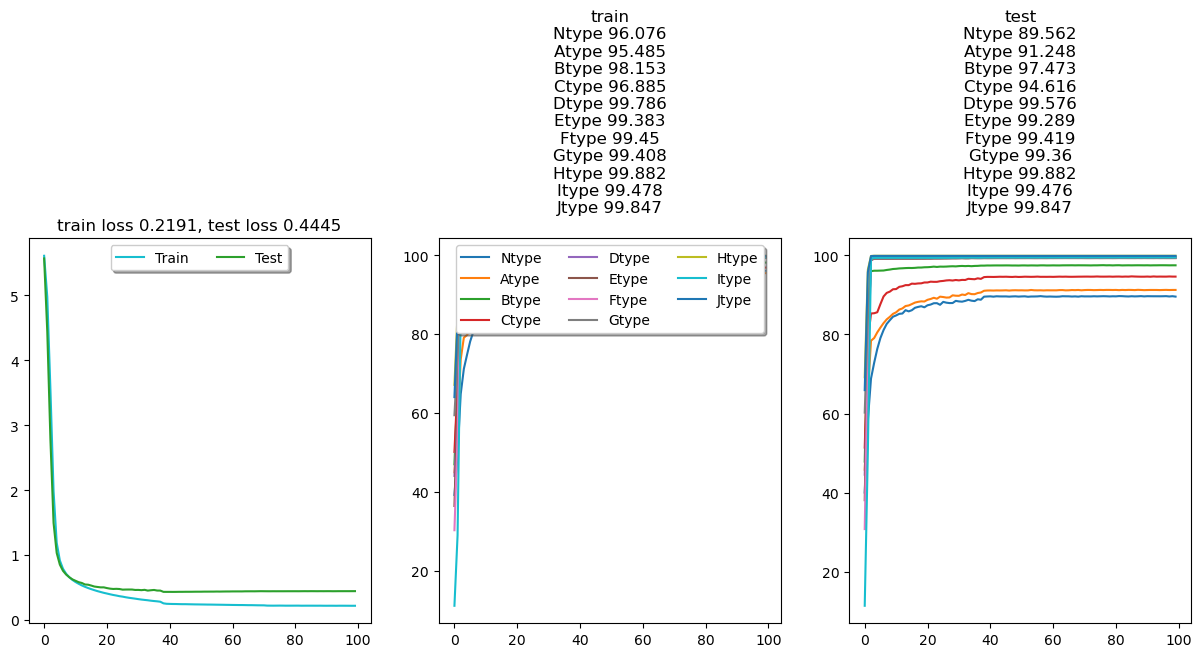

In [ ]:
plot_losses(train_loss_hist,test_loss_hist,train_acc_hist,test_acc_hist)

In [ ]:
print_results(results_df,targets)

Number of SMILES: 43889
All: num of variables: 1615

prediction target Ntype (3 classes)
              precision    recall  f1-score   support

           0    0.90832   0.90007   0.90418     23227
           1    0.89087   0.90459   0.89768     18185
           2    0.81063   0.78805   0.79918      2477

    accuracy                        0.89562     43889
   macro avg    0.86994   0.86424   0.86701     43889
weighted avg    0.89558   0.89562   0.89556     43889

[[20906  1936   385]
 [ 1664 16450    71]
 [  446    79  1952]]
Cohen's kappa:  0.8085005159457656
Matthew's coeff:  0.8085496837475165

prediction target Ntype (2 classes)
              precision    recall  f1-score   support

       False    0.90832   0.90007   0.90418     23227
        True    0.88880   0.89788   0.89332     20662

    accuracy                        0.89904     43889
   macro avg    0.89856   0.89898   0.89875     43889
weighted avg    0.89913   0.89904   0.89907     43889

[[20906  2321]
 [ 2110 18552]]

/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.

              precision    recall  f1-score   support

           0    0.99349   0.99938   0.99642     43497
           1    0.79851   0.30398   0.44033       352
           2    0.00000   0.00000   0.00000        40

    accuracy                        0.99289     43889
   macro avg    0.59733   0.43445   0.47892     43889
weighted avg    0.99102   0.99289   0.99106     43889

[[43470    27     0]
 [  245   107     0]
 [   40     0     0]]
Cohen's kappa:  0.404271432622356
Matthew's coeff:  0.46450109582712573

prediction target Etype (2 classes)
              precision    recall  f1-score   support

       False    0.99349   0.99938   0.99642     43497
        True    0.79851   0.27296   0.40684       392

    accuracy                        0.99289     43889
   macro avg    0.89600   0.63617   0.70163     43889
weighted avg    0.99174   0.99289   0.99116     43889

[[43470    27]
 [  285   107]]
Cohen's kappa:  0.40413248451147266
Matthew's coeff:  0.46442480329422897
AUC:  0.951980

/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skaji/anaconda3/lib/python3.

### joint phase and temperature

In [ ]:
norm = "BatchNorm"
dropout=0.5
num_layers=12
hidden_channel=128
batchsize=256
lr = 5e-3
epochs= 1000
warmup_epochs = 10
plot_interval = 100

use_desc = "All" # "ShapeElectric" # "Shape" # "Electric" "Flexible"
varnames = list(desc_names[use_desc])
tabdataset = TabDataset(sub_df[varnames],sub_df[temp_targets],sub_df[phase_targets],device=device)
    
results = []
train_loss_hist = []
test_loss_hist = []
train_MAE_hist = []
test_MAE_hist = []
train_acc_hist = []
test_acc_hist = []
for cv in range(n_splits):
    print(f'CV {cv}')
    train_loss_hist.append([])
    test_loss_hist.append([])
    train_MAE_hist.append({k:[] for k in temp_targets})
    test_MAE_hist.append({k:[] for k in temp_targets})
    train_acc_hist.append({k:[] for k in phase_targets})
    test_acc_hist.append({k:[] for k in phase_targets})
    
    model = MLP(hidden_channels=hidden_channel,num_layers=num_layers, out_channels=dataset.output_channels).to(device)
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=1e-5)#, amsgrad=False)

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=100, min_lr=1e-6)
    scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3, 2*epochs//3], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])
    #scheduler = None

    train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(tabdataset,train_indices[cv]), batch_size=batchsize, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(tabdataset,test_indices[cv]), batch_size=batchsize)
    time_sta = time.time()
    with tqdm(range(epochs), unit="epoch") as titer:
        for epoch in titer:
            titer.set_description(f"Epoch {epoch}")
            train_loss,train_acc,train_MAEs = train(train_loader,mode='both',output_channel_masks=dataset.output_channel_masks)
            test_loss,test_acc,test_MAEs = test(test_loader,mode='both',output_channel_masks=dataset.output_channel_masks)
            if epoch % plot_interval == 0 or epoch==epochs-1:
                etim = time.time() - time_sta
                print(f"epoch {epoch}\ttrain loss: {round(train_loss,5)}\t"+
                      "\t".join([f'train MAE {temp_targets[k]}: {round(train_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      "\t".join([f'\ttrain acc {phase_targets[k]}: {round(train_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttest loss: {round(test_loss,5)}\t"+
                      "\t".join([f'test MAE {temp_targets[k]}: {round(test_MAEs[k].avg,5)}' for k in range(len(temp_targets[:3]))])+
                      "\t".join([f'\ttest acc {phase_targets[k]}: {round(test_acc[k].avg,5)}' for k in range(len(phase_targets[:3]))])+
                      f"\ttime {round(etim,0)}")
            train_loss_hist[-1].append(train_loss)
            test_loss_hist[-1].append(test_loss)
            for j,k in enumerate(temp_targets):
                train_MAE_hist[-1][k].append(train_MAEs[j].avg)
                test_MAE_hist[-1][k].append(test_MAEs[j].avg)
            for j,k in enumerate(phase_targets):
                train_acc_hist[-1][k].append(train_acc[j].avg)
                test_acc_hist[-1][k].append(test_acc[j].avg)
            titer.set_postfix(train_loss=train_loss, test_loss=test_loss)
    # prediction
    res=predict(test_loader,mode='both',targets=phase_targets+temp_targets,output_channel_masks=dataset.output_channel_masks)
    res=pd.DataFrame(res)
    res['index']=test_indices[cv]
    results.append(res)

# write results to file
results_df = sub_df[['SMILES','Phases']].copy().reset_index().rename(columns={'index':'ID'})
results_df2 = pd.concat(results).set_index('index').sort_index()
results_df = pd.concat([results_df,results_df2],axis=1)
results_df['pred_Phases']=pred_phases(results_df)
results_df.to_csv(os.path.join(outdir,'result_MLP_phase_temp.csv'),index=False)

CV 0


/home/skaji/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/1000 [00:00<?, ?epoch/s]

epoch 0	train loss: 124.04466	train MAE Clearing: 136.0261	train MAE Melting: 101.75793	train MAE Np: 155.31055	train acc Ntype: 50.44858		train acc Atype: 77.98411		train acc Btype: 84.89647	test loss: 121.7274	test MAE Clearing: 136.17921	test MAE Melting: 102.11017	test MAE Np: 148.38206	test acc Ntype: 61.67692		test acc Atype: 78.29802		test acc Btype: 96.1039	time 5.0


/home/skaji/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 100	train loss: 11.60359	train MAE Clearing: 11.00971	train MAE Melting: 11.00814	train MAE Np: 10.0219	train acc Ntype: 80.00057		train acc Atype: 83.60913		train acc Btype: 96.22056	test loss: 15.32007	test MAE Clearing: 15.0735	test MAE Melting: 15.10933	test MAE Np: 12.82434	test acc Ntype: 78.49168		test acc Atype: 83.25359		test acc Btype: 96.20643	time 455.0
epoch 200	train loss: 9.65891	train MAE Clearing: 9.17316	train MAE Melting: 9.3388	train MAE Np: 8.50386	train acc Ntype: 84.80248		train acc Atype: 87.84427		train acc Btype: 96.57657	test loss: 14.7594	test MAE Clearing: 14.66648	test MAE Melting: 14.8907	test MAE Np: 12.18742	test acc Ntype: 83.17384		test acc Atype: 85.87378		test acc Btype: 96.44566	time 899.0
epoch 300	train loss: 8.64012	train MAE Clearing: 8.11624	train MAE Melting: 8.38534	train MAE Np: 7.64406	train acc Ntype: 86.82179		train acc Atype: 89.66136		train acc Btype: 96.74461	test loss: 14.30603	test MAE Clearing: 14.26238	test MAE Melting: 14.5

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



epoch 100	train loss: 11.43001	train MAE Clearing: 10.85676	train MAE Melting: 10.93445	train MAE Np: 9.74638	train acc Ntype: 80.59353		train acc Atype: 85.05924		train acc Btype: 96.28902	test loss: 15.48477	test MAE Clearing: 15.31575	test MAE Melting: 15.59543	test MAE Np: 13.09158	test acc Ntype: 77.76005		test acc Atype: 84.07201		test acc Btype: 96.1946	time 441.0
epoch 200	train loss: 9.57945	train MAE Clearing: 9.07766	train MAE Melting: 9.21167	train MAE Np: 8.41129	train acc Ntype: 85.22442		train acc Atype: 87.70221		train acc Btype: 96.41718	test loss: 14.53562	test MAE Clearing: 14.73527	test MAE Melting: 14.77555	test MAE Np: 12.58158	test acc Ntype: 83.19471		test acc Atype: 85.99749		test acc Btype: 96.27435	time 860.0
epoch 300	train loss: 8.61242	train MAE Clearing: 8.20539	train MAE Melting: 8.39675	train MAE Np: 7.66578	train acc Ntype: 87.34905		train acc Atype: 89.66165		train acc Btype: 96.83014	test loss: 14.41769	test MAE Clearing: 14.67713	test MAE Melting: 1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



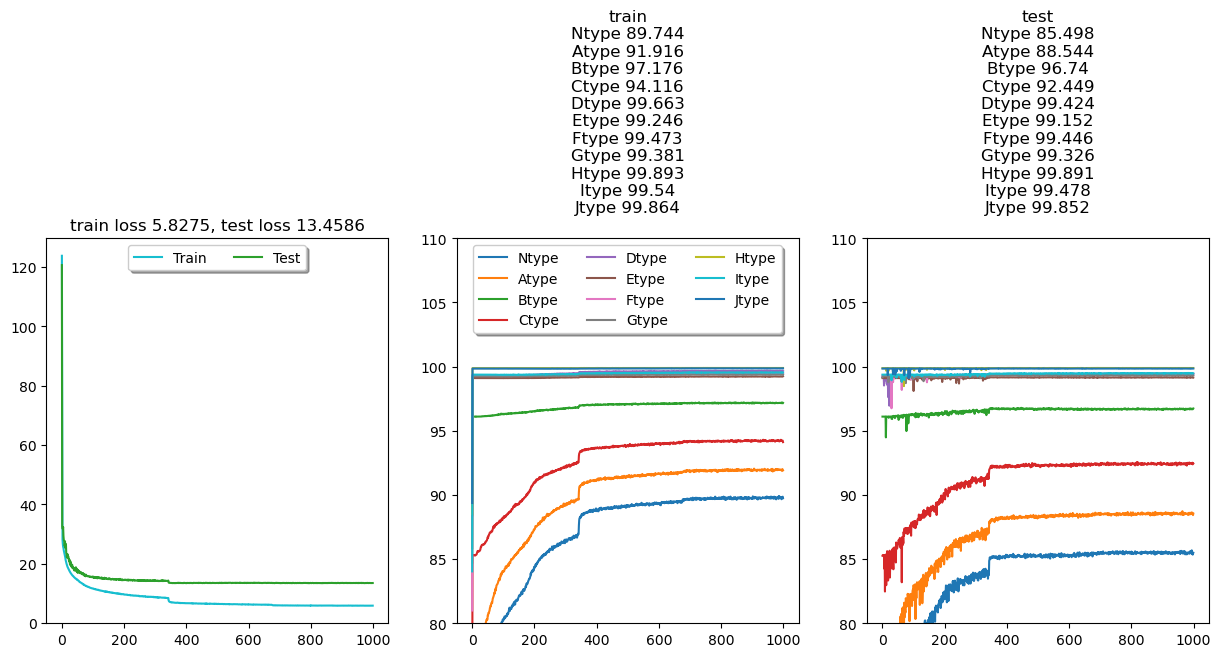

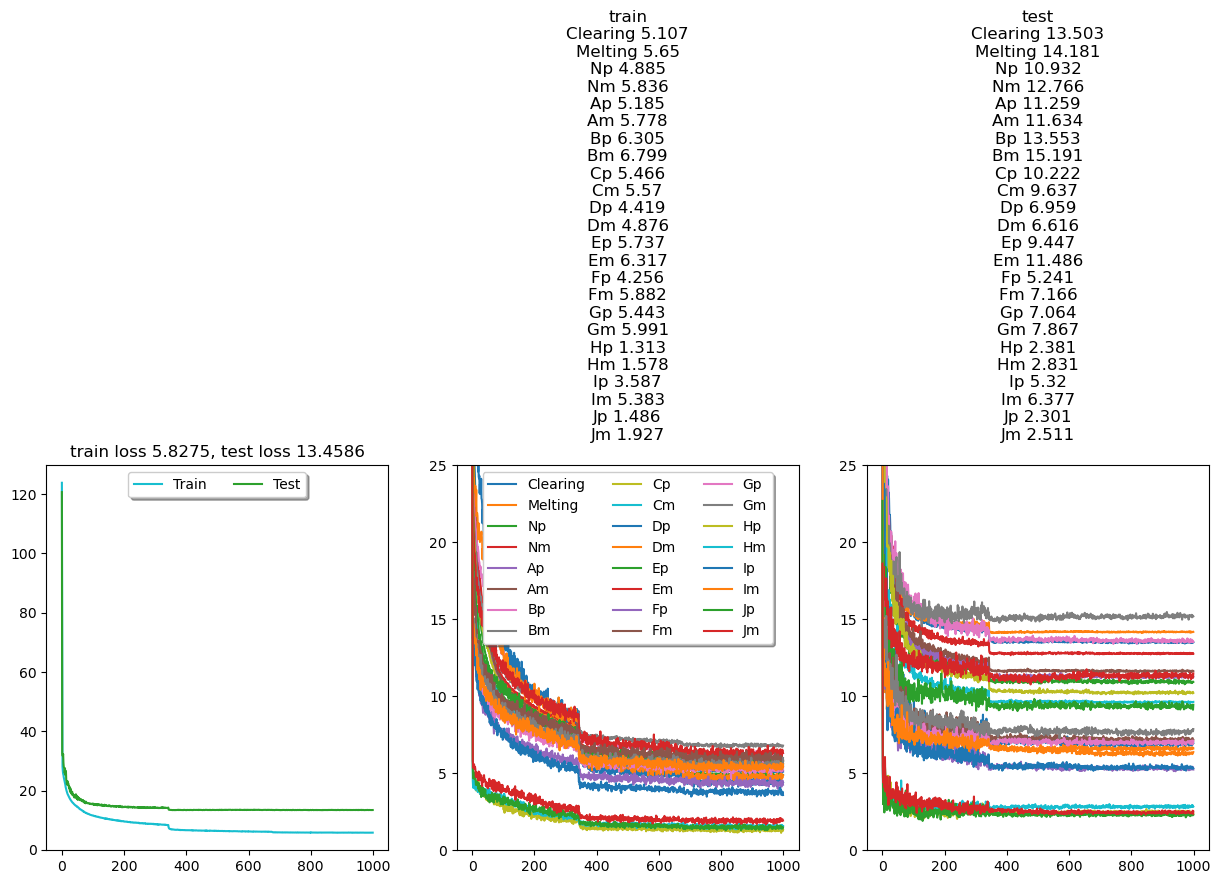

In [ ]:
plot_losses(train_loss_hist,test_loss_hist,train_acc_hist,test_acc_hist, ylim=(80,110))
plot_losses(train_loss_hist,test_loss_hist,train_MAE_hist,test_MAE_hist, ylim=(0,25))

In [ ]:
print_results(results_df,phase_targets)

Number of SMILES: 43889
All: num of variables: 1615

prediction target Ntype (3 classes)
              precision    recall  f1-score   support

           0    0.87259   0.87248   0.87253     23227
           1    0.84652   0.86714   0.85671     18185
           2    0.73147   0.60153   0.66017      2477

    accuracy                        0.85498     43889
   macro avg    0.81686   0.78038   0.79647     43889
weighted avg    0.85382   0.85498   0.85399     43889

[[20265  2569   393]
 [ 2262 15769   154]
 [  697   290  1490]]
Cohen's kappa:  0.7321698134296433
Matthew's coeff:  0.7323236048107897

prediction target Ntype (2 classes)
              precision    recall  f1-score   support

       False    0.87259   0.87248   0.87253     23227
        True    0.85667   0.85679   0.85673     20662

    accuracy                        0.86509     43889
   macro avg    0.86463   0.86463   0.86463     43889
weighted avg    0.86509   0.86509   0.86509     43889

[[20265  2962]
 [ 2959 17703]]

In [ ]:
ks = []
for k in temp_targets:
    ks.extend([f"error_{k}"])
#results_df[ks].to_csv(os.path.join(outdir,'error_GNN_temperature.csv'))
results_df[ks].describe()

error_Clearing  error_Melting      error_Np      error_Nm     error_Ap  \
count    43886.000000   43887.000000  20662.000000  20662.000000  9531.000000   
mean        13.502786      14.181354     10.983251     12.921862    11.378296   
std         16.973816      15.895142     14.175811     14.374227    14.832272   
min          0.000137       0.000031      0.000648      0.000565     0.002228   
25%          3.078630       3.947529      2.659300      3.676385     2.440414   
50%          7.672073       9.239761      6.405312      8.544004     6.120148   
75%         17.512383      18.854969     13.716980     17.119316    14.539036   
max        329.135651     309.162598    327.861694    302.961151   282.970642   

          error_Am     error_Bp     error_Bm     error_Cp     error_Cm  \
count  9531.000000  1710.000000  1710.000000  6444.000000  6444.000000   
mean     11.842627    13.715529    14.796945    10.433273    10.070134   
std      14.084367    15.337874    15.984586    13.231476    11.997228   
min       0.003143     0.010681     0.004992     0.000183     0.003647   
25%       3.070995     3.533440     4.073771     2.527828     2.804867   
50%       7.254471     8.837051     9.939513     6.080276     6.341179   
75%      15.523251    17.971523    19.941391    13.452253    12.905291   
max     268.354065   191.078979   184.715530   267.287720   249.547974   

         error_Dp    error_Dm    error_Ep    error_Em    error_Fp    error_Fm  \
count  341.000000  341.000000  392.000000  392.000000  307.000000  307.000000   
mean    18.579454   18.289335   12.107491   15.534292    8.419113   11.577724   
std     22.584038   21.473198   13.756028   16.620235   11.034281   12.929491   
min      0.115807    0.035538    0.054596    0.110405    0.018700    0.011940   
25%      4.025681    5.092354    3.088633    4.434528    2.097031    3.393410   
50%     10.500572   12.035866    7.636612   10.333927    4.594986    6.576160   
75%     24.680145   23.206284   15.687183   20.836855   10.017467   14.862295   
max    167.725815  200.230133   91.183922   96.303604   71.858170   68.715286   

         error_Gp    error_Gm   error_Hp   error_Hm    error_Ip    error_Im  \
count  328.000000  328.000000  52.000000  52.000000  274.000000  274.000000   
mean    10.502936   10.816733  11.099741  13.154708    9.164503   11.626381   
std     12.803295   13.609569  10.884594   9.921094   17.230280   17.547026   
min      0.061050    0.022064   0.490776   0.215488    0.015976    0.071884   
25%      2.739630    2.714669   3.545506   5.741795    2.110477    3.321592   
50%      7.079819    6.546638   6.908558  12.087734    4.779327    6.918755   
75%     14.467257   14.740257  14.785959  17.496340   10.379172   14.920820   
max    159.822723  171.589844  45.589127  48.552982  234.348190  231.775787   

        error_Jp   error_Jm  
count  67.000000  67.000000  
mean   10.715888  11.242750  
std    10.605879  10.172484  
min     0.162369   0.086044  
25%     3.306923   3.644852  
50%     6.867752   8.071136  
75%    15.146595  15.908646  
max    43.552162  47.160141

## Py-Boost

In [ ]:
!pip install cupy-cuda11x
!pip install py-boost

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from py_boost import GradientBoosting, SketchBoost
from py_boost.multioutput.sketching import *
from py_boost.multioutput.target_splitter import *


In [ ]:
targets = [lt+"type" for lt in phase_types]
sub_df = df

use_desc = "All" # "Shape" # "Electric" "Flexible"
varnames = desc_names[use_desc]

X=sub_df.loc[:,varnames].values
Y=sub_df.loc[:,targets].values
train_indices, test_indices = cv_split("classification",sub_df,n_splits=n_splits,targets=targets)
print(X.shape, Y.shape)

(43889, 1615) (43889, 11)


In [ ]:
# fitting
models=[]
clf = GradientBoosting # SketchBoost 
for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
    X_train,X_test,y_train,y_test=X[train_index],X[test_index],Y[train_index],Y[test_index]
    model = clf('crossentropy',
                         ntrees=10000, lr=0.03, verbose=10, es=300, lambda_l2=1, gd_steps=1,
                         subsample=1, colsample=1, min_data_in_leaf=20, use_hess=True,
                         max_bin=256, max_depth=10)

    model.fit(X_train, y_train, eval_sets = [{'X': X_test, 'y': y_test}])
    models.append(model)
    break


## CatBoost

In [ ]:
!conda install -c conda-forge catboost

In [ ]:
from catboost.utils import get_gpu_device_count
from catboost import Pool,CatBoost,CatBoostClassifier,CatBoostRegressor
from sklearn.metrics import accuracy_score
print(get_gpu_device_count())


2


### classification

In [ ]:
targets = phase_targets
sub_df = df

## select predictive variables
use_desc = "All" # "Shape" # "Electric" "Flexible"
varnames = desc_names[use_desc]

X=sub_df[varnames]
Y=sub_df[target]
pred = np.zeros_like(sub_df[target])
num_class=len(Y.unique())
print(X.shape, Y.shape)

evals_result = [{} for i in range(n_splits)]
models = []
for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
    X_train,X_test,y_train,y_test=X.iloc[train_index],X.iloc[test_index],Y.iloc[train_index],Y.iloc[test_index]
    clf = CatBoostClassifier(num_boost_round=10000,verbose=200,
                           loss_function='MultiClass',eval_metric='Accuracy',
                           learning_rate=0.03,
                            max_depth=10,
                            random_seed=42,min_data_in_leaf=20,
                            l2_leaf_reg=1,# auto_class_weights=True,
                            #task_type='GPU',
                            thread_count=num_cores
                           )
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_score = clf.predict_proba(X_test)
    #pred = clf.predict(X_test)
    pred[test_index] = np.argmax(y_score,axis=1)
    models.append(clf)

# save results
result_df = sub_df[['ID','SMILES',target]].copy()
result_df['pred_'+target]=pred
result_df['error_'+target]=np.abs(pred-Y)
result_df = result_df.sort_values('ID')
result_df.to_csv(f'result_Cat_{use_desc}_{target}.csv',index=False)
result_df.head()




### regression

In [ ]:
## select predictive variables
use_desc = "All" # "Shape" # "Electric" "Flexible"
varnames = desc_names[use_desc]

lr = 0.05

X=sub_df[varnames]
Y=sub_df[targets]
pred = np.zeros_like(Y)

evals_result = [{} for i in range(n_splits)]
models = []
for i, (train_index, test_index) in enumerate(zip(train_indices,test_indices)):
    X_train,X_test,y_train,y_test=X.iloc[train_index],X.iloc[test_index],Y.iloc[train_index],Y.iloc[test_index]
    clf = CatBoostRegressor(num_boost_round=20000,verbose=5000,
                             loss_function='MultiRMSE',
                            learning_rate=lr,
                            max_depth=10, # max_leavs=2**6,
                            random_seed=42,
                            l2_leaf_reg=1,                    
                            #task_type='GPU',
                            thread_count=num_cores
                           )
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_score = clf.predict(X_test)
    pred[test_index] = y_score
    print(np.abs(y_test-y_score).mean(axis=0))
    models.append(clf)

# save results
result_df = sub_df[['ID','SMILES','Phases',target]].copy()
result_df['pred_'+target]=pred
result_df['error_'+target]=np.abs(pred-Y)
result_df = result_df.sort_values('ID')
result_df.to_csv(f'result_Cat_{use_desc}_{target}.csv',index=False)
result_df.head()


In [ ]:
num = 10
#feature_importance = model.get_feature_importance()
sorted_feature_importance = model.feature_importances_.argsort()[:10]
plt.barh(varnames[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = varnames[sorted_feature_importance])

# Misc

## molecule graph as networkx

In [ ]:
## molecule graph as networkx
import networkx as nx
from collections import defaultdict

def mol_to_nx(mol):
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G

def plot_nx(G):
    colour_map = defaultdict(lambda x:'gray')
    colour_map['C']='cyan'
    colour_map['O']='orange'
    colour_map['N']='magenta'
    nx.draw_spring(G,
            labels=nx.get_node_attributes(G, 'atom_symbol'),
            with_labels = True,
            node_color=[colour_map[G.nodes[idx]['atom_symbol']] for idx in G.nodes()],
            node_size=500)

    plt.show()
        
G = mol_to_nx(mol)
plot_nx(G)

## Process management

In [ ]:
# terminate child processes
from multiprocessing import active_children
active = active_children()
for child in active:
#    child.terminate()
    child.kill()
    

## Plot statistics

In [ ]:
import seaborn as sns; 
sns.set()

df = pd.read_csv("size_dependence.csv", index_col=0)
df.describe()

#%%
df
#%%
target = "D"
x = df.index
x.name = "training data size"
tags = [target + pm for pm in ['p','m']]
#tags = [target + pm for pm in ['p_r','m_r']]
tagss = [target + pm for pm in ['+','-']]
for tag in tags:
    medians = df['q2_{}'.format(tag)]
    medians.name = 'K'
    quartiles1 = df['q1_{}'.format(tag)]
    quartiles1.name = '25%'
    quartiles3 = df['q3_{}'.format(tag)]
    quartiles3.name = '75%'
    ax = sns.lineplot(x, medians) 
    ax.fill_between(x, quartiles1, quartiles3, alpha=0.3)
ax.legend(tagss)
fig = ax.get_figure()
fig.savefig(target+"_size_dependence.png")

## df comparison

In [ ]:
# check-up!
for target in temperature_types:
    df.loc[df[target]<kelv,target]=np.nan
    mask = (np.abs(phtemp[target]-df[target])<1) | (np.isnan(phtemp[target]) & np.isnan(df[target]))
    print(target, sum(~mask))
    for (i,sd),k,r,ex in zip(df[~mask].iterrows(),phtemp[target][~mask],reentrant[~mask],exclude[~mask]):
        print(i,sd['Phases'],"\tDF: ",sd[target],"New: ",k, "reentrant: ",r, "exclude: ",ex)